In [8]:
# %load_ext cudf.pandas
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from math import ceil, floor 
import pandas as pd
import pandas_ta as pdta
import config
import time
import schedule
from datetime import datetime
from datetime import date
from datetime import timedelta
import numpy as np
import statsmodels.api as sm
import scipy as sp
from scipy.stats import theilslopes , linregress
from scipy.ndimage import gaussian_filter1d , generic_filter1d
import scipy.signal as signal
import scipy.interpolate as si
from scipy.signal import find_peaks
from scipy import stats
import pywt #https://pywavelets.readthedocs.io/en/latest/ref/index.html
import mplcursors
import pickle
# import gtda
# from gtda.time_series import SingleTakensEmbedding
# from gtda.homology import VietorisRipsPersistence
# from gtda.plotting import plot_diagram
# from groq import Groq
# import anthropic
# import pprint
# from sklearn.linear_model import TheilSenRegressor

# import networkx as nx

# import matplotlib.dates as mdates
# import alpaca
import ta as ta
import pytz
import datetime
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.requests import MarketOrderRequest ,LimitOrderRequest, ClosePositionRequest
from alpaca.data.requests import StockLatestQuoteRequest, CryptoLatestQuoteRequest
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
from IPython.display import display, clear_output
from alpaca.data.requests import CryptoBarsRequest, StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import pandas_ta as pdta
import config
import os
from alpaca.trading.requests import GetOrdersRequest
from alpaca.trading.enums import OrderSide,OrderClass,OrderType, QueryOrderStatus, OrderStatus

from sklearn.preprocessing import MinMaxScaler
# plt.style.use('dark_background')
global count, alt_pkl_file_path

alt_pkl_file_path = 2 #next 0
print(f"alt_pkl_file_path: {alt_pkl_file_path}")
print("\n")
if alt_pkl_file_path==0:
    api = REST(config.alpaca_paper_api_key, config.alpaca_paper_secret_key,base_url=config.alpaca_paper_endpoint)
elif alt_pkl_file_path==1:
    api = REST(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key,base_url=config.alpaca_paper_counter_endpoint)
elif alt_pkl_file_path==2:
    api = REST(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key,base_url=config.alpaca_paper_mega_endpoint)    

count = 0  # Initialize counter

bbma_trading_final =None
vol_anomaly=None
def main():
    clear_output(wait=True)
    global symbol,calculate_MACD,look_back_days,all_possible_symbols,no_short_symbols,positions,account,data,data5,avg_price,historic,MACD_derivative,MACD,HMACD,cumsum,macd_trading_final, api,reststart,restend,start,end,stock_client,trading_client,hours_since_last_noon,time_incriment
    

    
    if alt_pkl_file_path==0:
        trading_client = TradingClient(config.alpaca_paper_api_key, config.alpaca_paper_secret_key, paper=True)
        stock_client = StockHistoricalDataClient(config.alpaca_paper_api_key,  config.alpaca_paper_secret_key)
        api = REST(config.alpaca_paper_api_key, config.alpaca_paper_secret_key,base_url=config.alpaca_paper_endpoint)
    elif alt_pkl_file_path==1:
        trading_client = TradingClient(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key, paper=True)
        stock_client = StockHistoricalDataClient(config.alpaca_paper_counter_api_key,  config.alpaca_paper_counter_secret_key)
        api = REST(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key,base_url=config.alpaca_paper_counter_endpoint)
    elif alt_pkl_file_path==2:
        trading_client = TradingClient(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key, paper=True)
        stock_client = StockHistoricalDataClient(config.alpaca_paper_mega_api_key,  config.alpaca_paper_mega_secret_key)
        api = REST(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key,base_url=config.alpaca_paper_mega_endpoint)

    account = trading_client.get_account()
    account
    print(account)
    # crypto_client = CryptoHistoricalDataClient(config.alpaca_paper_api_key,  config.alpaca_paper_secret_key)



    # Get the market calendar
    calendar = api.get_calendar()
    now = datetime.datetime.utcnow()
    # Get today's date
    today = datetime.datetime.today().date()

    # Find the last trading day
    last_trading_day = None

    for day in reversed(calendar):
        if pd.Timestamp(day.date).date() < today:  # convert Timestamp to date
            last_trading_day = pd.Timestamp(day.date, hour=12, tz='UTC')
            break

    # Current time
    now = datetime.datetime.now(pytz.UTC)

    # Calculate the difference in hours
    hours_since_last_noon = int((now - last_trading_day).total_seconds() / 3600)-16

    print(last_trading_day)
    print(hours_since_last_noon)

    if str(datetime.datetime.utcnow().time()) < '13:29:59.000000':
        lookbak_time = 24
    elif '08:00:00.971400' < str(datetime.datetime.utcnow().time()) <'16:00:00.971400'  and str(datetime.datetime.utcnow().time()) <'20:00:00.971400':
        lookbak_time = 12
    elif '16:00:00.971400' < str(datetime.datetime.utcnow().time())  and str(datetime.datetime.utcnow().time()) <'20:00:00.971400':
        lookbak_time = 16
    elif str(datetime.datetime.utcnow().time()) > '20:00:00.971400':
        lookbak_time = 20
        # print('lookbak_time',lookbak_time)
    else:
        # lookbak_time = 24
        pass
    print('lookbak_time',lookbak_time)
    look_back_days = 2
    look_back_days_vertiacl = 0
    
    # multisymbol_request_params = StockLatestQuoteRequest(symbol_or_symbols=symbol)
    Histoic_start = datetime.datetime.today()-timedelta(days=4)#
    start = datetime.datetime.now(pytz.utc)-timedelta( days=look_back_days,hours= float(lookbak_time))#hours_since_last_noon)+16)#24 #days=365)# #(2023,1,1)#hours_since_last_noon
    starter = datetime.datetime.now(pytz.utc)-timedelta(days=look_back_days,hours= float(lookbak_time))#hours_since_last_noon)+16)#24
    start2 = datetime.datetime.now(pytz.utc)-timedelta(days=3, hours= float(lookbak_time))#hours_since_last_noon)+16)#24 #days=365)# #(2023,1,1)#hours_since_last_noon
    reststart2 = start2.strftime("%Y-%m-%dT%H:%M:%SZ")    
    # First calculate the timedelta

    # Then apply the timedelta to the current time with 1 day back
    end_time = datetime.datetime.now(pytz.utc) - timedelta(days=look_back_days)
    # Now apply replace to the datetime object, not the timedelta
    end = end_time.replace(hour=20, minute=0, second=0, microsecond=0)
    print(f"end: {end}")
    # Do the same for restender
    restender = datetime.datetime.now(pytz.utc) - timedelta(days=look_back_days)
    restender = restender.replace(hour=20, minute=0, second=0, microsecond=0)
    print(f"restender: {restender}")
    reststart = start.strftime("%Y-%m-%dT%H:%M:%SZ")
    restend = restender.strftime("%Y-%m-%dT%H:%M:%SZ")
    print('-----------------TIME :',datetime.datetime.now(),'-----------------')
    all_possible_symbols  = ['TQQQ,SQQQ,NVDA,USO,TSLA,SCO,UNH,YINN,YANG,NUGT,DUST,UVXY,KOLD,BOIL,LABU,LABD,TNA,TZA,FAS,FAZ,SOXL,SOXS,ERY,ERX,']
    symbol = ['TQQQ,SQQQ,NVDA,USO,TSLA,SCO,UNH,YINN,YANG,NUGT,DUST,UVXY,KOLD,BOIL,LABU,LABD,TNA,TZA,FAS,FAZ,SOXL,SOXS,ERY,ERX,']
    no_short_symbols = ['ERY,ERX,']

    positions = trading_client.get_all_positions()

    ###TIME SENSITIVITY###
    time_sensev = 0.50
    time_incriment = 1 # 10
    time_incriment5 = 10
    # if count == 0:
    #     time_incriment =1
    #     print('count==0',count)

    # # else:
    # #     time_incriment =2
    # #     print('slower',time_incriment)
    # elif count > 0 :
    #     if (abs(bbma_trading_final.iloc[-1]> 0).sum() / len(bbma_trading_final.iloc[-1])) > time_sensev and (abs(vol_anomaly.iloc[-1]>1.75).sum() / len(vol_anomaly.iloc[-1])) > time_sensev:
    #         print(count)
    #         time_incriment =1
    #         print('faster',time_incriment)
    #     else:
    #         time_incriment =2
    #         print('else slower',time_incriment)

    print('time_incriment: ',time_incriment)
    print('count;',count)
    if count >0:
        print('faster count: ',abs(bbma_trading_final.iloc[-1]> 0).sum())
        print('faster count: ',(abs(bbma_trading_final.iloc[-1]> 0).sum() / len(bbma_trading_final.iloc[-1])) > time_sensev and (abs(vol_anomaly.iloc[-1]>1.75).sum() / len(vol_anomaly.iloc[-1])) > time_sensev)


    timeframeunit = TimeFrameUnit.Minute #TimeFrameUnit.Day
    data= api.get_bars(symbol, TimeFrame(time_incriment,timeframeunit), str(reststart),str(restend),).df #CBSE BNCU
    #look_back = 400
    data=data.bfill()#.bfill()#.bfill()#.iloc[-look_back:] #.iloc[:(len(bars)-2)]
    data.reset_index(inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms',utc=True)
    data = data.set_index('timestamp')

    data =data.drop_duplicates(keep='last')
    data = data.pivot(columns='symbol',values=data.columns)

    fill_mapping = {column_name: column_name for column_name in data.symbol.columns}
    data['symbol'] = data.symbol.apply(lambda col: col.fillna(fill_mapping[col.name]))
    data.close = data.close.ffill()
    data.high = data.high.ffill()
    data.low = data.low.ffill()
    data.open = data.open.ffill()
    data.close = data.close.bfill()
    data.high = data.high.bfill()
    data.low = data.low.bfill()
    data.open = data.open.bfill()
    #### USE BID ASK FOR BETTER PRICING ######
    colsym = data.close.columns.get_level_values(0).unique()
    bid_ask_s = api.get_latest_quotes(symbols=colsym)

    for col in colsym:
        avg_price = (bid_ask_s[col].ap + bid_ask_s[col].bp) / 2
        data= data.replace(data['close'][col].iloc[-1],avg_price)
        # print(col,data['close'][col][-1],avg_price)

    data5= api.get_bars(symbol, TimeFrame(time_incriment5,timeframeunit), str(reststart),str(restend),).df #CBSE BNCU
    #look_back = 400
    data5=data5.bfill()#.bfill()#.bfill()#.iloc[-look_back:] #.iloc[:(len(bars)-2)]
    data5.reset_index(inplace=True)
    data5['timestamp'] = pd.to_datetime(data5['timestamp'], unit='ms',utc=True)
    data5 = data5.set_index('timestamp')

    data5 =data5.drop_duplicates(keep='last')
    data5 = data5.pivot(columns='symbol',values=data5.columns)

    fill_mapping = {column_name: column_name for column_name in data5.symbol.columns}
    data5['symbol'] = data.symbol.apply(lambda col: col.fillna(fill_mapping[col.name]))
    data5.close = data5.close.ffill()
    data5.high = data5.high.ffill()
    data5.low = data5.low.ffill()
    data5.open = data5.open.ffill()
    data5.close = data5.close.bfill()
    data5.high = data5.high.bfill()
    data5.low = data5.low.bfill()
    data5.open = data5.open.bfill()
    #### USE BID ASK FOR BETTER PRICING ######
    colsym5 = data5.close.columns.get_level_values(0).unique()
    bid_ask_s5 = api.get_latest_quotes(symbols=colsym5)

    for col in colsym:
        avg_price5 = (bid_ask_s5[col].ap + bid_ask_s5[col].bp) / 2
        data5= data5.replace(data['close'][col].iloc[-1],avg_price5)

    request_params = StockBarsRequest(symbol_or_symbols=symbol,start=Histoic_start, end=end, timeframe=TimeFrame(time_incriment,timeframeunit)) # use singal symblos til solving how to work with multi symbol manipulation
    historic = stock_client.get_stock_bars(request_params)
    historic = historic.df
    historic = historic.ffill()
    historic = historic.bfill()#.bfill()#.bfill()#.iloc[-look_back:] #.iloc[:(len(bars)-2)]
    historic.reset_index(inplace=True)
    historic['timestamp'] = pd.to_datetime(historic['timestamp'], unit='ms',utc=True)
    historic = historic.set_index('timestamp')

    historic =historic.drop_duplicates(keep='last')
    historic = historic.pivot(columns='symbol',values=historic.columns)

    fill_mapping = {column_name: column_name for column_name in historic.symbol.columns}
    historic['symbol'] = historic.symbol.apply(lambda col: col.fillna(fill_mapping[col.name]))
    # historic = historic.droplevel('symbol')
    historic = historic.bfill()

    cumsum = data.close.pct_change()
    cumsum = ((cumsum + 1).cumprod())-1

    open_orders_request_params = GetOrdersRequest(status=QueryOrderStatus.OPEN)
    open_orders = trading_client.get_orders(open_orders_request_params)
    if open_orders == []:
        order = open_orders
    else:
        order =  open_orders[0]
    cancel_open_order = trading_client.cancel_orders()
    if order!=[]:
        cancel_open_order
        print("Open Order Canceled")
    else:
        print('No Open Order')

    def calculate_MACD(cumsum):
        MACD = pd.DataFrame(index=cumsum.index)

        for col in cumsum.columns:
            ema_12 = cumsum[col].ewm(12).mean() #10
            ema_26 = cumsum[col].ewm(26).mean() #50
            MACD[col] = ema_12 - ema_26

        return MACD #abs(MACD)

    MACD = calculate_MACD(cumsum)
    MACD_derivative = abs(MACD.diff(2))

    macd_positions_raw = MACD.shift(periods= -1) - MACD.rolling(7).mean()  # assuming ema20 #7
    macd_trading_positions = macd_positions_raw.apply(np.sign)
    macd_trading_final = macd_trading_positions.shift(1).bfill()
    HMACD = calculate_MACD(historic.close)



    # cumsum.iloc[-1].nlargest(len(cumsum))
    # plt.show()
    # def calculate_signal(column):
    #     first_raw = column.shift(-1) > column.ewm(span=30).mean()
    #     first_positions = first_raw.astype(int)  # Convert boolean to int
    #     first_positions_final = first_positions.shift(1)
    #     return first_positions_final


    # # Use apply() to apply the function across all columns
    # signal = data.close.apply(calculate_signal)

    def combined_signal():

        global apply_filter ,history,portfolio_df,portfolio_df_pivot,stored_data_df,stored_bbmavg_df,stored_ema_df,vwap_df,stored_vwap_df, historic,bbmavg,vol_anomaly,bbma_trading_final,calculate_vwap_for_symbol,vwap,filtfilt,filtfilt2,hfiltfilt,filtered_data,trading_final,vtrading_final,hma_trading_final,timestamp,timestamp2

        def apply_filter(column):
            global filt1
            # print(bbma_trading_final[column].iloc[-1] < 0)
            if bbma_trading_final is None :#and vol_anomaly==None:
                filt1 = 0.08
                # print(column.name,"still here")
            elif bbma_trading_final is not None:
                if bbma_trading_final[column.name].iloc[-1] < 0 or vol_anomaly[column.name].iloc[-1] < 1.75: #pnl_trading_final[0].iloc[-1] > 0: #bbma_trading_final[column.name].iloc[-1] < 0 or vol_anomaly[column.name].iloc[-1] < 1.75 or macd_trading_final[column.name].iloc[-1] <0 or
                    filt1 = 0.08
                    # print(vol_anomaly[column.name].iloc[-1] ,filt1)
                elif bbma_trading_final[column.name].iloc[-1] > 0 or vol_anomaly[column.name].iloc[-1] > 1.75: #pnl_trading_final[0].iloc[-1] < 0: #bbma_trading_final[column.name].iloc[-1] > 0 or vol_anomaly[column.name].iloc[-1] > 1.75 or macd_trading_final[column.name].iloc[-1] >0 or
                    filt1 = 0.08
                    # print(vol_anomaly[column.name].iloc[-1] ,filt1)
                # print(column.name,filt1)
            else:
                pass

            b, a = signal.butter(2, filt1)

            column = column.ffill().bfill()
            if len(column) < 50:
                pad_length = len(column) // 2  # Set padlen to half the length of column

                return signal.filtfilt(b, a, x=column, method="pad", padlen=pad_length, padtype="constant")
            else:
                return signal.filtfilt(b, a, x=column, method="pad", padlen=len(column)-1, padtype="constant")

        symboli = data['close'].columns
        filtfilt = pd.DataFrame({symbol: apply_filter(data['close'][symbol]) for symbol in symboli}, index=data.close.index)
        filtfilt = filtfilt.fillna(filtfilt.rolling(2).mean())

        hfiltfilt = pd.DataFrame({symbol: apply_filter(historic['close'][symbol]) for symbol in symboli}, index=historic.close.index)
        hfiltfilt = hfiltfilt.fillna(hfiltfilt.rolling(2).mean())
        # print(filtfilt)
        def history(volume_data, close_data):
            vol_std = volume_data.std()
            # vol_u = volume_data + (vol_std * 1.5)
            # vol_d = volume_data - (vol_std * 1.5)
            # vol_geo_mean = np.exp(np.log(volume_data).mean())
            # vol_median = volume_data.median()
            # vol_quart = volume_data.quantile([0.25, 0.5, 0.75])
            vol_10_day_avg = close_data.ewm(span=10).mean()
            # vol_10_day_std = close_data.rolling(window=10).std()
            return np.where(vol_10_day_avg.shift(periods= -1)  > (close_data.ewm(span=10e2).mean()*1.75), 2, 1.5)

        symbols = historic['close'].columns
        vol_anomaly = pd.DataFrame({symbol: history(data['volume'][symbol],historic['volume'][symbol]) for symbol in symbols},index=historic.close.index)

        def apply_filter2(column):
            d, c = signal.butter(2, 0.05)
            # Remove NaN values before applying the filter

            column = column.fillna(column.mean())
            if len(column) < 50:
                return signal.filtfilt(d, c, x=column, method="gust", padlen=50, padtype="constant")
            else:
                # If the column has less than 50 elements, using a smaller padding length.
                return signal.filtfilt(d, c, x=column, method="gust", padlen=len(column)-1, padtype="constant")

        # Assuming that 'data' is your DataFrame
        # Accessing the 'close' attribute of data and applying the filter to all columns
        symbols = data['close'].columns
        # data.symbol
        filtfilt2 = pd.DataFrame({symbol: apply_filter2(data5['close'][symbol]) for symbol in symbols},index=data5.close.index)
        filtfilt2 = filtfilt2.fillna(filtfilt2.rolling(2).mean())

        symbols = data.close.columns.get_level_values(0).unique()
        global current_utc_time,latest_data,latest_data_df
        # Check if stored_data_df exists. If not, initialize it.
        if 'stored_data_df' not in globals():
            stored_data_df = pd.DataFrame()

        # Get the current UTC timestamp
        current_utc_time = pd.Timestamp.now(tz='UTC')

        # Extract the latest data for all symbols
        latest_data = filtfilt.iloc[-1]

        # Convert the latest data to DataFrame and transpose
        latest_data_df = latest_data.to_frame(name=current_utc_time).T

        # Append the latest data to stored_data_df
        # stored_data_df = stored_data_df.append(latest_data_df)
        stored_data_df = pd.concat([stored_data_df, latest_data_df])

        # if count > 2:



        bbmavg = data.close.fillna(data.close.mean()).apply(lambda x: ta.volatility.bollinger_mavg(x, 30)) # assuming BBwindow is 20

        columns_to_convert = ['high', 'low', 'close', 'volume']

        # Assuming your data has multi-level columns like ('high', 'QQQ'), ('low', 'QQQ'), etc.
        for col in columns_to_convert:
            for symbol in data.columns.get_level_values(1).unique():
                data[col, symbol] = pd.to_numeric(data[col, symbol], errors='coerce')

        # Getting the symbols in your data (e.g. QQQ, SPY)
        symbols = data.columns.get_level_values(1).unique()

        # Create an empty DataFrame to store VWAP values
        global vwap,vwapu,vwapd,vwapq,vwapq2,combined,ammount,rsi_df, datakelter,kelter,dataema20,databbsma,kelter_channels,trading_final,datahma,trading_final2,vtrading_final2,macd_signal,macd_signals,macd_fin,macd1_fin
        vwap = pd.DataFrame(index=data.index);vwapu= pd.DataFrame(index=data.index);vwapd= pd.DataFrame(index=data.index);vwapq= pd.DataFrame(index=data.index);vwapq2= pd.DataFrame(index=data.index);datakelter = pd.DataFrame(index=data.close.index);kelter = pd.DataFrame(index=data.close.index);kelter_channels=pd.DataFrame(index=data.close.index)
        # Loop through each symbol and calculate VWAP
        #!
        import warnings

        # Ignore specific UserWarnings related to timezone in Pandas
        warnings.filterwarnings('ignore', message="Converting to PeriodArray/Index representation will drop timezone information.")
        # Loop through each symbol and calculate VWAP
        for symbol in symbols:
            high = data["high", symbol].bfill()
            low = data["low", symbol].bfill()
            close = data["close", symbol].bfill()
            volume = data["volume", symbol].bfill()


            # Calculate VWAP
            temp_vwap = pdta.vwap(high, low, close, volume)

            # If temp_vwap index loses timezone, reapply UTC
            if temp_vwap.index.tzinfo is None:
                temp_vwap.index = temp_vwap.index.tz_localize('UTC')

            vwap[symbol] = temp_vwap

            # ####
            # # Calculate standard deviation of the price from the VWAP
            # std_dev = (close - vwap[symbol]).rolling(window=14).std()

            # # Calculate upper and lower bands based on 1.5 standard deviations
            # vwapu[symbol] = vwap[symbol].std() + 1.5 * std_dev
            # vwapd[symbol] = vwap[symbol].std() - 1.5 * std_dev
            # ####
        # for symbol in symbols:
        #     high = data["high", symbol]
        #     low = data["low", symbol]
        #     close = data["close", symbol]

        #     # Fill missing values with the next available value for each symbol's data
        #     high.fillna(method='backfill', inplace=True)
        #     low.fillna(method='backfill', inplace=True)
        #     close.fillna(method='backfill', inplace=True)

        #     # You may also want to fill missing values for 'volume' column in the same way,
        #     # but I'm assuming 'pdta.kc' does not use the 'volume' data.

        #     kelter_channels = pdta.kc(high, low, close, length=10, scalar=1.5, mamode="ema")

        #     # Rename the kelter_channels columns with the symbol prefix
        #     kelter_channels.columns = [f"{symbol}_{column}" for column in kelter_channels.columns]

        #     # Add the kelter_channels results to the kelter DataFrame
        #     kelter = pd.concat([kelter, kelter_channels], axis=1)

        # # Create a multi-index for the kelter DataFrame
        # kelter.columns = pd.MultiIndex.from_tuples([col.split('_') for col in kelter.columns])

        # print(datakelter)

        ############

        if 'stored_bbmavg_df' not in globals():
            stored_bbmavg_df = pd.DataFrame()

        # Get the current UTC timestamp
        # current_utc_time = pd.Timestamp.now(tz='UTC')

        # Calculate bbmavg for each symbol and append it to stored_data_df
        bbmavg_df = data.close.fillna(data.close.mean()).apply(lambda x: ta.volatility.bollinger_mavg(x, 30))

        latest_bbmavg_ = bbmavg_df.iloc[-1]

        latest_bbmavg_df = latest_bbmavg_.to_frame(name=current_utc_time).T

        stored_bbmavg_df = pd.concat([stored_bbmavg_df, latest_bbmavg_df])
        stored_bbmavg_df

        ############

        datahma = data.close.apply(lambda x: pdta.hma(x, 20))

        dataema20 = data.close.apply(lambda x: pdta.ema(x, 30)) # assuming BBwindow is 20

        databbsma = data.close.apply(lambda x:ta.volatility.bollinger_mavg(x,14,)) #.fillna(data.close.mean()).bfill()
        # macd_signal = data.close.fillna(method= "ffill").bfill().apply(lambda x: pdta.momentum.macd(close = x, fast=12,slow=26,signal=9))

        symbols = data.close.columns.get_level_values(0).unique()

        rsi_df = pd.DataFrame()
        for symbol in symbols:
          close =data.close[symbol]
          rsi_df[symbol] = pdta.momentum.rsi(close=close, window=14,)
        rsi_df = rsi_df.bfill()

        symbols = data.close.columns.get_level_values(0).unique()
        macd_signal = pd.DataFrame()
        macd_signals = pd.DataFrame()
        macd_raw = pd.DataFrame()
        macd_pos = pd.DataFrame()
        macd_fin = pd.DataFrame()
        macd1_raw = pd.DataFrame()
        macd1_pos = pd.DataFrame()
        macd1_fin = pd.DataFrame()

        for symbol in symbols:
            close = data.close[symbol]#.fillna(method= "ffill").bfill()
            macd_signal = pdta.macd(close = close, fast=12,slow=26,signal=9)

            # Rename the MACD signal column to include the symbol
            macd_signals[symbol+'_Macd'] = macd_signal.iloc[0:,0]
            macd_signals[symbol+'_Signal'] = macd_signal.iloc[0:,1]
            macd_signals[symbol+'_Hist'] = macd_signal.iloc[0:,2]

            macd_raw[symbol] = macd_signals[symbol+'_Macd'].shift(periods= -1) - macd_signals[symbol+'_Signal'].rolling(10).min()
            macd_pos[symbol] = macd_raw[symbol].apply(np.sign)
            macd_fin[symbol] = macd_pos[symbol].shift(1).bfill()

            macd1_raw[symbol] = macd_signals[symbol+'_Macd'].shift(periods= -1) - macd_signals[symbol+'_Signal'].rolling(10).min()
            macd1_pos[symbol] = macd1_raw[symbol].apply(np.sign)
            macd1_fin[symbol] = macd1_pos[symbol].shift(1).bfill()


        global hmacd_signal,hmacd_signals
        hsymbols = historic.close.columns.get_level_values(0).unique()
        hmacd_signal = pd.DataFrame()
        hmacd_signals = pd.DataFrame()

        for symbol in hsymbols:
            hclose = historic.close[symbol].ffill().bfill()
            hmacd_signal = pdta.macd(close = hclose, fast=12,slow=26,signal=9)

            # Rename the MACD signal column to include the symbol
            hmacd_signals[symbol+'_Macd'] = hmacd_signal.iloc[0:,0]
            hmacd_signals[symbol+'_Signal'] = hmacd_signal.iloc[0:,1]
            hmacd_signals[symbol+'_Hist'] = hmacd_signal.iloc[0:,2]

        if 'stored_ema_df' not in globals():
            stored_ema_df = pd.DataFrame()

        # Get the current UTC timestamp
        # current_utc_time = pd.Timestamp.now(tz='UTC')

        # Calculate bbmavg for each symbol and append it to stored_data_df
        ema_df = data.close.ffill().bfill().apply(lambda x: pdta.ema(x, 30))

        latest_ema_ = ema_df.iloc[-1]

        latest_ema_df = latest_ema_.to_frame(name=current_utc_time).T

        # stored_ema_df = stored_ema_df.append(latest_ema_df)
        stored_ema_df = pd.concat([stored_ema_df, latest_ema_df])
        stored_ema_df

        ############

        if 'stored_vwap_df' not in globals():
            stored_vwap_df = pd.DataFrame()

        # Get the current UTC timestamp
        # current_utc_time = pd.Timestamp.now(tz='UTC')
        global latest_vwap_
        vwap_df = pd.DataFrame()
        for symbol in symbols:
            high = data["high", symbol].bfill()
            low = data["low", symbol].bfill()
            close = data["close", symbol].bfill()
            volume = data["volume", symbol].bfill()
            # Calculate bbmavg for each symbol and append it to stored_data_df
            vwap_df[symbol] = pdta.vwap(high, low, close, volume)


        latest_vwap_ = vwap_df.iloc[-1]

        latest_vwap_df = latest_vwap_.to_frame(name=current_utc_time).T

        # stored_vwap_df = stored_vwap_df.append(latest_vwap_df)
        stored_vwap_df = pd.concat([stored_vwap_df, latest_vwap_df])

        global trading_positions_raw ,trading_positions,new_combined,shortema,longema,new_combined_raw,new_combined_spread,new_combined_gap,hshortema,hlongema,hnew_combined,hnew_combined_spread,hnew_combined_gap,spreader_,new_combined2
        vwap=vwap.fillna(vwap.mean())
        vwapq = (vwap + filtfilt.rolling(1).mean() + bbmavg.fillna(bbmavg.mean())) / 3
        vwapq2 = (vwap + filtfilt2.rolling(3).mean() + dataema20.fillna(dataema20.mean())) / 3

        # filtfilt=stored_data_df
        # stored_vwap_df=stored_vwap_df.fillna(stored_vwap_df.mean())
        # vwapq = (stored_vwap_df + filtfilt.rolling(1).mean() + stored_bbmavg_df.fillna(stored_bbmavg_df.mean())) / 3
        # vwapq2 = (stored_vwap_df + filtfilt.rolling(3).mean() + stored_ema_df.fillna(stored_ema_df.mean())) / 3

        # # Trading positions based on indicators
        # trading_positions_raw = filtfilt.shift(periods= -1) - filtfilt.ewm(7).mean()#filtfilt.shift(periods= -1) - filtfilt.ewm(10).mean() #filtfilt.shift(periods=-1) - datahma.ewm(10).mean() #rolling
        # trading_positions = trading_positions_raw.apply(np.sign)
        # trading_final = trading_positions.shift(1)

        # trading_positions_raw2 = filtfilt.shift(periods= -1) - filtfilt.ewm(15).mean()#filtfilt.shift(periods= -1) - filtfilt.ewm(20).mean() #filtfilt.shift(periods=-1) - datahma.ewm(10).mean() #rolling
        # trading_positions2 = trading_positions_raw2.apply(np.sign)
        # trading_final2 = trading_positions2.shift(1)

        # # vwap
        vtrading_positions_raw2 = vwapq.shift(periods= -1) - vwapq.ewm(5).mean()
        vtrading_positions2 = vtrading_positions_raw2.apply(np.sign)
        vtrading_final2 = vtrading_positions2.shift(1).bfill()

        # basic
        short_window =20
        long_window =30

        # if pnl_trading_final[0].iloc[-1] > 0:

        data_5 = data.low.resample('1Min').mean()
        data_interpolated5 = data_5.interpolate(method='nearest')
        shortema = data.low.rolling(short_window).mean()
        longema = data.low.ewm(long_window).mean()

        new_combined_raw = filtfilt.shift(periods= -1) - shortema #  filtfilt.shift(periods= -1) - longema .shift(periods= -1) combined_hist.stored_data_df[symbol] longema[symbol]
        new_combined_pos = new_combined_raw.apply(np.sign)
        new_combined = new_combined_pos.shift(1).bfill()



        new_combined_raw2 = filtfilt.shift(periods= -1) - longema #.shift(periods= -1) combined_hist.stored_data_df[symbol] longema[symbol] macd_trading_final
        new_combined_pos2 = new_combined_raw2.apply(np.sign)
        new_combined2 = new_combined_pos2.shift(1).bfill()

        #!
        # new_combined_count = pd.DataFrame()
        # for col in new_combined.columns.get_level_values(0).unique():

        new_combined_spread = filtfilt - longema #abs(filtfilt - longema)
        spreader_raw= new_combined_spread.shift(periods= -1) - new_combined_spread.ewm(10).mean()
        spreader_pos = spreader_raw.apply(np.sign)
        spreader_ = spreader_pos.shift(1).bfill()


        new_combined_gap = pd.DataFrame()
        for col in new_combined_spread.columns.get_level_values(0).unique():
            new_combined_gap[col] = np.where(new_combined_spread[col] > new_combined_spread[col].quantile(0.5),1,-1)

        hshort_window =10
        hlong_window =30
        hshortema = historic.high.ewm(span=hshort_window, adjust=False).mean()
        hlongema = historic.low.ewm(span=hlong_window, adjust=False).mean()

        hnew_combined_raw = hfiltfilt.shift(periods= -1) - hlongema
        hnew_combined_pos = hnew_combined_raw.apply(np.sign)
        hnew_combined = hnew_combined_pos.shift(1).bfill()

        hnew_combined_spread = abs(hfiltfilt - hlongema)
        global wiz,hnew_combined_gap4,hnew_combined_gap3,hnew_combined_gap2,hnew_combined_gap1,hnew_combined_gap
        hnew_combined_gap = pd.DataFrame(index=new_combined_spread.index)
        hnew_combined_gap1 = pd.DataFrame(index=new_combined_spread.index)
        hnew_combined_gap2 = pd.DataFrame(index=new_combined_spread.index)
        hnew_combined_gap3 = pd.DataFrame(index=new_combined_spread.index)
        hnew_combined_gap4 = pd.DataFrame(index=new_combined_spread.index)
        wiz = pd.DataFrame(index=new_combined_spread.index)
        for col in hnew_combined_spread.columns.get_level_values(0).unique():
            hnew_combined_gap[col] = np.where(new_combined_spread[col] > hnew_combined_spread[col].quantile(0.5),1,0)
            hnew_combined_gap1[col] = np.where(new_combined_spread[col] > hnew_combined_spread[col].quantile(0.6),1,0)
            hnew_combined_gap2[col] = np.where(new_combined_spread[col] > hnew_combined_spread[col].quantile(0.7),1,0)
            hnew_combined_gap3[col] = np.where(new_combined_spread[col] > hnew_combined_spread[col].quantile(0.8),1,0)
            hnew_combined_gap4[col] = np.where(new_combined_spread[col] > hnew_combined_spread[col].quantile(0.9),1,0)
            wiz[col]  = hnew_combined_gap[col] + hnew_combined_gap1[col] + hnew_combined_gap2[col] + hnew_combined_gap3[col] + hnew_combined_gap4[col]


        global rsi_trading_final
        # Trading positions based on indicators
        ##filtfilt.shift(periods= -1) - filtfilt.ewm(10).mean() #filtfilt.shift(periods=-1) - datahma.ewm(10).mean() #rolling
        trading_positions_raw = filtfilt.shift(periods= -1) - filtfilt.ewm(5).mean()
        trading_positions = trading_positions_raw.apply(np.sign)
        trading_final = trading_positions.shift(1).bfill()

        trading_positions_raw2 = filtfilt.shift(periods= -1) - filtfilt.ewm(7).mean()#filtfilt.shift(periods= -1) - filtfilt.ewm(20).mean() #filtfilt.shift(periods=-1) - datahma.ewm(10).mean() #rolling
        trading_positions2 = trading_positions_raw2.apply(np.sign)
        trading_final2 = trading_positions2.shift(1).bfill()

        # vwap
        vtrading_positions_raw = vwapq.shift(periods= -1) - vwapq.ewm(5).mean()#datahma.shift(periods=-1) - vwapq.ewm(1).mean() # vwapq #data.ema20
        vtrading_positions = vtrading_positions_raw.apply(np.sign)
        vtrading_final = vtrading_positions.shift(1).bfill()
        # hma
        hma_positions_raw = vwapq.shift(periods= -1) - vwapq.ewm(3).mean()#filtfilt.shift(periods= -1) - datahma.ewm(15).mean()  # assuming vwapq ,data.ema20 data.\bbsma
        hma_trading_positions = hma_positions_raw.apply(np.sign)
        hma_trading_final = hma_trading_positions.shift(1).bfill()

        rsi_df15 = rsi_df.rolling(30).mean()
        rsi_positions_raw = rsi_df15.shift(periods= -1) - rsi_df15.ewm(5).mean().rolling(15).max()#filtfilt.shift(periods= -1) - datahma.ewm(15).mean()  # assuming vwapq ,data.ema20 data.\bbsma
        rsi_trading_positions = rsi_positions_raw.apply(np.sign)
        rsi_trading_final = rsi_trading_positions.shift(1).bfill().ffill()

        combined = pd.concat([trading_final,trading_final2, vtrading_final, hma_trading_final,vtrading_final2], axis=1,
                            keys=['trading_final','trading_final2', 'vtrading_final', 'hma_trading_final','vtrading_final2'])



        global diff_bbsma ,vix,combined_metric,data_bbsma,idiff,databbhband,databblband,databbspread,hbbmavg,hibbhband,hbblband,hbbspread,hbbsma
        # bbhband
        # for symbol in symbols:

        databbhband = data.close.apply(lambda x: ta.volatility.bollinger_hband(x, window=14, window_dev=2,)) #.fillna(data.close.mean()).bfill()
        databblband = data.close.apply(lambda x: ta.volatility.bollinger_lband(x, window=14, window_dev=2,))#.fillna(data.close.mean()).bfill()

        databbspread = (databbhband - databblband)/2
        diff_bbsma = databbsma.bfill().diff(5)
        data_bbsma = databbspread.ewm(3).mean().bfill() #bbsma #bbspread
        BBwindow=14
        historic = historic.ffill()
        historic = historic.bfill()
        hbbmavg = historic.close.apply(lambda x: ta.volatility.bollinger_mavg(x, 20))
        hbbhband = historic.close.apply(lambda x: ta.volatility.bollinger_hband(x, window=20, window_dev=2,)) #.fillna(data.close.mean()).bfill()
        hbblband = historic.close.apply(lambda x: ta.volatility.bollinger_lband(x, window=20, window_dev=2,))#.fillna(data.close.mean()).bfill()
        hbbspread = (hbbhband - hbblband)/2
        hbbsma = hbbspread.ewm(2).mean().bfill()
        idiff = .05

        columns_to_convert = ['high', 'low', 'close']
        for col in columns_to_convert:
            for symbol in data.columns.get_level_values(1).unique():
                data[col, symbol] = pd.to_numeric(data[col, symbol], errors='coerce')

        # Getting the symbols in your data (e.g. QQQ, SPY)
        symbols = data.columns.get_level_values(1).unique()
        global data_adx,adx_pos,adx_neg
        # Create an empty DataFrame to store ADX values
        data_adx = pd.DataFrame()
        adx_pos = pd.DataFrame()
        adx_neg = pd.DataFrame()
        # Loop through each symbol and calculate ADX

        # Suppress specific RuntimeWarnings in the context block
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            for symbol in symbols:
                epsilon = 1e-8  # A small number to avoid division by zero
                high = data["high", symbol].ffill().bfill() + epsilon
                low = data["low", symbol].ffill().bfill() + epsilon
                close = data["close", symbol].ffill().bfill() + epsilon
                # print(high,low,close)
                # Calculate ADX and store in data_adx DataFrame
                data_adx[symbol] = ta.trend.adx(high, low, close, window=14)
                adx_pos[symbol] = ta.trend.adx_pos(high, low, close, window=14)
                adx_neg[symbol] = ta.trend.adx_neg(high, low, close, window=14)


        data_adx = data_adx.ffill().bfill() #.fillna(data_adx.mean())
        adiff = 0.005
        global adx_trading_final, Strong_Trend,level3,level2,level1,bbma_trading_final,bbmavg_trading_final, adx_above_below,macdlevel1,macdlevel2,macdlevel3,adx_trading_pos,adx_neg_final,adx_neg_raw,adx_pos_raw
        adx_positions_raw = data_adx.shift(periods= -2) - data_adx.ewm(10).mean() # assuming ema20
        adx_trading_positions = adx_positions_raw.apply(np.sign)
        adx_trading_final = adx_trading_positions.shift(1).bfill()
        adx_trading_final = adx_trading_final.ffill()

        # adx_pos = adx_pos.ewm(2).mean()
        # adx_neg = adx_neg.ewm(2).mean()
        adx_pos_raw = adx_pos.shift(periods= -1) - adx_pos.ewm(10).mean() # assuming ema20
        adx_trading_pos = adx_pos_raw.apply(np.sign)
        adx_trading_pos = adx_trading_pos.shift(1).bfill()

        adx_neg_raw = adx_pos.shift(periods= -1) - adx_neg.ewm(10).mean() # assuming ema20
        adx_trading_neg = adx_neg_raw.apply(np.sign)
        adx_neg_final = adx_trading_neg.shift(1).bfill()

        adx_above_below = pd.DataFrame(np.where(data_adx > 20, 1, -1), index=data_adx.index, columns=data_adx.columns)

        # macd_above_below = pd.DataFrame(np.where(data_adx > .016, 1, -1), index=#data_adx.index, columns=#data_adx.columns)

        bbma_positions_raw = data_bbsma.shift(periods= -1) - data_bbsma.rolling(10).mean() # assuming ema20
        bbm_trading_positions = bbma_positions_raw.apply(np.sign)
        bbma_trading_final = bbm_trading_positions.shift(1).bfill()

        bbmavg = data.close.fillna(data.close.mean()).apply(lambda x: ta.volatility.bollinger_mavg(x, 15)) # assuming BBwindow is 20
        bbmavg_positions_raw = bbmavg.shift(periods=-1) - bbmavg.ewm(span=10).mean()  # Use span=5 instead of span=20 for EMA
        bbmavg_trading_positions = np.sign(bbmavg_positions_raw)
        bbmavg_trading_final = bbmavg_trading_positions.shift(1)


        symbols = data_adx.columns.get_level_values(0).unique()
        Strong_Trend = pd.DataFrame()


        for symbol in symbols:
            Strong_Trend[symbol] = data_adx[symbol].apply(lambda x: 2 if x > 26 else 1.5)

        Hprice_min = hbbsma.min() # minimum price
        Hprice_max = hbbsma.max() # maximum price
        Hdiff = Hprice_max - Hprice_min
        level1 = Hprice_max - .382 * Hdiff
        level2 = Hprice_max - .418 * Hdiff
        level3 = Hprice_max - .886 * Hdiff

        HMACD_min = HMACD.min() # minimum price
        HMACD_max = HMACD.max() # maximum price
        HMACDdiff = HMACD_max - HMACD_min
        macdlevel1 = HMACD_max - .382 * HMACDdiff
        macdlevel2 = HMACD_max - .418 * HMACDdiff
        macdlevel3 = HMACD_max - .886 * HMACDdiff



        ##### proto ##########
        global proto
        positions = trading_client.get_all_positions()

        # Initialize data structures
        symbols_data = {}
        all_symbols = data.close.columns.get_level_values(0).unique()

        # Populate data structures with position information
        for position in positions:
            current_price = float(data.close[position.symbol].iloc[-1])  # Ensure current_price is a float
            avg_entry_price = float(position.avg_entry_price)  # Ensure avg_entry_price is a float
            market_value = float(position.market_value)
            qty = float(position.qty)  # Ensure avg_entry_price is a float
            pnl_cash = (current_price - avg_entry_price )*qty
            pnl_percentage = ((current_price - avg_entry_price ) / avg_entry_price) * 100 if avg_entry_price != 0 else 0

            symbols_data[position.symbol] = {
                'avg_entry_price': avg_entry_price,
                'current_price': current_price,
                'market_value':market_value,
                'pnl_cash': pnl_cash,
                'pnl_percentage': pnl_percentage
            }

        # Add default data for symbols without positions
        for symbol in all_symbols:
            if symbol not in symbols_data:
                current_price = float(data.close[symbol].iloc[-1])  # Ensure current_price is a float

                symbols_data[symbol] = {
                    'avg_entry_price': 0,
                    'current_price': current_price,
                    'market_value': 0,
                    'pnl_cash': 0,
                    'pnl_percentage': 0
                }

        # Create a DataFrame from the populated data
        current_utc_time = pd.Timestamp.now(tz='UTC')
        df_data = {
            'Timestamp': [],
            'Symbol': [],
            'Avg_Entry_Price': [],
            'Current_Price': [],
            'Market_Value':[],
            'PnL_Cash': [],
            'PnL_Percentage': []
        }

        for symbol, info in symbols_data.items():
            # print(df_data)
            df_data['Timestamp'].append(current_utc_time)
            df_data['Symbol'].append(symbol)
            df_data['Avg_Entry_Price'].append(info['avg_entry_price'])
            df_data['Current_Price'].append(info['current_price'])
            df_data['Market_Value'].append(info['market_value'])
            df_data['PnL_Cash'].append(info['pnl_cash'])
            df_data['PnL_Percentage'].append(info['pnl_percentage'])

        proto = pd.DataFrame(df_data)
        proto.set_index(['Timestamp'], inplace=True)
        proto = proto.pivot(values=['Avg_Entry_Price','Current_Price','Market_Value','PnL_Cash','PnL_Percentage'], columns='Symbol')


        # Display the DataFrame
        # # SYMBOLS SHOULD GO HORIZONTAL AND YOU WOULD HAVE TO DO df.Avg_Entry_Price.PSQ OR df.Current_Price.SOXL
        # # MAKE THE AVRAGE ENTRY ALPHABETICAL AND SEE HOW YOU CAN USE CURRANT PRICE TO CAPTURE SPEED ANOMALY
        # for col in df.Avg_Entry_Price.columns.get_level_values(0).unique():
        #     plt.plot(df.Avg_Entry_Price[col])
        pd.set_option('display.max_columns', None)

        ##### invproto #######

        global invproto
        positions = trading_client.get_all_positions()

        # Initialize data structures
        invsymbols_data = {}
        symbols_with_positions = [position.symbol for position in positions]
        all_symbols = data.close.columns.get_level_values(0).unique()


        not_positions = list(filter(lambda x: x not in symbols_with_positions,all_symbols ))


        # Populate data structures with information for symbols not held as positions
        for symbol in not_positions:
          # print(symbol)
          last_sell_orders = api.list_orders(symbols=[symbol], status='closed', limit=1, side='sell')
          # print(last_sell_orders)
          if last_sell_orders:
              sellor = last_sell_orders[0]  # Get the first (and only) order in the list
              # print(sellor.filled_avg_price)

              avg_exit_price = float(sellor.filled_avg_price)
              # print(symbol, avg_exit_price)
              current_price = float(data.close[symbol].iloc[-1])  # Ensure current_price is a float
              # calculate_average_exit_price(symbol)  # Placeholder for average exit price calculation
              # pnl_cash = (avg_exit_price - current_price) * assumed_qty  # Placeholder for assumed quantity
              ipnl_percentage = ((avg_exit_price - current_price) / current_price) * 100 if current_price != 0 else 0

              invsymbols_data[symbol] = {
                  'avg_exit_price': avg_exit_price,
                  'current_price': current_price,
                  # 'pnl_cash': pnl_cash,
                  'pnl_percentage': ipnl_percentage
              }

        # Add default data (zeroes) for symbols currently held as positions
        for position in positions:
            invsymbols_data[position.symbol] = {
                'avg_exit_price': 0,
                'current_price': current_price,
                # 'pnl_cash': 0,
                'pnl_percentage': 0
            }

        # Create a DataFrame from the populated data
        current_utc_time = pd.Timestamp.now(tz='UTC')
        idf_data = {
            'Timestamp': [],
            'Symbol': [],
            'Avg_Exit_Price': [],
            'Current_Price': [],
            # 'PnL_Cash': [],
            'PnL_Percentage': []
        }

        for symbol, info in invsymbols_data.items():
            idf_data['Timestamp'].append(current_utc_time)
            idf_data['Symbol'].append(symbol)
            idf_data['Avg_Exit_Price'].append(info['avg_exit_price'])
            idf_data['Current_Price'].append(info['current_price'])
            # idf_data['PnL_Cash'].append(info['pnl_cash'])
            idf_data['PnL_Percentage'].append(info['pnl_percentage'])

        # print('df_data',len(df_data['Current_Price']),len(df_data['Avg_Exit_Price']),len(df_data['PnL_Percentage']))
        invproto = pd.DataFrame(idf_data)
        invproto.set_index(['Timestamp'], inplace=True)
        invproto = invproto.pivot(values=['Avg_Exit_Price','Current_Price','PnL_Percentage'], columns='Symbol')#'PnL_Cash',
        invproto


        global pnl_trading_final, pnl,normalized_pnl_series,pnl_values,portfolio,level3C,pnl
        portfolio= api.get_portfolio_history(date_start=str(starter.date()),date_end=str(end.date()),timeframe=TimeFrame(1,TimeFrameUnit.Minute),extended_hours=True)

        timestamps =  portfolio.timestamp
        utc_dates = [datetime.datetime.utcfromtimestamp(ts) for ts in timestamps]
        level3C = pd.DataFrame(index=data_bbsma.index, columns=level3.index)
        # Backfill the DataFrame with the values from level3
        level3C = level3C.fillna(level3)

        # utc_dates
        pnl = pd.DataFrame(data=portfolio.equity,index=utc_dates)
        pnl15 = pnl.rolling(15).mean()
        pnl_positions_raw = pnl.shift(periods= -1) - pnl.ewm(5).mean()  # assuming ema20
        pnl_trading_positions = pnl_positions_raw.apply(np.sign)
        pnl_trading_final = pnl_trading_positions.shift(1)
        # Assuming pnl is a pandas Series or DataFrame column in your script
        pnl_values = pnl.values.reshape(-1, 1)  # Reshape data to fit the scaler's expected input format

        # Create a scaler object with the desired range
        scaler = MinMaxScaler(feature_range=(-6, 4))

        # Fit and transform the data
        normalized_pnl = scaler.fit_transform(pnl_values)

        # Convert back to a pandas Series for consistency
        normalized_pnl_series = pd.Series(normalized_pnl.flatten(), index=pnl.index)

        # List of symbols
        symbols = list(set(trading_final.columns) & set(trading_final2.columns) & set(vtrading_final.columns) & set(hma_trading_final.columns) & set(vtrading_final2.columns))

        # Initialize empty DataFrame to store the results
        combined = pd.DataFrame()
        combined.index = trading_final.index
        ammount = pd.DataFrame()
        ammount.index = trading_final.index
        #######
        # Loop over each symbol
        global trading_data,trading_data2,vtrading_data,hma_trading_data,vtrading_data2,conditions2, values2,conditions,values,adx_above_below_,adx_trading_final_,bbma_trading_final_,level3_,data_bbsma_


        ammount= ammount.replace(np.nan, 4000).ffill().fillna(4000)
        combined = combined.replace(np.nan, 0).ffill().fillna(0)

            # print((Strong_Trend[symbol][-1] > 1.75))

        # Now `combined` is a DataFrame with each symbol as a column and the combined values based on your conditions
        # return combined['combined']

        today = datetime.datetime.now().date()-timedelta(days=look_back_days+look_back_days_vertiacl)#rizz

        # Combine it with the desired time (13:30 UTC)
        desired_time = datetime.time(13,30)  # 13:3
        timestamp = datetime.datetime.combine(today, desired_time)
        desired_time2 = datetime.time(14,00)  # 14:30
        timestamp2 = datetime.datetime.combine(today, desired_time2)

    combined_signal()



    global all_dfs_dict,comb_full_path,today_
    today_ = datetime.datetime.now().strftime('%y%m%d')
    def concat_dataframes(dfs_dict):
        """
        Concatenate the provided dictionary of DataFrames horizontally to create a multi-index DataFrame.
        """
        # Use dictionary comprehension to set keys as primary index level and DataFrame columns as secondary index level
        dfs_multiindex = {key: df.set_axis(pd.MultiIndex.from_product([[key], df.columns]), axis=1) for key, df in dfs_dict.items()}

        # Concatenate along columns
        return pd.concat(dfs_multiindex.values(), axis=1)
#!
    def append_dfall_to_pickle(dfs_dict, pickle_file_path):
        global today, combined_df, latest_datec, existing_dfc
        today = datetime.datetime.now().strftime('%y%m%d')
        comb_full_path_ = f'{today}_{pickle_file_path}'

        combined_df = concat_dataframes(dfs_dict)

        # Check if the file already exists
        if os.path.isfile(comb_full_path_):
            # If it exists, read the pickle file and get the latest date
            with open(comb_full_path_, 'rb') as f:
                existing_dfc = pickle.load(f)
            
            # Ensure the index is of a consistent type, here converting to datetime for example
            existing_dfc.index = pd.to_datetime(existing_dfc.index, errors='coerce')

            latest_datec = existing_dfc.index.max()

            # Filter the new DataFrame to only include entries after the latest date
            combined_df.index = pd.to_datetime(combined_df.index, errors='coerce')
            combined_df = combined_df[combined_df.index > latest_datec]

            # Append the filtered DataFrame to the pickle file (if there are any new rows)
            if not combined_df.empty:
                existing_dfc = pd.concat([existing_dfc, combined_df])
                with open(comb_full_path_, 'wb') as f:
                    pickle.dump(existing_dfc, f)
        else:
            # If the file doesn't exist, write the entire DataFrame
            with open(comb_full_path_, 'wb') as f:
                pickle.dump(combined_df, f)
    # [Your data processing code here...]

    # At the end of your data processing code, call the append_df_to_csv function with all your DataFrames:
    all_dfs_dict = {
        "stored_data_df": stored_data_df,
        "stored_bbmavg_df": stored_bbmavg_df,
        "stored_ema_df": stored_ema_df,
        "stored_vwap_df": stored_vwap_df
    }

    # append_dfall_to_pickle(all_dfs_dict, 'Signals.pkl')
    if 'stored_full_df' not in globals():
        stored_full_df = pd.DataFrame()

    # Get the current UTC timestamp
    # current_utc_time = pd.Timestamp.now(tz='UTC')
    global latest_full_

    latest_full_ = data.iloc[-1]

    latest_full_df = latest_full_.to_frame(name=current_utc_time).T

    # stored_vwap_df = stored_vwap_df.append(latest_vwap_df)
    stored_full_df = pd.concat([stored_full_df, latest_full_df])
    stored_full_df.index.name = 'index'
    # Get the current UTC timestamp

    # Assuming 'data' is your existing DataFrame and 'today' is defined
    global combined_hist,comb_pkl_file_path,fake_date

    # Get the current UTC timestamp
    fake_date = '250627'
    today_date = pd.Timestamp(fake_date)    

    if alt_pkl_file_path==0:
        pkl_filename = f'{today}_stored_full_df.pkl'
    elif alt_pkl_file_path==1:
        pkl_filename = f'{today}_counter_stored_full_df.pkl'
    elif alt_pkl_file_path==2:
        pkl_filename = f'{today}_mega_stored_full_df.pkl'

    # Check if the file exists
    # if not os.path.isfile(pkl_filename):
    #     # If the file doesn't exist, create it with headers
    #     latest_full_df.to_pickle(pkl_filename)
    # else:
    #     # If the file exists, append without writing the header
    #     latest_full_df.to_pickle(pkl_filename)
        
    if alt_pkl_file_path==0:
        comb_full_path2 = fake_date+'_Signals.pkl'
        comb_pkl_file_path = 'Signals.pkl'
        comb_full_path = f'{today_}_{comb_pkl_file_path}'
    elif alt_pkl_file_path==1:
        comb_full_path2 = fake_date+'_counter_Signals.pkl'
        comb_pkl_file_path = 'counter_Signals.pkl'
        comb_full_path = f'{today_}_{comb_pkl_file_path}'
    elif alt_pkl_file_path==2:
        comb_full_path2 = fake_date+'_mega_Signals.pkl'
        comb_pkl_file_path = 'mega_Signals.pkl'
        comb_full_path = f'{today_}_{comb_pkl_file_path}'

    if os.path.exists(comb_full_path2):
        # Load the CSV file, parse the first column as dates, and set it as the index
        combined_hist = pd.read_pickle(comb_full_path2) #comb_full_path
        #combined_hist.index = pd.to_datetime(combined_hist.index)
        #combined_hist = combined_hist[combined_hist.index.date == today_date.date()]
        # combined_hist = combined_hist[combined_hist.index.date == today_date.date()]



##################################
    dpi = 70
    w, l = 20, 8

    global df,df_pivot, dx,row,alll,ordi,all_orders_request_params,solo_full_path,ordi_start,ordi_end,append_df_to_csv,all_orders_request_params2,ordi2,alll2,dx2,row2,df_pivot2,df2
    ordi_start = datetime.datetime.utcnow()-timedelta(hours=float(hours_since_last_noon)+160)#-timedelta(hours=float(20))
    ordi_end = datetime.datetime.utcnow()#-timedelta(days=float(1))#+timedelta(hours=float(20))
    # print(ordi_start)
    # print(ordi_end)
    # print(symbol)
    # PortfolioHistory = api.get_portfolio_history(date_start=str(start.date()), date_end=str(end.date()),timeframe='1Min').df
    # PortfolioHistory

    DFsymbols_with_positions = [position.symbol for position in positions]
    #! uncomment out
    all_orders_request_params2 = GetOrdersRequest(status=QueryOrderStatus.CLOSED, limit=500, after=str(ordi_start), until=str(ordi_end), OrderSide=QueryOrderStatus.CLOSED, symbols=list(all_possible_symbols))
    alll2 = trading_client.get_orders(filter=all_orders_request_params2)
    if alll2 != []:
      dx2 = []
      for ordi2 in alll2:
          row2 = {}
          row2['symbol'] = ordi2.symbol
          row2['submitted_at'] = pd.to_datetime(ordi2.submitted_at)

          # Check if the symbol is in positions. If it is, set to 1, otherwise set to -1
          if ordi2.symbol in DFsymbols_with_positions:
              row2['side'] = 1
          else:
              row2['side'] = -1

          dx2.append(row2)
    else:
      pass

    # Create DataFrame
    df2 = pd.DataFrame(dx2)

    # Pivot DataFrame
    df_pivot2 = df2.pivot_table(index='submitted_at', columns='symbol', values='side', aggfunc='first').ffill()


    all_orders_request_params = GetOrdersRequest(status=QueryOrderStatus.CLOSED,limit=600,after=str(ordi_start),until=str(ordi_end),OrderSide=QueryOrderStatus.CLOSED,symbols=list(all_possible_symbols))
    alll= trading_client.get_orders(filter= all_orders_request_params)

    dx = []
    side_mapping = {'buy': 1, 'sell': -1}
    for ordi in alll:
        row = {}
        row['symbol'] = ordi.symbol
        row['submitted_at'] = pd.to_datetime(ordi.submitted_at)
        # Map 'BUY' to 1 and 'SELL' to -1
        row['side'] = side_mapping.get(ordi.side, 0)  # Use the mapping, default to 0 if side is neither 'BUY' nor 'SELL'
        # print(ordi.side)
        dx.append(row)

    # Create DataFrame
    # print(dx)
    # if alll != []:
    df = pd.DataFrame(dx)
    # dff = pd.DataFrame(df,index=df['submitted_at'])
    # Pivot DataFrame
    df_pivot = df.pivot_table(index='submitted_at', columns='symbol', values='side', aggfunc='first').fillna(method='ffill')
    # else:
    #     pass
    # print(df_pivot)

    def append_df_to_pickle(df, pickle_file_path):
        global today
        today = datetime.datetime.now().strftime('%y%m%d')
        full_path_ = f'{today}_{pickle_file_path}'

        # Check if the file already exists
        if os.path.isfile(full_path_):
            # If it exists, read the pickle file and get the latest date
            with open(full_path_, 'rb') as f:
                existing_df = pickle.load(f)
            
            # Check if the index is already a DatetimeIndex
            if not isinstance(existing_df.index, pd.DatetimeIndex):
                # If not, try to convert it to DatetimeIndex
                existing_df.index = pd.to_datetime(existing_df.index)
            
            # Get the latest date from the index
            latest_date = existing_df.index.max()

            # Ensure the new df also has a DatetimeIndex
            if not isinstance(df.index, pd.DatetimeIndex):
                df.index = pd.to_datetime(df.index)

            # Filter the new DataFrame to only include entries after the latest date
            df = df[df.index > latest_date]

            # Append the filtered DataFrame to the pickle file (if there are any new rows)
            if not df.empty:
                existing_df = pd.concat([existing_df, df])
                with open(full_path_, 'wb') as f:
                    pickle.dump(existing_df, f)
        else:
            # If the file doesn't exist, write the entire DataFrame
            with open(full_path_, 'wb') as f:
                pickle.dump(df, f)

    #######3
    # Use the functions
    # append_df_to_pickle(df_pivot2, 'orders2.pkl')
    # append_df_to_pickle(df_pivot, 'orders.pkl')

    global new_path,new_path2,full_path
    if alt_pkl_file_path==0:
        new_path = fake_date+'_orders.pkl'
        ord_pickle_file_path = 'orders.pkl'
        full_path = f'{today_}_{ord_pickle_file_path}'
    elif alt_pkl_file_path==1:
        new_path = fake_date+'_counter_orders.pkl'
        ord_pickle_file_path = 'counter_orders_alt.pkl'
        full_path = f'{today_}_{ord_pickle_file_path}'
    elif alt_pkl_file_path==2:
        new_path = fake_date+'_mega_orders.pkl'
        ord_pickle_file_path = 'mega_orders.pkl'
        full_path = f'{today_}_{ord_pickle_file_path}'
    global orderhist,portfolio_df_pivot_from_csv,invportfolio_df_pivot_from_csv,portfolio_df_pivot_from_csv15,invportfolio_df_pivot_from_csv15,portfolio_df_pivot_from_csv7,invportfolio_df_pivot_from_csv7
    if os.path.exists(new_path):
        with open(new_path, 'rb') as f:
            orderhist = pickle.load(f)
        orderhist.index = pd.to_datetime(orderhist.index)

    # Assuming you have your updated portfolio_df_pivot DataFrame
    # append_df_to_pickle(proto, 'portfolio.pkl')

    # To load the latest CSV back into a DataFrame
    if alt_pkl_file_path==0:
        csv_file_path = 'portfolio.pkl'
        solo_full_path = f'{today_}_{csv_file_path}'
        new_path2 = fake_date+'_portfolio.pkl'
    elif alt_pkl_file_path==1:
        csv_file_path = 'counter_portfolio.pkl'
        solo_full_path = f'{today_}_{csv_file_path}'
        new_path2 = fake_date+'_counter_portfolio.pkl'
    elif alt_pkl_file_path==2:
        csv_file_path = 'mega_portfolio.pkl'
        solo_full_path = f'{today_}_{csv_file_path}'
        new_path2 = fake_date+'_mega_portfolio.pkl'
        
    if os.path.exists(new_path2):
        with open(new_path2, 'rb') as f:
            portfolio_df_pivot_from_csv = pickle.load(f)
        portfolio_df_pivot_from_csv15 = portfolio_df_pivot_from_csv.PnL_Percentage.rolling(30).mean()
        portfolio_df_pivot_from_csv7 = portfolio_df_pivot_from_csv.PnL_Percentage.rolling(7).mean()
        # portfolio_df_pivot_from_csv.set_index('timestamp', inplace=True)

    # Assuming you have your updated portfolio_df_pivot DataFrame
    # append_df_to_pickle(invproto, 'invportfolio.pkl')
    if alt_pkl_file_path==0:
        invcsv_file_path = 'invportfolio.pkl'
        today = datetime.datetime.now().strftime('%y%m%d')
        isolo_full_path = f'{today_}_{invcsv_file_path}'
        new_path3 = fake_date+'_invportfolio.pkl'
    elif alt_pkl_file_path==1:
        invcsv_file_path = '_counter_invportfolio.pkl'
        today = datetime.datetime.now().strftime('%y%m%d')
        isolo_full_path = f'{today_}_{invcsv_file_path}'
        new_path3 = fake_date+'_counter_invportfolio.pkl'
    elif alt_pkl_file_path==2:
        invcsv_file_path = 'mega_invportfolio.pkl'
        today = datetime.datetime.now().strftime('%y%m%d')
        isolo_full_path = f'{today_}_{invcsv_file_path}'
        new_path3 = fake_date+'_mega_invportfolio.pkl'

    if os.path.exists(new_path3):
        with open(new_path3, 'rb') as f:
            invportfolio_df_pivot_from_csv = pickle.load(f)#solo_full_path #new_path2
        invportfolio_df_pivot_from_csv15 = invportfolio_df_pivot_from_csv.PnL_Percentage.rolling(30).mean()
        invportfolio_df_pivot_from_csv7 = invportfolio_df_pivot_from_csv.PnL_Percentage.rolling(7).mean()


    global cur, speed, increment, true_false_df, port_count, invcur,invspeed, invincrement, invtrue_false_df, invport_count
    cur = pd.DataFrame()
    port_count = pd.DataFrame()

    invcur = pd.DataFrame()
    invport_count = pd.DataFrame()
    # Assuming data.close is a DataFrame with symbols as columns
    all_symbols = data.close.columns

    # Step 1: Count consecutive non-negative values
    try:
      for col in portfolio_df_pivot_from_csv.Avg_Entry_Price.columns.get_level_values(0).unique():
          if portfolio_df_pivot_from_csv.Avg_Entry_Price[col].iloc[-1] >= 0:
              speed = col
              cur[speed] = portfolio_df_pivot_from_csv.Avg_Entry_Price[speed]

              counted = 0

              # Use iloc for positional indexing in reverse
              for i in range(len(cur[speed]) - 1, -1, -1):
                  if cur[speed].iloc[i] >= 0.01:
                      counted += 1
                  else:
                      break

              port_count[speed] = [counted]
    except:
      pass
    try:
      for invcol in invportfolio_df_pivot_from_csv.Avg_Exit_Price.columns.get_level_values(0).unique():
          if invportfolio_df_pivot_from_csv.Avg_Exit_Price[invcol].iloc[-1] >= 0.0:
              invspeed = invcol

              invcur[invspeed] = invportfolio_df_pivot_from_csv.Avg_Exit_Price[invspeed]
              # print(invspeed,invcur[invspeed].iloc[-1])
              invcounted = 0

              # Use iloc for positional indexing in reverse
              for ii in range(len(invcur[invspeed]) - 1, -1, -1):
                  if invcur[invspeed].iloc[ii] != 0.0:
                      invcounted += 1
                  else:
                      break

              invport_count[invspeed] = [invcounted]
    except:
      pass

    global current_actions, actions_data, actions_df,last_adx_state
    # Initialize an empty DataFrame for tracking actions with multi-index for 'adx' and 'adx20', and columns for all symbols
    actions_index = pd.MultiIndex.from_product([['adx', 'adx20'], all_symbols], names=['action', 'symbol'])
    # current_utc_time = pd.Timestamp.now(tz='UTC')
    actions_data = pd.DataFrame(index=pd.Index([current_utc_time], name='timestamp'), columns=actions_index).fillna(False)

    # Function to update actions based on conditions
    def update_actions(adx_trading_final, adx_above_below, port_count, all_symbols):

        # current_utc_time = pd.Timestamp.now(tz='UTC')

        # Temporary storage for the current state before updating the DataFrame
        current_actions = {}

        for symbol in all_symbols:

            last_adx_state = actions_data[('adx', symbol)].iloc[-1] if ('adx', symbol) in actions_data.columns else False
            last_adx20_state = actions_data[('adx20', symbol)].iloc[-1] if ('adx20', symbol) in actions_data.columns else False
            # print(symbol,actions_data['adx'][symbol])
            # Evaluate ADX condition
            adx_condition = not last_adx_state and adx_trading_final[symbol].iloc[-(port_count.get(symbol, [0])[0]):-1].eq(1).any()
            # print("not last_adx_state",not last_adx_state)
            # Evaluate ADX>20 condition
            adx20_condition = not last_adx20_state and adx_above_below[symbol].iloc[-(port_count.get(symbol, [0])[0]):-1].eq(1).any()

            # Update current actions based on conditions
            current_actions[('adx', symbol)] = adx_condition
            current_actions[('adx20', symbol)] = adx20_condition
        # print(pd.Series(current_actions, name=current_utc_time))
        # Update the DataFrame with the current actions
        actions_dfs = actions_data._append(pd.Series(current_actions, name=current_utc_time))
        # Ensure all non-updated values are filled with the last known state to maintain continuity
        actions_dfs.fillna(method='ffill', inplace=True)

        return actions_dfs

    # Example of updating actions based on the current conditions
    # You would need to replace the placeholders with actual logic to evaluate conditions
    actions_df = update_actions(adx_trading_final, adx_above_below, port_count, all_symbols)
    actions_df
    # append_df_to_pickle(actions_df.iloc[-1:], 'actions_df.pkl')

    global act_new_path,act_full_path,act_hist
    if alt_pkl_file_path==0:
        act_new_path = fake_date+'_actions_df.pkl'
        act_csv_file_path = 'actions_df.pkl'
        act_full_path = f'{today_}_{act_csv_file_path}'
    elif alt_pkl_file_path==1:
        act_new_path = fake_date+'_counter_actions_df.pkl'
        act_csv_file_path = '_counter_actions_df.pkl'
        act_full_path = f'{today_}_{act_csv_file_path}'
    elif alt_pkl_file_path==2:
        act_new_path = fake_date+'_mega_actions_df.pkl'
        act_csv_file_path = 'mega_actions_df.pkl'
        act_full_path = f'{today_}_{act_csv_file_path}'

    if os.path.exists(act_full_path):
        with open(act_full_path, 'rb') as f:
            act_hist = pickle.load(f)
        act_hist.index = pd.to_datetime(act_hist.index)  #full_path  Parse the first column as dates

#################################################
    global position_sizing,cumulative_returns,cumulative_returns2,cumulative_returns3,ranker,port_count_cum,cum_final,cummer,cummer2,cummer3,cumulative_returns,ranker2,ranker3,modified_sharpe_ratio2,rank_position2,rank_position,port_count_cum2
    target_timestamp =f'{start.date()} 13:19:00.000000+00:00'
    filtered_data = data[data.index <= target_timestamp]
    print('filtered_data',len(filtered_data))
    if len(filtered_data) >60:
        cumsumlookback= 60
    else:
        cumsumlookback= len(filtered_data)
    cumsums = data.close.iloc[-(len(data.index)-len(filtered_data)+1):].pct_change(2).bfill() #.iloc[-120:]
    cumulative_returns = (1 + cumsums).cumprod()
    cumulative_returns= cumulative_returns.bfill()
    cumulative_returns /= cumulative_returns.iloc[0]
    # Step 2: Calculate Rolling Volatility (using a 30-day window as an example)
    rolling_volatility = cumsums.rolling(window=30).std()
    rolling_volatility= rolling_volatility.bfill()

    # Step 3: Calculate Rolling Skewness
    rolling_skewness = cumsums.rolling(window=30).skew()
    rolling_skewness=rolling_skewness.bfill()

    # Calculate the Sharpe Ratio before skewness adjustment
    original_sharpe_ratio = cumulative_returns.iloc[-1] / rolling_volatility.iloc[-1]

    # Store the original Sharpe Ratio separately
    modified_sharpe_ratio = original_sharpe_ratio.copy()

    # Then apply the skewness adjustment to modified_sharpe_ratio
    modified_sharpe_ratio *= np.where(rolling_skewness.iloc[-1] > 0, 1.2, 0.8)

    # Step 5: Dynamically Adjust Position Sizes based on the Modified Sharpe Ratio
    # Rank assets based on the modified Sharpe Ratio
    cummer = cumulative_returns.iloc[-1].nlargest(len(cumulative_returns.columns))
    ranker = modified_sharpe_ratio.nlargest(len(cumulative_returns.columns))
    # plt.figure(figsize=(20,8))
    # plt.plot(cumulative_returns)
    # print(cummer)
###################
    cumsums2 = data.close.iloc[-(cumsumlookback):].pct_change(2).bfill() #.iloc[-120:]
    cumulative_returns2 = (1 + cumsums2).cumprod()
    cumulative_returns2= cumulative_returns2.bfill()
    cumulative_returns2 /= cumulative_returns2.iloc[0]

    # Step 2: Calculate Rolling Volatility (using a 30-day window as an example)
    rolling_volatility2 = cumsums2.rolling(window=30).std()
    rolling_volatility2= rolling_volatility2.bfill()

    # Step 3: Calculate Rolling Skewness
    rolling_skewness2 = cumsums2.rolling(window=30).skew()
    rolling_skewness2=rolling_skewness2.bfill()

    # Calculate the Sharpe Ratio before skewness adjustment
    original_sharpe_ratio2 = cumulative_returns2.iloc[-1] / rolling_volatility2.iloc[-1]

    # Store the original Sharpe Ratio separately
    modified_sharpe_ratio2 = original_sharpe_ratio2.copy()

    # Then apply the skewness adjustment to modified_sharpe_ratio
    modified_sharpe_ratio2 *= np.where(rolling_skewness2.iloc[-1] > 0, 1.2, 0.8)

    # Step 5: Dynamically Adjust Position Sizes based on the Modified Sharpe Ratio
    # Rank assets based on the modified Sharpe Ratio
    cummer2 = cumulative_returns2.iloc[-1].nlargest(len(cumulative_returns2.columns))
    ranker2 = modified_sharpe_ratio2.nlargest(len(cumulative_returns2.columns))
    # plt.figure(figsize=(20,8))
    # plt.plot(cumulative_returns2)
    # print(cummer2)
    abs_sum_diff = (cumulative_returns+1).abs().sum(axis=1)/len(cumulative_returns.columns)

    cum_positions_raw = abs_sum_diff.shift(periods= -1)- abs_sum_diff.ewm(2).mean()
    cum_positions = cum_positions_raw.apply(np.sign)
    cum_final = cum_positions.shift(1).bfill()

    spreadcum = abs_sum_diff-abs_sum_diff.ewm(60).mean()
    cum_positions_raw1 = spreadcum.shift(periods= -1) - spreadcum.ewm(2).mean()
    cum_positions1 = cum_positions_raw1.apply(np.sign)
    cum_final1 = cum_positions1.shift(1).bfill()

    spreadcum = abs_sum_diff-abs_sum_diff.ewm(60).mean()
    port_count_cum= pd.DataFrame()
    port_count_cum2= pd.DataFrame()


    countedcum = 0
    countedcum2 = 0
    # Use iloc for positional indexing in reverse
    for i in range(len(cum_final) - 1, -1, -1):
        if cum_final.iloc[i] <= 0.01:
            countedcum += 1
            # print(i,countedcum)
        elif cum_final.iloc[i] >= 0.01:
            countedcum2 += 1
            # print(i,countedcum2)
        else:
            break

    port_count_cum = [countedcum]
    port_count_cum2 = [countedcum2]

#######################
    if port_count_cum[0] > 0:
        cumsums3 = data.close.iloc[-(port_count_cum[0]):].pct_change(2).bfill() #.iloc[-120:]
        cumulative_returns3 = (1 + cumsums3).cumprod()
        cumulative_returns3= cumulative_returns3.bfill()
        cumulative_returns3 /= cumulative_returns3.iloc[0]
        # Rank assets based on the modified Sharpe Ratio
        cummer3 = cumulative_returns3.iloc[-1].nlargest(len(cumulative_returns3.columns))
    else:
        cumsums3 = data.close.iloc[-(port_count_cum2[0]):].pct_change(2).bfill() #.iloc[-120:]
        cumulative_returns3 = (1 + cumsums3).cumprod()
        cumulative_returns3= cumulative_returns3.bfill()
        cumulative_returns3 /= cumulative_returns3.iloc[0]
        # Rank assets based on the modified Sharpe Ratio
        cummer3 = cumulative_returns3.iloc[-1].nlargest(len(cumulative_returns3.columns))


#################
    org_rank = original_sharpe_ratio.nlargest(len(cumulative_returns.columns))
    for col in cumulative_returns.columns:
      rank_position = ranker.index.get_loc(col) + 1  # Adding 1 since index is 0-based
      sharpe_value = ranker[col]
      # print(f'rank_position{col}:',rank_position)
      # print(f'sharpe_value{col}:',sharpe_value)
    rank_position2 = pd.DataFrame(index=[current_utc_time])
    org_rank2 = original_sharpe_ratio2.nlargest(len(cumulative_returns.columns))
    total_ranks = len(cumulative_returns2.columns)
    for col in cumulative_returns2.columns.get_level_values(0).unique():
        current_rank = ranker2.index.get_loc(col) + 1
        # print(col,current_rank)
        inverse_rank = total_ranks - current_rank + 1
        rank_position2[col] = inverse_rank
        # print(col,rank_position2)
        sharpe_value2 = ranker2[col]
        # print(f'rank_position{col}:',rank_position)
        # print(f'sharpe_value{col}:',sharpe_value)

    # print('cummer:',cummer*100)
    # print('modified_sharpe_ratio',ranker)
    # print('org_rank:',org_rank)
    time_incriment_DAY = 1
    timeframeday = TimeFrameUnit.Day
    symbol = ['TQQQ,SQQQ,NVDA,USO,TSLA,SCO,UNH,YINN,YANG,NUGT,DUST,UVXY,KOLD,BOIL,LABU,LABD,TNA,TZA,FAS,FAZ,SOXL,SOXS,ERY,ERX,']
    data_day= api.get_bars(symbol, TimeFrame(time_incriment_DAY,timeframeday), start=str(reststart2),end=str(restend),).df #CBSE BNCU
    #look_back = 400

    # data=data.bfill()#.bfill()#.bfill()#.iloc[-look_back:] #.iloc[:(len(bars)-2)]
    data_day.reset_index(inplace=True)
    data_day['timestamp'] = pd.to_datetime(data_day['timestamp'], unit='ms',utc=True)
    data_day = data_day.set_index('timestamp')

    data_day =data_day.drop_duplicates(keep='last')
    data_day = data_day.pivot(columns='symbol',values=data_day.columns)

    fill_mapping = {column_name: column_name for column_name in data.symbol.columns}
    data_day['symbol'] = data_day.symbol.apply(lambda col: col.fillna(fill_mapping[col.name]))
    data_day.open

    def calculate_pdf(data, stepper=30):
        result = {}
        for symbol in data.close.columns:
            pdfs = []
            x_values = []
            means = []
            sigmas = []
            skews = []
            cumulative_returns = ((data.close[symbol].pct_change().bfill() + 1).cumprod()) - 1
            num_steps = len(cumulative_returns) // stepper
            for t in range(stepper, len(cumulative_returns), stepper):
                window = cumulative_returns[:t]
                try:
                    kernel = stats.gaussian_kde(window)
                    x = np.linspace(np.min(window), np.max(window), 100)
                    pdf = kernel(x)
                    pdfs.append(pdf)
                    x_values.append(x)
                    means.append(np.mean(window))
                    sigmas.append(np.std(window))
                    skews.append(stats.skew(window))
                except np.linalg.LinAlgError:
                    # Handle the exception by assigning default values or skipping the window
                    pdfs.append(np.zeros(100))
                    x_values.append(np.zeros(100))
                    means.append(0)
                    sigmas.append(0)
                    skews.append(0)
            result[symbol] = {'PDF': pdfs, 'x_values': x_values, 'Mean': means, 'Sigma': sigmas, 'Skewness': skews}
        return result

    def determine_position_sizing(data, data_day, vwap, cummer, ranker, org_rank, risk_tolerance=0.02):
        metrics = ['POpen', 'PFromLow', 'PFromHigh', 'PVWAP', 'PRange', 'CumulativeReturns', 'PDF', 'x_values', 'Mean', 'Sigma', 'Skewness', 'CummerRank', 'RankerRank', 'OrgRankRank', 'final']
        siz = pd.DataFrame(columns=pd.MultiIndex.from_product([data.close.columns, metrics], names=['Symbol', 'Metric']), index=[current_utc_time])

        for symbol in data.close.columns:
            siz.loc[current_utc_time, (symbol, 'POpen')] = round((data.close[symbol].iloc[-1] - data_day['open'][symbol].iloc[-1]) / data_day['open'][symbol].iloc[-1] * 100,ndigits=3)
            siz.loc[current_utc_time, (symbol, 'PFromLow')] = round((data.close[symbol].iloc[-1] - data_day['low'][symbol].iloc[-1]) / data_day['low'][symbol].iloc[-1] * 100,ndigits=3)
            siz.loc[current_utc_time, (symbol, 'PFromHigh')] = round((data.close[symbol].iloc[-1] - data_day['high'][symbol].iloc[-1]) / data_day['high'][symbol].iloc[-1] * 100,ndigits=3)
            siz.loc[current_utc_time, (symbol, 'PVWAP')] = round((data.close[symbol].iloc[-1] - vwap[symbol].iloc[-1]) / vwap[symbol].iloc[-1] * 100,ndigits=3)
            siz.loc[current_utc_time, (symbol, 'PRange')] = round((data.close[symbol].iloc[-1] - data_day['low'][symbol].iloc[-1]) / (data_day['high'][symbol].iloc[-1] - data_day['low'][symbol].iloc[-1]) * 100,ndigits=3)
            siz.loc[current_utc_time, (symbol, 'CumulativeReturns')] = round(((data.close[symbol].pct_change().bfill() + 1).cumprod().iloc[-1]) - 1,ndigits=3)
            siz.loc[current_utc_time, (symbol, 'CummerRank')] = cummer.index.get_loc(symbol) + 1
            siz.loc[current_utc_time, (symbol, 'RankerRank')] = ranker.index.get_loc(symbol) + 1
            # siz.loc[current_utc_time, (symbol, 'OrgRankRank')] = 15000 - ( (org_rank.index.get_loc(symbol) + 1) - 1) * 200
            # siz.loc[current_utc_time, (symbol, 'final')] = 8000 - ( (ranker.index.get_loc(symbol) + 1) - 1) * 200

            rank = ranker.index.get_loc(symbol) + 1
            if rank == 1:
                siz.loc[current_utc_time, (symbol, 'final')] = 50000
            elif rank <= 15:
                siz.loc[current_utc_time, (symbol, 'final')] = 6000 / (rank - 1) * (8**1.04)
            else:
                siz.loc[current_utc_time, (symbol, 'final')] = 8000 - (rank - 1) * 200

            rank3 = org_rank.index.get_loc(symbol) + 1
            if rank3 == 1:
                siz.loc[current_utc_time, (symbol, 'OrgRankRank')] = 50000
            elif rank3 <= 15:
                siz.loc[current_utc_time, (symbol, 'OrgRankRank')] = 6000 / (rank3 - 1) * (8**1.04)
            else:
                siz.loc[current_utc_time, (symbol, 'OrgRankRank')] = 8000 - (rank3 - 1) * 200

        global pdf_result
        pdf_result = calculate_pdf(data, stepper=30)
        for symbol in data.close.columns:
            siz.loc[current_utc_time, (symbol, 'PDF')] = round(pdf_result[symbol]['PDF'][-1].max(),ndigits=3)
            siz.loc[current_utc_time, (symbol, 'x_values')] = round(pdf_result[symbol]['x_values'][-1].mean(),ndigits=3)
            siz.loc[current_utc_time, (symbol, 'Mean')] = round(pdf_result[symbol]['Mean'][-1], ndigits=3)
            siz.loc[current_utc_time, (symbol, 'Sigma')] = round(pdf_result[symbol]['Sigma'][-1], ndigits=3)
            siz.loc[current_utc_time, (symbol, 'Skewness')] = round(pdf_result[symbol]['Skewness'][-1],ndigits=3)

        return siz

    position_sizing = determine_position_sizing(data, data_day, vwap, cummer, ranker, cummer3, risk_tolerance=0.02)

    # append_df_to_pickle(position_sizing, 'position_sizing.pkl')


    def calculate_position_size(siz, weights, thresholds):
        current_utc_time = pd.Timestamp.now(tz='UTC')
        scores = pd.DataFrame(columns=siz.columns.levels[0], index=[current_utc_time])
        for symbol in siz.columns.levels[0]:
            current_utc_time = pd.Timestamp.now(tz='UTC')
            score = 0
            for metric, weight in weights.items():
                if (symbol, metric) in siz.columns:
                    value = siz.loc[:, (symbol, metric)].iloc[-1]
                    if metric in thresholds:
                        if value >= thresholds[metric]['upper']:
                            score += weight
                        elif value <= thresholds[metric]['lower']:
                            score -= weight
                    else:
                        # For rank-based metrics, assign score based on the rank
                        if metric.endswith('Rank'):
                            score += (len(siz.columns.levels[0]) - value + 1) * weight
            scores[symbol] = score
        total_score = scores.sum(axis=1).iloc[0]
        position_sizes = scores.div(total_score, axis=0)
        position_sizes.index.name = 'timestamp'
        return position_sizes

    weights = {
        'POpen': 1,
        'PFromLow': 2,
        'PFromHigh': 3,
        'PVWAP': 2,
        'PRange': 2,
        'CumulativeReturns': 2,
        'PDF': 1,
        'x_values':3,
        'Mean': 2,
        'Sigma': 1,
        'Skewness': 3,
        'CummerRank': 10,
        'RankerRank': 10,
        'OrgRankRank': 10
    }

    thresholds = {
        'POpen': {'upper': 1, 'lower': -1},
        'PFromLow': {'upper': 1.5, 'lower': 1.5},
        'PFromHigh': {'upper': -1.5, 'lower': -2},
        'PVWAP': {'upper': 1, 'lower': -1},
        'PRange': {'upper': 60, 'lower': 50},
        'CumulativeReturns': {'upper': 0.02, 'lower': 0.0},
        'PDF': {'upper': 60, 'lower': 50},
        'x_values': {'upper': 0.01, 'lower': 0.0},
        'Mean': {'upper': 0.01, 'lower': 0.0},
        'Sigma': {'upper': 0.8, 'lower': 0.2},
        'Skewness': {'upper': 0.00, 'lower': 0.01},
        'CummerRank': {'upper': 10, 'lower': 10},
        'RankerRank': {'upper': 10, 'lower': 10},
        'OrgRankRank': {'upper': 10, 'lower': 10}
    }

    position_sizes_weights = calculate_position_size(position_sizing, weights, thresholds)


    # append_df_to_pickle(position_sizes_weights, 'position_sizes_weights.pkl')
    position_sizes_weights

    highest_percent_df = pd.DataFrame(index=[current_utc_time])


    # print(port_count.iloc[0])
    try:
        for col in portfolio_df_pivot_from_csv.Avg_Entry_Price.columns:
            if col in port_count.columns and port_count[col].iloc[0] > 0:
                pnl_percentage = portfolio_df_pivot_from_csv.PnL_Percentage[col]
                hcount = port_count[col]

                if hcount.iloc[0] > 0:
                    pnl_subset = pnl_percentage.iloc[-hcount.values[0]:]
                    highest_percent = pnl_subset.max()  # Find the highest percent reached
                    # highest_percent_df[col] = [int(highest_percent * 1)]  # Convert to integer percentage
                    highest_percent_df[col] = [round(highest_percent * 2) / 2]
                else:
                    highest_percent_df[col] = [0]  # Set to 0 if count is 0
            else:
                highest_percent_df[col] = [0]
    except:
      pass

    global highest_percent_df_csv
    if alt_pkl_file_path==0:    
        high_csv_file_path = 'highest_percent_df.pkl'
        highpl_path = f'{today_}_{high_csv_file_path}'
        fake_highpl_path= fake_date+'_highest_percent_df.pkl'
    elif alt_pkl_file_path==1:
        high_csv_file_path = '_counter_highest_percent_df.pkl'
        highpl_path = f'{today_}_{high_csv_file_path}'
        fake_highpl_path= fake_date+'_counter_highest_percent_df.pkl'
    elif alt_pkl_file_path==2:
        high_csv_file_path = 'mega_highest_percent_df.pkl'
        highpl_path = f'{today_}_{high_csv_file_path}'
        fake_highpl_path= fake_date+'_mega_highest_percent_df.pkl'

    if os.path.exists(fake_highpl_path):
        with open(fake_highpl_path, 'rb') as f:
            highest_percent_df_csv = pickle.load(f)
        highest_percent_df_csv = highest_percent_df_csv[highest_percent_df_csv.index.date == today_date.date()]

    global position_sizing_csv
    if alt_pkl_file_path==0:    
        position_sizing_file_path = 'position_sizing.pkl'
        position_sizing_path = f'{today_}_{position_sizing_file_path}'
        fake_position_sizing_path= fake_date+'_position_sizing.pkl'
    elif alt_pkl_file_path==1:
        position_sizing_file_path = '_counter_position_sizing.pkl'
        position_sizing_path = f'{today_}_{position_sizing_file_path}'
        fake_position_sizing_path= fake_date+'_counter_position_sizing.pkl'
    elif alt_pkl_file_path==2:
        position_sizing_file_path = 'mega_position_sizing.pkl'
        position_sizing_path = f'{today_}_{position_sizing_file_path}'
        fake_position_sizing_path= fake_date+'_mega_position_sizing.pkl'

    if os.path.exists(fake_position_sizing_path):
        with open(fake_position_sizing_path, 'rb') as f:
            position_sizing_csv = pickle.load(f)

    # try:
    #     if os.path.exists(position_sizing_path):
    #         with open(position_sizing_path, 'rb') as f:
    #             try:
    #                 position_sizing_pkl = pickle.load(f)
    #                 print(f"Successfully loaded position sizing data")
    #             except (pickle.UnpicklingError, EOFError) as e:
    #                 print(f"Error: Corrupted pickle file {position_sizing_path}: {e}")
    #                 # Create a default/empty position_sizing_pkl
    #                 position_sizing_pkl = {}  # or your default structure
                    
    #                 # Backup the corrupted file
    #                 import shutil
    #                 backup_path = f"{position_sizing_path}.corrupted"
    #                 shutil.copy2(position_sizing_path, backup_path)
    #                 print(f"Backed up corrupted file to {backup_path}")
                    
    #                 # Create a new clean file
    #                 with open(position_sizing_path, 'wb') as new_f:
    #                     pickle.dump(position_sizing_pkl, new_f)
    #                 print(f"Created new clean pickle file")
    #     else:
    #         print(f"Position sizing file not found: {position_sizing_path}")
    #         # Create a default/empty position_sizing_pkl
    #         position_sizing_pkl = {}  # or your default structure
            
    #         # Create the file with default data
    #         with open(position_sizing_path, 'wb') as new_f:
    #             pickle.dump(position_sizing_pkl, new_f)
    #         print(f"Created new position sizing file with default data")
    # except Exception as e:
    #     print(f"Unexpected error handling position sizing file: {e}")
    #     position_sizing_pkl = {}  # Fallback to empty/default    

        # position_sizing_csv = position_sizing_csv[position_sizing_csv.index.date == today_date.date()]
    # else:
    #     append_df_to_pickle( highest_percent_df_csv, 'highest_percent_df.pkl')
    #     pass
    # try:
    #   for col in  portfolio_df_pivot_from_csv.Avg_Entry_Price.columns:
    #     if highest_percent_df_csv[col].iloc[-1]  !=  highest_percent_df[col].iloc[0]:
    #       append_df_to_pickle(highest_percent_df, 'highest_percent_df.pkl')
    # except:
    #   pass
    
#################################################

    global transformed_df
    def custom_transform(values):
        return [1 if value > 0 else -1 for value in values]

    # Create a new DataFrame to store the transformed values
    try:
      transformed_df = pd.DataFrame(index=portfolio_df_pivot_from_csv['Avg_Entry_Price'].index)

      # Apply the custom transformation function to each column

      for col in portfolio_df_pivot_from_csv['Avg_Entry_Price'].columns:  # Assuming you want to transform all columns
          transformed_df[col] = portfolio_df_pivot_from_csv['Avg_Entry_Price'][col].apply(lambda x: 1 if x > 0 else -1)

      # Now, transformed_df contains the transformed values with the same structure as the original DataFrame
      transformed_df
    except :
      pass
    global gen_final,filtfilt_resampled,combined_hist_resampled,sig_final,combined_hist_interpolated,newclose_interpolated,combined_hist_interpolated5
    filtfilt_resampled = filtfilt.resample('Min').mean()  # Adjust 'D' as needed
    newclose_resampled = data.close.resample('1Min').mean()
    try:

      combined_hist_resampled = combined_hist.stored_data_df.resample('1Min').mean()  # Adjust 'D' as needed
      combined_hist_interpolated = combined_hist_resampled.interpolate(method='nearest')
      combined_hist_resampled5 = combined_hist.stored_data_df.resample('Min').mean()
      combined_hist_interpolated5 = combined_hist_resampled5.interpolate(method='cubic')
      combined_hist_resampled_bbmavg = combined_hist.stored_bbmavg_df.resample('1Min').mean()  # Adjust 'D' as needed
      combined_hist_interpolated_bbmavg = combined_hist_resampled_bbmavg.interpolate(method='nearest')
    except :
      pass
    # Interpolate to fill NaN values after resampling
    filtfilt_interpolated = filtfilt_resampled.interpolate(method='nearest')
    newclose_interpolated = newclose_resampled.interpolate(method='nearest')


    # # Calculate EWMA for combined_hist
    # ewma_combined_hist = combined_hist_interpolated.rolling(5).mean()
    # ewma_combined_hist_MAX = combined_hist_interpolated.rolling(10).mean()
    # # Generate Crossover Signal
    # gen_positions_raw = filtfilt_interpolated.shift(periods=-2) - ewma_combined_hist_MAX #ewma_combined_hist filtfilt_interpolated combined_hist_interpolated
    # gen_positions = gen_positions_raw.apply(np.sign)

    # # Shift and fill initial NaNs for final signal
    # gen_final = gen_positions.shift(1).bfill()
    # gen_final = gen_final.ffill()
    global new_combined1,mid,new_combined3,new_combined_raw1,new_combined36,newclose,new_combined_, new_combined_raw3,combined_hist_,new_combined35,newclose_0,combined_hist_5,combined_hist_short,new_combined7,normalized_pnl_series_wave
    try:

        combined_hist_=combined_hist_interpolated #.ewm(2).mean()
        combined_hist_short =combined_hist_interpolated.ewm(2).mean()
        combined_hist_5 = combined_hist_interpolated5.ewm(3).mean()
        newclose = (newclose_interpolated.ewm(10).mean()).ewm(5).mean()

        newclose_0 = newclose_interpolated.ewm(3).mean()



        mid = (data.high.ewm(3).mean() + data.close.ewm(3).mean())/2

        new_combined_raw_ =  combined_hist_.shift(periods= -1) - shortema #combined_hist_5

        new_combined_pos_ = new_combined_raw_.apply(np.sign)
        new_combined_ = new_combined_pos_.shift(1).bfill()


        new_combined_raw7 =  newclose_0.shift(periods= -1) - (newclose_0.rolling(10).min()).ewm(2).mean()#+(newclose_0))/2
        new_combined_raw7_0 =  newclose_0.shift(periods= -1) - (newclose_0.ewm(3).mean())
        new_combined_pos7 = new_combined_raw7.apply(np.sign)
        new_combined7 = new_combined_pos7.shift(1).bfill()
        new_combined7 = new_combined7.ffill()

        # new_combined_raw7_1= new_combined_raw7.shift(periods= -1) - new_combined_raw7.ewm(5).mean()
        new_combined_pos7_1 = new_combined_raw7_0.apply(np.sign)
        new_combined7_1 = new_combined_pos7_1.shift(1).bfill()
        new_combined7_1 = new_combined7_1.ffill()

        new_combined_raw1 = (new_combined_raw7_0*1.2+new_combined_raw7)/2
        # data.high.ewm(5).mean().shift(periods= -1) - (combined_hist_.ewm(10).mean().rolling(10).min()).ewm(3).mean() #data.high.ewm(5).mean().shift(periods= -1) - (combined_hist_5.ewm(3).mean()).ewm(3).mean()
        new_combined_pos1 = new_combined_raw1.apply(np.sign)
        new_combined1 = new_combined_pos1.shift(1).bfill()
        new_combined1 = new_combined1.ffill()

        wavelet = 'db4'
        level = 3

        # Initialize an empty DataFrame to store the denoised data
        wavy = pd.DataFrame(index=new_combined_raw7.index)

        for col in new_combined_raw7.columns.get_level_values(0).unique():
            # print(f"Processing column: {col}")

            # Fill NaN values using backfill and forward fill
            filled_data = new_combined_raw1[col].bfill().ffill()

            # Perform the wavelet decomposition on the filled data
            coeffs = pywt.wavedec(filled_data, wavelet, level=level)

            # Thresholding for denoising
            sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
            uthresh = sigma * np.sqrt(2 * np.log(len(filled_data)))
            denoised_coeffs = coeffs[:]
            denoised_coeffs[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in denoised_coeffs[1:])

            # Reconstruct the denoised data
            denoised_data = pywt.waverec(denoised_coeffs, wavelet)

            # Truncate or extend the denoised data to match the original length
            if len(denoised_data) > len(filled_data):
                denoised_data = denoised_data[:len(filled_data)]
            else:
                denoised_data = np.pad(denoised_data, (0, len(filled_data) - len(denoised_data)), 'constant')

            # Store the denoised data in the new DataFrame
            wavy[col] = denoised_data

        new_combined_raw3 = newclose_0.shift(periods= -1) - (newclose_0.rolling(10).min()).ewm(5).mean() 
        #).ewm(3).mean() #data.close.ewm(7).mean().shift(periods= -1) - (combined_hist_.ewm(3).mean()).ewm(3).mean() #combined_hist_
        new_combined_pos3 = ((new_combined_raw3)+new_combined_raw7*1.2/2).apply(np.sign)
        new_combined3 = new_combined_pos3.shift(1).bfill()
        new_combined3 = new_combined3.ffill()
        #!

        vwapper = (vwap+newclose_0+newclose+bbmavg)/4

        vwapper_positions_raw = vwapper.shift(periods= -1) - vwapper.ewm(5).mean()#datahma.shift(periods=-1) - vwapq.ewm(1).mean() # vwapq #data.ema20
        vwapper_positions = vwapper_positions_raw.apply(np.sign)
        vwapper_final = vwapper_positions.shift(1).bfill()

        vwapper_positions_raw1 = vwapper_positions_raw.shift(periods= -1) - vwapper_positions_raw.rolling(10).min().ewm(5).mean()
        vwapper_positions1 = vwapper_positions_raw1.apply(np.sign)
        vwapper_final1 = vwapper_positions1.shift(1).bfill()

        # vwapper_positions_raw2 = vwapper_positions_raw.shift(periods= -1) - vwapper_positions_raw.ewm(30).mean()
        vwapper_positions2 = ((vwapper_positions_raw+vwapper_positions_raw1)/2).apply(np.sign)
        vwapper_final2 = vwapper_positions2.shift(1).bfill()

        vwapper_positions_raw3 = vwapper_positions_raw1.shift(periods=-1) - vwapper_positions_raw1.ewm(5).mean()
        vwapper_positions3 = vwapper_positions_raw3.apply(lambda x: np.where(x > 0, np.sign(x), 0))
        vwapper_final3 = vwapper_positions3.shift(1).bfill()


        new_combined_raw36 = wavy.shift(periods= -1) - wavy.ewm(2).mean()#.ewm(5).mean() #vwapper.shift(periods= -1) - (vwapper.rolling(10).min()).ewm(3).mean()

        wavelet = 'db4'
        level = 3

        # Initialize an empty DataFrame to store the denoised data
        wavy2 = pd.DataFrame(index=new_combined_raw36.index)

        for col in new_combined_raw7.columns.get_level_values(0).unique():
            # print(f"Processing column: {col}")

            # Fill NaN values using backfill and forward fill
            filled_data = new_combined_raw1[col].bfill().ffill()

            # Perform the wavelet decomposition on the filled data
            coeffs = pywt.wavedec(filled_data, wavelet, level=level)

            # Thresholding for denoising
            sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
            uthresh = sigma * np.sqrt(2 * np.log(len(filled_data)))
            denoised_coeffs = coeffs[:]
            denoised_coeffs[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in denoised_coeffs[1:])

            # Reconstruct the denoised data
            denoised_data = pywt.waverec(denoised_coeffs, wavelet)

            # Truncate or extend the denoised data to match the original length
            if len(denoised_data) > len(filled_data):
                denoised_data = denoised_data[:len(filled_data)]
            else:
                denoised_data = np.pad(denoised_data, (0, len(filled_data) - len(denoised_data)), 'constant')

            # Store the denoised data in the new DataFrame
            wavy2[col] = denoised_data

        new_combined_raw36_raw = wavy2.shift(periods= -1) - wavy2.ewm(2).mean()
        new_combined_pos36 = new_combined_raw36_raw.apply(np.sign)
        new_combined36 = new_combined_pos36.shift(1).bfill()
        new_combined36 = new_combined36.ffill()

        new_combined_raw35_raw =  (new_combined_raw36+wavy)/2
        new_combined_pos35 = new_combined_raw35_raw.apply(np.sign)
        new_combined35 = new_combined_pos35.shift(1).bfill()
        new_combined35 = new_combined35.ffill()
        #!

        try:
          new_combined_spread = combined_hist_ - longema #abs(filtfilt - longema)
          spreader_raw= new_combined_spread.shift(periods= -1) - new_combined_spread.ewm(10).mean()
          spreader_pos = spreader_raw.apply(np.sign)
          spreader_ = spreader_pos.shift(1).bfill().ffill()
        except:
          pass
        global close_wavy
        try:
            wavelet = 'db4'
            level = 3

            # Initialize an empty DataFrame to store the denoised data
            close_wavy = pd.DataFrame(index=data.close.index)

            for col in data.close.columns.get_level_values(0).unique():
                # print(f"Processing column: {col}")
                
                # Fill NaN values using backfill and forward fill
                filled_data = data.close[col].bfill().ffill()
                
                # Perform the wavelet decomposition on the filled data
                coeffs = pywt.wavedec(filled_data, wavelet, level=level)

                # Thresholding for denoising
                sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
                uthresh = sigma * np.sqrt(2 * np.log(len(filled_data)))
                denoised_coeffs = coeffs[:]
                denoised_coeffs[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in denoised_coeffs[1:])

                # Reconstruct the denoised data
                denoised_data = pywt.waverec(denoised_coeffs, wavelet)
                
                # Truncate or extend the denoised data to match the original length
                if len(denoised_data) > len(filled_data):
                    denoised_data = denoised_data[:len(filled_data)]
                else:
                    denoised_data = np.pad(denoised_data, (0, len(filled_data) - len(denoised_data)), 'constant')

                # Store the denoised data in the new DataFrame
                close_wavy[col] = denoised_data
        except:
            pass

        wavelet = 'db4'
        level = 3

        # Initialize an empty DataFrame to store the denoised data
        normalized_pnl_series_wave = pd.DataFrame(index=(normalized_pnl_series).iloc[-len(data):].index)

        # for col in new_combined_raw7.columns.get_level_values(0).unique():
        # print(f"Processing column: {col}")

        # Fill NaN values using backfill and forward fill
        filled_data = (normalized_pnl_series).iloc[-len(data):].bfill().ffill()

        # Perform the wavelet decomposition on the filled data
        coeffs = pywt.wavedec(filled_data, wavelet, level=level)

        # Thresholding for denoising
        sigma = (1/0.6745) * np.median(np.abs(coeffs[-level] - np.median(coeffs[-level])))
        uthresh = sigma * np.sqrt(2 * np.log(len(filled_data)))
        denoised_coeffs = coeffs[:]
        denoised_coeffs[1:] = (pywt.threshold(i, value=uthresh, mode='soft') for i in denoised_coeffs[1:])

        # Reconstruct the denoised data
        denoised_data = pywt.waverec(denoised_coeffs, wavelet)

        # Truncate or extend the denoised data to match the original length
        if len(denoised_data) > len(filled_data):
            denoised_data = denoised_data[:len(filled_data)]
        else:
            denoised_data = np.pad(denoised_data, (0, len(filled_data) - len(denoised_data)), 'constant')

        # Store the denoised data in the new DataFrame
        normalized_pnl_series_wave = pd.DataFrame(data=denoised_data, index=(normalized_pnl_series).iloc[-len(data):].index)
    except:
        pass
    li = 0
    lz = -1

    global  sig_final,spread,cumulative_avg_return

    cumulative_avg_return = pd.DataFrame()
    spread = pd.DataFrame()

    for symbol in data.close:
      cumulative_avg_return[symbol] = np.cumsum(data.close[symbol].iloc[li:lz]) / np.arange(1, len(data.close[symbol].iloc[li:lz]) + 1)

      # Calculate the spread
      spread[symbol] = data.close[symbol].iloc[li:lz] - cumulative_avg_return[symbol]

      # spread = (((data.close[si].iloc[li:lz]+data.high[si].iloc[li:lz]+data.low[si].iloc[li:lz])/3) - cumulative_avg_return).ewm(2).mean()
      # Find peaks in the spread
      # peaks, _ = find_peaks(spread)
      # troughs, _ = find_peaks(-spread)
      window_size= 20
      Bwindow_size= 5
      # Create an empty signal array initialized with zeros
      signal_peak = spread.ewm(Bwindow_size).mean().shift(periods=-8) - spread.ewm(window_size).mean()
      signal_peak_positions = signal_peak.apply(np.sign)
      # Shift and fill initial NaNs for final signal
      sig_final = signal_peak_positions.shift(1).bfill().ffill()


    #####
    %matplotlib inline
    # val_in=  combined_hist.columns.get_level_values(0).unique()
    # print(val_in)
    n = len(data.close.columns)
    # w, l = 10, 5
    fig, axes = plt.subplots(n, 1, figsize=(w+5, l * n),dpi=dpi)

    # Make sure axes is an array even if there's only one subplot
    if n == 1:
        axes = [axes]

    # Define a function to perform the plotting for a single column
    def plot_column(i, col):

        ax2 = axes[i].twinx()
        ax3 = axes[i].twinx()
        axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)
        # Assuming data.index is a datetime index
        hours = mdates.HourLocator(interval=1)   # every hour
        h_fmt = mdates.DateFormatter('%H:%M')

        # Set the tick locator and formatter for the x-axis
        # axes[i].xaxis.set_major_locator(hours)
        # axes[i].xaxis.set_major_formatter(h_fmt)
        # ax2.xaxis.set_major_locator(hours)
        # ax2.xaxis.set_major_formatter(h_fmt)

        ax2.plot((normalized_pnl_series).iloc[-len(data):],lw=1.5,zorder=27)
        ax2.plot((normalized_pnl_series).iloc[-len(data):].rolling(15).mean(),lw=1.5,zorder=27)
        ax2.plot(pnl_trading_final.iloc[-len(data):]-12/2,lw=2,  label='pnl_trading_final',c='r')

        # for val in val_in:
        #     axes[i].plot(combined_hist[val][col], label=f'{val}' f'{col}', linestyle='-', marker='o', lw=.5, markersize=1,zorder=9) #df_pivot #orderhist orderhist[col].iloc[-len(data.close):]# "stored_data_df": stored_data_df,# "stored_bbmavg_df": stored_bbmavg_df,# "stored_ema_df": stored_ema_df,# "stored_vwap_df": stored_vwap_df

        axes[i].axvline(timestamp, color='r', linestyle='--')
        axes[i].axvline(timestamp2, color='b', linestyle='--')

        # if col in orderhist.columns:
        #   ax2.plot(orderhist[col]/2-5.5, label=f'{col} orders', linestyle='-', marker='o', lw=1, color='cyan', markersize=.7,zorder=9) #df_pivot #orderhist orderhist[col].iloc[-len(data.close):]
        try:
          ax2.plot(portfolio_df_pivot_from_csv.PnL_Percentage[col]*3, label=f'{col} PnL_Percentage', linestyle='-', marker='o', lw=2, color='b', markersize=.5,zorder=25)
          # ax3.plot(portfolio_df_pivot_from_csv.PnL_Cash[col], label=f'{col} PnL_Cash', linestyle='-', marker='o', lw=1, color='fuchsia', markersize=.5,zorder=26)
          ax2.plot(invportfolio_df_pivot_from_csv.PnL_Percentage[col]*3, label=f'{col} inv PnL_Percentage', linestyle='-', marker='o', lw=2, color='darkorange', markersize=.5,zorder=25)
          ax2.plot((portfolio_df_pivot_from_csv15[col]*3), label=f'{col} PnL_Percentage.ewm(15).mean()', linestyle='-', marker='o', lw=.5, color='gold', markersize=1,zorder=27)
          ax2.plot((invportfolio_df_pivot_from_csv15[col]*3).ewm(15).mean(),label=f'{col} inv PnL_Percentage.ewm(15).mean()', linestyle='-', marker='o', lw=.5, color='red', markersize=1,zorder=27)
          ax2.plot((highest_percent_df_csv[col]*3)-10, label=f'{col} highest_percent_df_csv', linestyle='-', marker='o', lw=1, color='dodgerblue', markersize=1,zorder=27)
          # ax2.plot((portfolio_df_pivot_from_csv7[col]*3), label=f'{col} PnL_Percentage.ewm(7).mean()', linestyle='-', marker='o', lw=1, color='b', markersize=1,zorder=20)
          # ax2.plot((invportfolio_df_pivot_from_csv7[col]*3), label=f'{col} inv PnL_Percentage.ewm(7).mean()', linestyle='-', marker='o', lw=1, color='darkorange', markersize=1,zorder=21)
          ax2.plot(transformed_df[col]-5.5, label=f'{col} order history', linestyle='-', marker='o', lw=1.5, color='g', markersize=1,zorder=9)
          ax2.plot((new_combined1[col]/2)-10, label=f'{col} new_combined1 -10', linestyle='-', marker='o', lw=1, color='r', markersize=1,zorder=8)
          ax2.plot((new_combined3[col]/2)-12, label=f'{col} new_combined3 -12 ', linestyle='-', marker='o', lw=3, color='b', markersize=1,zorder=8)
          ax2.plot((new_combined35[col]/2)-14, label=f'{col} new_combined35 -14', linestyle='-', marker='o', lw=3, color='g', markersize=1,zorder=8)

        except:
          pass
        # ax2.plot(combined[col].iloc[-len(combined):]/2, label=f'{col} combined', linestyle='-', marker='o', lw=1, color='g', markersize=.7,zorder=8)
        # ax2.plot(macd1_fin[col]/2+3, label=f'{col} macd1_fin', linestyle='-', marker='o', lw=1, color='b', markersize=.7,zorder=8)
        # ax2.plot(macd_fin[col]/2+4, label=f'{col} macd1_fin', linestyle='-', marker='o', lw=1, color='g', markersize=.7,zorder=8)
        ax2.plot((new_combined[col]/2)+3, label=f'{col} new_combined', linestyle='-', marker='o', lw=1.5, color='dodgerblue', markersize=1,zorder=8)
        try:    
          ax2.plot(((new_combined_[col]/2)+3.75).loc[(pd.Timestamp('13:19').tz_localize('UTC') - pd.Timedelta(days=look_back_days)):(pd.Timestamp('20:00').tz_localize('UTC') - pd.Timedelta(days=look_back_days))], label=f'{col} new_combined_', linestyle='-', marker='o', lw=1, color='r', markersize=1,zorder=8)
        except:
          pass
        ax2.plot((new_combined2[col]/2)+3.25, label=f'{col} new_combined2', linestyle='-', marker='o', lw=1, color='black', markersize=1,zorder=8)


        # if col in act_hist.adx.columns:
        #   ax2.plot((act_hist.adx[col])-13, label=f'{col} act_hist.adx', linestyle='-', marker='o', lw=1, color='g', markersize=1,zorder=9)
        # if col in act_hist.adx20.columns:
        #   ax2.plot((act_hist.adx20[col])-14, label=f'{col} act_hist.adx20', linestyle='-', marker='o', lw=1, color='fuchsia', markersize=1,zorder=9)

        ax2.plot(sig_final[col]/2+12, label=f'{col} sig_final', linestyle='-', marker='o', lw=4, color='fuchsia', markersize=1)
        # ax2.plot(vol_anomaly[col].iloc[-len(data):],label=f'{col} vol_anomaly', linestyle='-',  lw=1, color='cyan', markersize=1,zorder=11)
        ax2.plot((MACD[col]*500)-7, label=f'{col} MACD', linestyle=':', marker='o', lw=1, color='b', markersize=1)
        try:
          # ax2.plot(gen_final[col]/2+3.75, label=f'{col} gen_final', linestyle=':', marker='o', lw=1, color='b', markersize=.7)
          ax2.plot(new_combined_spread[col]*5, label=f'{col} new_combined_spread', linestyle='-', marker='o', lw=1, color='black', markersize=.5)
          ax2.plot((spreader_[col]/2-3).loc[(pd.Timestamp('13:19').tz_localize('UTC') - pd.Timedelta(days=look_back_days)):(pd.Timestamp('20:00').tz_localize('UTC') - pd.Timedelta(days=look_back_days))], label=f'{col} new_combined -- spreader', linestyle='-', marker='o', lw=1, color='dodgerblue', markersize=1)
        except:
          pass
        # ax2.plot(wiz[col]/2, label=f'{col} new_combined_spread aka wiz', linestyle='-', marker='o', lw=1, color='red', markersize=1)

        ax2.plot(adx_trading_final[col]-4,label=f'{col} adx', linestyle='-', lw=1, color='gold', markersize=1) #adx_trading_final adx_above_below macd_trading_final macd_trading_final
        ax2.plot(adx_above_below[col]-5, label=f'{col} adx_above_below', linestyle=':', marker='o', lw=1, color='r', markersize=1)
        ax2.plot((rsi_trading_final[col]/2)-8.5, label=f'{col} rsi_trading_final', linestyle='-', marker='o', lw=1, color='fuchsia', markersize=1)
        ax2.plot((rsi_df[col].ewm(15).mean()/10)-15, label=f'{col} rsi_df', linestyle='-', marker='o', lw=1, color='orangered', markersize=1)

        # ax2.plot((adx_pos[col]*.1)-13,label=f'{col} ADX up', linestyle='-',marker='o', lw=1, color='dodgerblue', markersize=1)
        # ax2.plot((adx_neg[col]*.1)-13,label=f'{col} ADX dwn', linestyle='-',marker='o', lw=1, color='orangered', markersize=1)
        # ax2.plot((adx_trading_pos[col]/2)-12,label=f'{col} adx_trading_pos', linestyle='-',marker='o', lw=1, color='g', markersize=1)
        # ax2.plot((adx_neg_final[col]/2)-13,label=f'{col} adx_neg_final', linestyle='-',marker='o', lw=1, color='r', markersize=1)
        # # ax2.plot(data_adx[col]*.1,label=f'{col} data.ADX ', linestyle='-', lw=.7, color='fuchsia', markersize=1)

        # ax2.axhspan(hnew_combined_spread[col].quantile(0.5)*5, 0, alpha=0.10, label= 'hnew_combined_spread = .quantile(0.5)')
        # ax2.axhspan(hnew_combined_spread[col].quantile(.6)*5,0,alpha=.10)
        # ax2.axhspan(hnew_combined_spread[col].quantile(.7)*5,0,alpha=.10)
        # ax2.axhspan(hnew_combined_spread[col].quantile(.8)*5,0,alpha=.10)
        # ax2.axhspan(hnew_combined_spread[col].quantile(.9)*5,0,alpha=.10)

        # axes[i].plot(cumulative_avg_return[col])
        # axes[i].plot(data.close[col].iloc[li:lz])
        # axes[i].plot(sig_final[col]+data.close[col].median())
        # ax2.plot(spread[col])
        # ax2.plot(spread[col].ewm(2).mean())
        # ax2.plot(sig_final[col])
        # ax2.plot(abs(spread[col]))
        # ax2.plot(new_combined[col].iloc[li:lz])
        # ax2.hlines(data.close[col].median()*0,new_combined_spread[col].index[lz],new_combined_spread[col].index[li])

        # ax2.axhspan(new_combined_spread[col].quantile(0.5)*5, 0, alpha=0.5, label= 'new_combined_spread = .quantile(0.5)',color='r')
        # ax2.plot(new_combined[col].index, ((new_combined_gap[col].to_numpy()-2)/2), label=f'{col} new_combined_gap', linestyle='-', marker='o', lw=.5, color='orange', markersize=1)
        # ax2.plot(new_combined[col].index, hnew_combined_gap[col].to_numpy()-2, label=f'{col} hnew_combined_gap', linestyle='-', marker='o', lw=.5, color='g', markersize=1)

        # ax2.axhspan(MACD[col].quantile(0.5)*500, 0, alpha=0.5, label= 'macdlevel3 = 0.786')
        ax2.plot((bbma_trading_final[col]/2)-15,label=f'{col} bbma_trading_final', linestyle='-', lw=1, color='fuchsia', markersize=.5)
        ax2.plot((databbspread[col]*4)-15,label=f'{col} databbspread ', linestyle='-', lw=1, color='blue', markersize=4)#*4
        ax2.plot((data_bbsma[col]*4)-15,label=f'{col} databbspread ', linestyle='-', lw=1, color='orange', markersize=4)#*4
        # ax2.plot(bbmavg_trading_final[col].iloc[-len(combined):]+1, label=f'{col} mavg_trading_final', linestyle='-', marker='o', lw=1, color='b', markersize=1,zorder=8)
        ax2.plot(macd_trading_final[col]/2+5, label=f'{col} MACD_SIGNAL', linestyle='-', marker='o', lw=1, color='b', markersize=1)

        axes[i].plot(data.close[col].iloc[-len(combined):], label=f'{col} close', linestyle='-', marker='o', lw=.75, color='lime', markersize=1)
        # axes[i].plot(combined_hist.stored_data_df[col],label=f'{col} combined_hist.stored_data_df', linestyle='-', lw=.75, color='purple', markersize=1)#
        # axes[i].plot((data.high[col].iloc[-len(combined):]).ewm(3).mean(), label=f'{col} high3', linestyle='-', marker='o', lw=1, color='g', markersize=1,zorder=11)
        # axes[i].plot((data.low[col].iloc[-len(combined):]).ewm(3).mean(), label=f'{col} low3', linestyle='-', marker='o', lw=1, color='pink', markersize=1,zorder=11)
        try:
          axes[i].plot((combined_hist.stored_data_df[col]).loc[(pd.Timestamp('13:19').tz_localize('UTC') - pd.Timedelta(days=look_back_days)):(pd.Timestamp('20:00').tz_localize('UTC') - pd.Timedelta(days=look_back_days))].ewm(3).mean(),label=f'{col} combined_histfilt.ewm(3).mean()', linestyle='-', marker='o', lw=1, color='red', markersize=1,zorder=11)
          axes[i].plot(mid[col].iloc[-len(combined):],label=f'{col} mid', linestyle='-', lw=.75, color='Cyan', markersize=1)
        except:
          pass
        axes[i].plot(filtfilt[col],label=f'{col} filtfilt', linestyle=':', lw=.75, color='b', markersize=11)
        # axes[i].plot(filtfilt2[col],label=f'{col} filtfilt', linestyle='-', lw=1, color='b', markersize=1)
        # axes[i].plot(vwap[col],label=f'{col} vwap', linestyle='-', lw=1, color='c', markersize=1)
        # axes[i].plot(vwapq[col],label=f'{col} vwapq', linestyle='-', lw=1, color='darkorange', markersize=1)


        # axes[i].plot(shortema[col],label=f'{col} shortema', linestyle='-', lw=.75, color='black', markersize=1)
        axes[i].plot(longema[col],label=f'{col} longema', linestyle='-', lw=1, color='fuchsia', markersize=1)
        ax2.plot(vol_anomaly[col].iloc[-len(data):]+7,label=f'{col} vol_anomaly', linestyle='-',  lw=1, color='cyan', markersize=1,zorder=11)
        # ax2.plot(vwapu[col],label=f'{col} vwapd', linestyle='-', lw=1, color='r', markersize=1)
        # ax2.plot(vwapd[col],label=f'{col} vwapu', linestyle='-', lw=1, color='g', markersize=1)


        axes[i].legend(loc='best')
        ax2.legend(loc='right', bbox_to_anchor=(1.2, 0.5))
        # ax3.legend(loc='upper left')

    # %matplotlib inline
    # list(map(plot_column, range(len(combined_hist.stored_data_df.columns)), combined_hist.columns.get_level_values(1).unique()))
    list(map(plot_column, range(len(data.close.columns)), data.close.columns))
    plt.show()


    # ####
    # an = len(cumsum.columns)
    # fig, axes = plt.subplots(an, 1, figsize=(w, l * an),dpi=dpi)

    # # Make sure axes is an array even if there's only one subplot
    # if an == 1:
    #     axes = [axes]

    # ## Define a function to perform the plotting for a single column
    # def plot_column(i, col):
    #     ax2 = axes[i].twinx()
    #     axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)
    #     # Assuming data.index is a datetime index
    #     hours = mdates.HourLocator(interval=1)   # every hour
    #     h_fmt = mdates.DateFormatter('%H:%M')

    #     # Set the tick locator and formatter for the x-axis
    #     axes[i].xaxis.set_major_locator(hours)
    #     axes[i].xaxis.set_major_formatter(h_fmt)
    #     ax2.xaxis.set_major_locator(hours)
    #     ax2.xaxis.set_major_formatter(h_fmt)

    #     ax2.plot((normalized_pnl_series*.01).iloc[-len(data):],lw=1.5,)
    #     ax2.plot((normalized_pnl_series*.01).iloc[-len(data):].rolling(15).mean(),lw=1.5,)
    #     ax2.plot(pnl_trading_final.iloc[-len(data):]*.01 -.05,lw=1,label=f'{col} pnl_trading_final',)

    #     # Plot cumsum
    #     axes[i].plot(data.close[col], label=f'{col} cumsum')#data.close[col] #cumsum[col]
    #     axes[i].plot(vwap[col],label=f'{col} vwap', linestyle='-', lw=1, color='c', markersize=1)
    #     axes[i].plot(vwapq[col],label=f'{col} vwapq', linestyle='-', lw=1, color='b', markersize=1)
    #     axes[i].plot(filtfilt[col],label=f'{col} filtfilt', linestyle=':', lw=1, color='g', markersize=1)
    #     # axes[i].plot(vwapu[col],label=f'{col} vwapd', linestyle='-', lw=1, color='r', markersize=1)
    #     # axes[i].plot(vwapd[col],label=f'{col} vwapu', linestyle='-', lw=1, color='g', markersize=1)

    #     # Plot MACD
    #     ax2.plot(MACD[col]*5, label=f'{col} MACD', linestyle=':', marker='o', lw=1, color='red', markersize=1)
    #     ax2.axhspan(MACD[col].quantile(0.5)*5, 0, alpha=0.5, label= 'macdlevel3 = 0.786')
    #     # ax2.plot(MACD_derivative[col], label=f'{col} MACD Derivative', linestyle='-', marker='o', lw=1, color='lime', markersize=1)
    #     # ax2.plot(Strong_Trend[col]*.05-.10, label=f'{col} Strong_Trend', linestyle='-', marker='o', lw=1, color='r', markersize=1)
    #     ax2.plot(adx_trading_final[col]*.01-.10,label=f'{col} adx', linestyle='-', lw=1, color='gold', markersize=1) #adx_trading_final adx_above_below macd_trading_final macd_trading_final
    #     # ax2.plot(combined[col]*.01+.10, label=f'{col} combined', linestyle='-', marker='o', lw=1, color='cyan', markersize=1,zorder=10)
    #     ax2.plot(adx_above_below[col]*.01, label=f'{col} adx_above_below', linestyle=':', marker='o', lw=1, color='orange', markersize=1)
    #     ax2.plot(macd_trading_final[col]*.01+.05, label=f'{col} MACD_SIGNAL', linestyle='-', marker='o', lw=1, color='fuchsia', markersize=1)
    #     ax2.plot(new_combined[col]*.01+.1, label=f'{col} new_combined', linestyle='-', marker='o', lw=1, color='fuchsia', markersize=1)
    #     ax2.plot(macd_fin[col]*.01-.05, label=f'{col} macd_fin', linestyle='-', marker='o', lw=2, color='orange', markersize=1)
    #     ax2.plot(macd1_fin[col]*.01-.01, label=f'{col} macd1_fin', linestyle='-', marker='o', lw=2, color='r', markersize=1)
    #     # ax2.plot(trading_final[col]*.01, label=f'{col} trading_final', linestyle=':', marker='o', lw=1, color='pink', markersize=1)
    #     # ax2.plot(vtrading_final[col]*.01, label=f'{col} vtrading_final', linestyle=':', marker='o', lw=1, color='orange', markersize=1)

    #     # Optionally, add a legend
    #     axes[i].legend(loc='upper left')
    #     ax2.legend(loc='lower left')

    # # Use map to apply the plot_column function to each column
    # list(map(plot_column, range(len(cumsum.columns)), cumsum.columns))

    # # Show plot
    # plt.show()


    # # Assuming you have `data` and `signal` DataFrames and n as the number of columns
    # n = len(data.close.columns)
    # # w, l = 10, 5
    # fig, axes = plt.subplots(n, 1, figsize=(w, l * n),dpi=dpi)

    # # Make sure axes is an array even if there's only one subplot
    # if n == 1:
    #     axes = [axes]

    # # Define a function to perform the plotting for a single column
    # def plot_column(i, col):
    #     # Plot the data.close on the left y-axis
    #     # Add a vertical line at the desired time
    #     ax2 = axes[i].twinx()
    #     axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)
    #     # Assuming data.index is a datetime index
    #     hours = mdates.HourLocator(interval=1)   # every hour
    #     h_fmt = mdates.DateFormatter('%H:%M')

    #     # Set the tick locator and formatter for the x-axis
    #     axes[i].xaxis.set_major_locator(hours)
    #     axes[i].xaxis.set_major_formatter(h_fmt)
    #     ax2.xaxis.set_major_locator(hours)
    #     ax2.xaxis.set_major_formatter(h_fmt)

    #     # axes[i].axvline(timestamp, color='r', linestyle='--')
    #     # axes[i].axvline(timestamp2, color='b', linestyle='--')
    #     axes[i].plot(data.close[col], label=f'{col} close', linestyle=':', marker='o', lw=1, color='lime', markersize=1)

    #     ax2.plot((normalized_pnl_series).iloc[-len(data):],lw=1.5,)
    #     ax2.plot((normalized_pnl_series).iloc[-len(data):].rolling(15).mean(),lw=1.5,)
    #     ax2.plot((pnl_trading_final.iloc[-len(data):]+2)/2,lw=.75,label='pnl_trading_final', linestyle=':', marker='o', color='g', markersize=1)

    #     axes[i].plot(databbhband[col],label=f'{col} bbhband', linestyle='-', marker='o', lw=1, color='red', markersize=1)
    #     axes[i].plot(databblband[col],label=f'{col} bblband', linestyle='-', marker='o', lw=1, color='green', markersize=1)
    #     axes[i].plot(databbsma[col],label=f'{col} bbsma', linestyle='-', marker='o', lw=1, color='gold', markersize=1)


    #     axes[i].plot(vwap[col],label=f'{col} vwap', linestyle=':', lw=1, color='r', markersize=1)
    #     axes[i].plot(filtfilt[col],label=f'{col} filtfilt', linestyle='-', lw=2, color='g', markersize=1)
    #     # axes[i].plot(filtfilt2[col],label=f'{col} filtfilt2', linestyle=':', lw=1,color='orange', markersize=1)
    #     axes[i].plot(vwapq[col],label=f'{col} vwapq', linestyle='-', lw=1, color='b', markersize=1)
    #     # axes[i].plot(vwapq2[col],label=f'{col} vwapq2', linestyle=':', lw=1, color='g', markersize=1)
    #     # axes[i].plot(dataema20[col],label=f'{col} ema20', linestyle=':', lw=1, color='fuchsia', markersize=1)
    #     axes[i].plot(shortema[col],label=f'{col} shortema', linestyle='-', lw=2, color='b', markersize=1)
    #     axes[i].plot(longema[col],label=f'{col} longema', linestyle='-', lw=2, color='fuchsia', markersize=1)
    #     # axes[i].plot(datahma[col],label=f'{col} datahma', linestyle=':', lw=1, color='orange', markersize=1)
    #     # axes[i].plot(kelter[col],label=f'{col} datahma', linestyle='-', lw=2, color='fuchsia', markersize=1)
    #     # Create a twin Axes sharing the x-axis
    #     # data_adx data_bbsma
    #     # # Plot the signal on the right y-axis


    #     # ax2.plot((combined[col]-7)/4, label=f'{col} combined', linestyle='-', marker='o', lw=1, color='red', markersize=1,zorder=10)
    #     ax2.plot((new_combined[col]-7)/4, label=f'{col} new_combined', linestyle='-', marker='o', lw=2, color='lime', markersize=1,zorder=10)
    #     ax2.plot((vtrading_final2[col]-2)/2, label=f'{col} vtrading_final2', linestyle='-', marker='o', lw=1, color='orange', markersize=1)
    #     ax2.plot((vtrading_final[col])/2, label=f'{col} vtrading_final', linestyle='-', marker='o', lw=1, color='r', markersize=1)
    #     ax2.plot((trading_final[col]+6)/2, label=f'{col} trading_final', linestyle='-', marker='o', lw=.5, color='b', markersize=1,zorder=2)
    #     ax2.plot((hma_trading_final[col]+8)/2, label=f'{col} hma_trading_final', linestyle='-', marker='o', lw=1, color='g', markersize=1,zorder=9)

    #     # # ax2.plot(Strong_Trend[col], label=f'{col} Strong_Trend', linestyle='-', marker='o', lw=1, color='blue', markersize=2)
    #     # ax2.plot((adx_trading_final[col]+9)/2,label=f'{col} adx_trading_final', linestyle='-', lw=1, color='b', markersize=4)
    #     # ax2.plot((bbma_trading_final[col]+6)/2,label=f'{col} bbma_trading_final', linestyle='-', lw=1, color='fuchsia', markersize=4)
    #     # ax2.axhspan(data_bbsma[col].max(), level3[col], alpha=0.5)
    #     # ax2.plot(databbspread[col]*4,label=f'{col} databbspread ', linestyle='-', lw=1, color='blue', markersize=4)#*4
    #     # ax2.plot(data_bbsma[col]*4,label=f'{col} databbspread ', linestyle='-', lw=1, color='orange', markersize=4)#*4
    #     # ax2.plot(data_adx[col]*.1,label=f'{col} data.ADX ', linestyle='-', lw=1, color='fuchsia', markersize=1)
    #     # ax2.plot((macd_trading_final[col]-2)/2,label=f'{col} macd_trading_final', linestyle='-', marker='o',lw=1, color='fuchsia', markersize=.75)
    #     # ax2.plot((adx_above_below[col])/2, label=f'{col} adx_above_below', linestyle='-', marker='o', lw=1, color='b', markersize=1)
    #     # ax2.plot(vol_anomaly[col].iloc[-len(data):]+4,label=f'{col} vol_anomaly', linestyle='-',  lw=1, color='cyan', markersize=1,zorder=11)

    #     # # ax2.plot(hbbspread[col].iloc[-len(data):])
    #     # # ax2.plot(hbbsma[col].iloc[-len(data):])

    #     # Add legends
    #     axes[i].legend(loc="lower left")
    #     ax2.legend(loc="upper left")

    # # Use map to apply the plot_column function to each column
    # list(map(plot_column, range(len(data.close.columns)), data.close.columns))

    # # Adjust layout and show plot
    # plt.tight_layout()
    # plt.show()

# ######
    cumsum.iloc[-1].nlargest(len(cumsum))


    # Initialize a dictionary to track the last quartile for each symbol



##############################################################################################################    # for symbol in data.close:
    #     global position_sides,symbols_with_positions_qty,secondqty,weight,add_qty,extra,market_value, clock,bid_ask,active_hours,tif,qty,last_close_price,symbols_with_open_orders,adjusted_qty,current_quartile,last_quartile
    #     last_close_price = data.close[symbol].dropna().iloc[-1]
    #     print(symbol,last_close_price,)#'current_quartile:',current_quartile,'last_quartile:',last_quartile)
    #     open_orders = api.list_orders(status='open')
    #     symbols_with_open_orders = [order.symbol for order in open_orders]
    #     # Calculate the quantity
    #     clock = api.get_clock()

    #     if clock.is_open == False:
    #         active_hours = True
    #         tif = 'day' #day
    #         if open_orders != [] and open_orders[0].status != 'filled':
    #             trading_client.cancel_orders()
    #     elif clock.is_open == True:
    #         active_hours = False
    #         tif = 'ioc'
    #     else:
    #         pass
    #     bid_ask = api.get_latest_quotes(symbols=[symbol])


    #     # qty = int(round(float(ammount[symbol].iloc[-1]) / last_close_price, ndigits=0))
    #     # adjusted_qty = calculate_quantile_based_qty(new_combined_spread[symbol].iloc[-1], hnew_combined_spread[symbol], qty)
    #     # print(bid_ask[symbol].ap)
    #     # Only submit orders if there is no open position or order for this symbol

    #     positions = trading_client.get_all_positions()
    #     symbols_with_positions = [position.symbol for position in positions]
    #     position_sides = {position.symbol: position.side for position in positions}
    #     symbols_with_positions_qty = {position.symbol: {'side': position.side, 'qty': position.qty} for position in positions}
    #     market_value = {position.symbol: {'side': position.side, 'market_value': position.market_value} for position in positions}




    #     def calculate_investment_amount(bbma_signal, adx_signal, adx_ab_signal, rank_position):

    #         """
    #         Calculate the investment amount based on trading signals.

    #         Parameters:
    #         - bbma_signal: The latest signal from BBMA trading strategy
    #         - adx_signal: The latest signal from ADX trading strategy
    #         - adx_ab_signal: The latest signal from ADX Above Below strategy

    #         Returns:
    #         - The investment amount based on the number of signals that are true
    #         """
    #         conditions_met =  sum([s == 1 for s in [bbma_signal[symbol].iloc[-1], adx_signal[symbol].iloc[-1], adx_ab_signal[symbol].iloc[-1]]])
    #         print(symbol, conditions_met)
    #         base_amount = 0
    #         if conditions_met == 1:
    #             base_amount = 4000
    #         elif conditions_met == 2:
    #             base_amount = 8000
    #         elif conditions_met == 3:
    #             base_amount = 12000

    #         # Apply the rank position as an inverse weight
    #         # The '+ 1' in the denominator prevents division by zero
    #         weight = 1 / (rank_position + 1)
    #         print('weight',weight)
    #         investment_amount = base_amount * weight

    #         return investment_amount

    #     # print(symbol,port_count[symbol][0],portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1] > 10000 , (new_combined35[symbol].iloc[-1] < 0 ) , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.90)-10))
    #     # print(symbol,port_count[symbol][0],portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1] < 10000 , (new_combined35[symbol].iloc[-1] < 0 ) , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.80)-30) )
    #     # print(symbol,port_count[symbol][0],(new_combined35[symbol].iloc[-1] < 0 ), portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-1] > 100.0  , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.90)-10))

    #     # print(normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].iloc[-5].max()-.25)
    #     print(symbol)
    #     print('rank_position2',rank_position2[symbol].values[0],int(1*rank_position2[symbol].values[0]/10))
    #     # print('invportfolio_df_pivot_from_csv: ',invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].iloc[-1], 'invportfolio_df_pivot_from_csv: ',(invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].max() -.2))
    #     # print('close_wavy< newclose_0',close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1])
    #     # print('new_combined69< 0',new_combined69[symbol].iloc[-1] < 0)
    #     # print('portfolio cash.max()*.7',portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)-10))
    #     # print('portfolio cash portfolio cash.max()*.7',portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] , ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)-10))

    #     # print(symbol,port_count[symbol][0],close_wavy[symbol].iloc[-1] > newclose_0[symbol].ewm(2).mean().iloc[-1] )
    #     # print(symbol,port_count[symbol][0],close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1] , normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].ewm(3).mean().iloc[-1] , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.95)-5)  )

    #     # print(symbol,invport_count[symbol][0],invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].iloc[-1]< invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].ewm(5).mean().iloc[-1])

    #     addqty = int(round(float(position_sizing[symbol].final.iloc[-1]) / last_close_price, ndigits=0))
    #     if port_count_cum[0] > 0:
    #       secondqty = int(round(float(position_sizing[symbol].OrgRankRank.iloc[-1]) / last_close_price, ndigits=0))
    #     else:
    #       secondqty = int(round(float(position_sizing[symbol].OrgRankRank.iloc[-1]) / last_close_price, ndigits=0))
    #     try:
    #       extra = int(round(float(position_sizing[symbol].OrgRankRank.iloc[-1]-portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1]) / last_close_price, ndigits=0))
    #     except:
    #       pass

##############################################################################################################

##############################################################################################################

        # print('#LOOK HERE #',symbol,'position_sizingfinal',position_sizing[symbol].final.iloc[-1],'position_sizingfinal CASH',addqty,'EXTRA',extra,bool(True),active_hours)

        #!
        # stroeed_vs_raw = data.close[symbol] > combined_hist.stored_data_df[symbol].ewm(val = 4).mean()

        #invportfolio_df_pivot_from_csv15[symbol].iloc[-1] > invportfolio_df_pivot_from_csv15[symbol].iloc[-3]
        #and (adx_above_below[symbol].iloc[-1] > 0 or adx_trading_final[symbol].iloc[-1] > 0) invportfolio_df_pivot_from_csv15 portfolio_df_pivot_from_csv15
        #spreader_ or macd_fin macd_fin[symbol].iloc[-1] > 0 and new_combined36[symbol].iloc[-1] > 0 and
#################################
# new_combined35[symbol].iloc[-1] > 0  and new_combined36[symbol].iloc[-1] > 0 and (cummer[symbol]> 0.025 or cummer2[symbol]> 0.02)
# new_combined35[symbol].iloc[-1] > 0 and new_combined36[symbol].iloc[-1] > 0 and (cummer[symbol]> 0.025 or cummer2[symbol]> 0.02)
# and invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].iloc[-1]< invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].ewm(7).mean().iloc[-1]
# new_combined2[symbol].iloc[-1] > 0 and new_combined35[symbol].iloc[-1] > 0 and new_combined69[symbol].iloc[-1] > 0  (cummer[symbol]> 0.025 or cummer2[symbol]> 0.00) and  cumulative_returns2[symbol].diff(8).iloc[-1] > cumulative_returns2[symbol].diff(8).ewm(3).mean().iloc[-1]  and cumulative_returns2[col].diff(10).iloc[-1] >0
        # try:
            # if close_wavy[symbol].iloc[-1] > newclose_0[symbol].ewm(5).mean().iloc[-1] and new_combined69[symbol].iloc[-1] > 0 and new_combined3[symbol].iloc[-1] > 0  and (cummer[symbol]> 0.02 or (cum_final.iloc[-1:] < 0 and cummer2[symbol]> 0.01)) and cumulative_returns2[symbol].diff(8).iloc[-1] > cumulative_returns2[symbol].diff(8).ewm(3).mean().iloc[-1] and  invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].iloc[-1]< (invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].max() -.2) and symbol not in symbols_with_positions and symbol not in symbols_with_open_orders: #rsi_trading_final[symbol].iloc[-1] >0
            #     if addqty > 0 and float(account.cash) > position_sizing[symbol].final.iloc[-1]:
            #         try:
            #             print('CUMMER RANK',cummer[symbol])
            #             # buys = api.submit_order(symbol=symbol, side='buy', qty=addqty, type='limit', limit_price=bid_ask[symbol].ap, time_in_force=tif, extended_hours=active_hours)
            #             buys = api.submit_order(symbol=symbol,side='buy',qty=addqty,type='market')
            #             print(symbol,addqty,bool(True),active_hours)#buys
            #         except:
            #         # Skip the error
            #             pass
            #     else:
            #         pass

            # elif close_wavy[symbol].iloc[-1] > newclose_0[symbol].ewm(5).mean().iloc[-1] and new_combined3[symbol].iloc[-1] > 0 and (cum_final.iloc[-1:] < 0 or normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].ewm(10).mean().iloc[-1]) and (cummer2[symbol]> 0.0 or cummer3[symbol]> 0.01) and invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].iloc[-1]< (invportfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((invport_count[symbol][0])+1):].max() -.1) and symbol not in symbols_with_positions and symbol not in symbols_with_open_orders: #rsi_trading_final[symbol].iloc[-1] >0
            #     if addqty > 0 and float(account.cash) > position_sizing[symbol].final.iloc[-1]:
            #         try:
            #             print('CUMMER RANK',cummer[symbol])
            #             # buys = api.submit_order(symbol=symbol, side='buy', qty=addqty, type='limit', limit_price=bid_ask[symbol].ap, time_in_force=tif, extended_hours=active_hours)
            #             buys = api.submit_order(symbol=symbol,side='buy',qty=secondqty,type='market')
            #             print(symbol,addqty,bool(True),active_hours)#buys
            #         except:
            #         # Skip the error
            #             pass
            #     else:
            #         pass
            # # new_combined2[symbol].iloc[-1] > 0 and
            # elif ( close_wavy[symbol].iloc[-1] > newclose_0[symbol].ewm(5).mean().iloc[-1] and new_combined69[symbol].iloc[-1] > 0 and new_combined3[symbol].iloc[-1] > 0 and (cummer[symbol]> 0.02 or (cum_final.iloc[-1:] < 0 and cummer2[symbol]> 0.02)) and CUSUM_Pos_A[symbol].iloc[-1] > CUSUM_Pos_A[symbol].iloc[-3:].mean()  and  portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-1] > 10 and portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1]-100 < position_sizing[symbol].final and portfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] > portfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((port_count[symbol][0])+1):].ewm(5).mean().iloc[-1]) or (portfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] > .5) and symbol in symbols_with_positions and symbol not in symbols_with_open_orders:
            #     if extra > 0 and float(account.cash) > position_sizing[symbol].final.iloc[-1]:

            #         try:
            #             # buys = api.submit_order(symbol=symbol, side='buy', qty=addqty, type='limit', limit_price=bid_ask[symbol].ap, time_in_force=tif, extended_hours=active_hours)
            #             buys = api.submit_order(symbol=symbol,side='buy',qty=int(extra*(1*rank_position2[symbol].values[0]/10)),type='market')
            #             print(symbol,'position_sizing[symbol].final',position_sizing[symbol].final,'position_sizing[symbol].final CASH',extra,bool(True),active_hours)#buys
            #         except:
            #         # Skip the error
            #             pass
            #     else:
            #         pass
            # else:
            #     pass

            # if symbol in symbols_with_positions:
            #     # close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1]  normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].ewm(5).mean().iloc[-1] and

            #     # if close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(5).mean().iloc[-1] and normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].ewm(5).mean().iloc[-1]  and  portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < (portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].ewm(5).mean().iloc[-1] and ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.8)-5))  and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long':
            #     #     try:
            #     #         ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
            #     #         sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
            #     #         print(f"Selling to close long position in {symbol}")
            #     #     except:
            #     #         # Skip the error
            #     #         pass
            #     # else:
            #     #     pass
            #     # # if outside normal diviation of pnl[0].iloc[-1:]
            #     if (portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < -30)or(portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < (portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)) and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long':
            #         print('reg sell')
            #         try:
            #             ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
            #             sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
            #             print(f"Selling to close long position in {symbol}")
            #         except:
            #             # Skip the error
            #             pass
            #     elif (cum_final.iloc[-1:] < 0 and normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].ewm(5).mean().iloc[-1]) and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.85))  and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long':
            #         try:
            #             ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
            #             sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
            #             print(f"Selling to close long position in {symbol}")
            #         except:
            #             # Skip the error
            #             pass

            #     elif (cum_final.iloc[-1:] < 0  and new_combined3[symbol].iloc[-1] < 0) or (cum_final.iloc[-1:] < 0  and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] > 100 and normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].rolling(5).min().iloc[-1] and new_combined69[symbol].iloc[-1] < 0 and (portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < (portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.9)))  and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long':
            #         try:
            #             ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
            #             sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
            #             print(f"Selling to close long position in {symbol}")
            #         except:
            #             # Skip the error
            #             pass
            #     else:
            #         pass
                # close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(3).mean().iloc[-1] or
                # (close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1] or new_combined69[symbol].iloc[-1] < 0 )
                # if (CUSUM_Pos_A[symbol].iloc[-1] < CUSUM_Pos_A[symbol].iloc[-3:].mean() and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.9)-5)) or (new_combined3[symbol].iloc[-1] < 0  and  portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-1] < 100.0 and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-1] >30  and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)-5)) and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long':
                #     print('reg sell')
                #     try:
                #         ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
                #         sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
                #         print(f"Selling to close long position in {symbol}")
                #     except:
                #         # Skip the error
                #         pass
                # # (close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1] or new_combined69[symbol].iloc[-1] < 0  ) and
                # elif (CUSUM_Pos_A[symbol].iloc[-1] < CUSUM_Pos_A[symbol].iloc[-3:].mean() and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.9)-5)) or (new_combined3[symbol].iloc[-1] < 0  and portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1] > 10000  and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)-10))  and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long': #sum(gen_final[symbol].iloc[-4:]) < 0 and (gen_final[symbol].iloc[-1] < 0) (new_combined[symbol].iloc[-1] <0 )#or macd_trading_final[symbol].iloc[-1] != macd_trading_final[symbol].iloc[-2] and  position_sides[symbol]== 'long':#or portfolio_df_pivot_from_csv.unrealized_pl[symbol][-1]<0 and position_sides[symbol]== 'long':
                #     #macd_trading_final[symbol].iloc[-1] <0 and position_sides[symbol]== 'long' # if the position is long, we sell to close
                #     ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
                #     try:
                #         ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
                #         sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
                #         print(f"Selling to close long position in {symbol}")
                #     except:
                #     # Skip the error
                #         pass
                # # (close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1] or  new_combined69[symbol].iloc[-1] < 0  ) and
                # elif (CUSUM_Pos_A[symbol].iloc[-1] < CUSUM_Pos_A[symbol].iloc[-3:].mean()  and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.9)-5)) or (new_combined3[symbol].iloc[-1] < 0 and portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1] < 10000 and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)-10))  and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long': #sum(gen_final[symbol].iloc[-4:]) < 0 and (gen_final[symbol].iloc[-1] < 0) (new_combined[symbol].iloc[-1] <0 )#or macd_trading_final[symbol].iloc[-1] != macd_trading_final[symbol].iloc[-2] and  position_sides[symbol]== 'long':#or portfolio_df_pivot_from_csv.unrealized_pl[symbol][-1]<0 and position_sides[symbol]== 'long':
                #     #macd_trading_final[symbol].iloc[-1] <0 and position_sides[symbol]== 'long' # if the position is long, we sell to close
                #     ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
                #     try:
                #         ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
                #         sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
                #         print(f"Selling to close long position in {symbol}")
                #     except:
                #     # Skip the error
                #         pass
                # # (close_wavy[symbol].iloc[-1] < newclose_0[symbol].ewm(2).mean().iloc[-1] and new_combined69[symbol].iloc[-1] < 0 ) and
                # elif  (CUSUM_Pos_A[symbol].iloc[-1] < CUSUM_Pos_A[symbol].iloc[-3:].mean() and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.9)-5)) or (new_combined3[symbol].iloc[-1] < 0  and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-1] > 100.0  and portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.7)-10)) and symbol not in symbols_with_open_orders and position_sides[symbol]== 'long':
                #     print('reg sell')
                #     try:
                #         ## sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=symbols_with_positions_qty[symbol]['qty'], type='limit',limit_price=bid_ask[symbol].bp,time_in_force=tif,extended_hours=active_hours)
                #         sell_order = api.submit_order(symbol=str(symbol), side='sell', qty=(symbols_with_positions_qty[symbol]['qty']), type='market',)
                #         print(f"Selling to close long position in {symbol}")
                #     except:
                #         # Skip the error
                #         pass

                # else:
                #     pass
            # else:
            #     pass
        # except:
        #     pass


        #     if portfolio_df_pivot_from_csv.PnL_Percentage[symbol].iloc[-1]< portfolio_df_pivot_from_csv.PnL_Percentage[symbol].ewm(30).mean().iloc[-1]  and  spreader_[symbol].iloc[-1] < 0 and position_sides[symbol]== 'long'  and float(market_value[symbol]['market_value'])>2500:
        #         sell_order_half =api.submit_order(symbol=str(symbol), side='sell', qty=round(float(float(symbols_with_positions_qty[symbol]['qty'])/2)), type='market',)
        #     else:
        #         pass

        #### SELL EARLY TOOLS ####
            # time.sleep(10)

    # break

        # else:
        #   print(symbol, "Already has an open position or order")
        #   pass
        #   break

        # else:
        #     print("-----------NEW CYCLE-----------")
        #     break


    # global last_close_price_r,qty_r,kix
    # positions = trading_client.get_all_positions()
    # symbols_with_positions = [position.symbol for position in positions]
    # for kix in true_false_df.columns:
    #     if  true_false_df[kix].iloc[0] ==1 and sig_final[kix].iloc[-1] > 0 and kix in symbols_with_positions and kix not in symbols_with_open_orders :
    #         last_close_price_r = data.close[kix].dropna().iloc[-1]
    #         qty_r = int(round(float(ammount[kix].iloc[-1]/4) / last_close_price_r, ndigits=0))
    #         # bid_ask_r = api.get_latest_quotes(symbols=[kix])
    #         api.submit_order(symbol=kix,side='buy',qty=qty_r,type='market')
    #         # print([kix,increment],'!!!')

    #     else:
    #         pass
    # for symbol in data.close.columns.get_level_values(0).unique():
    #     print(symbol,portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1] > 10000 , (new_combined36[symbol].iloc[-1] < 0 or new_combined35[symbol].iloc[-1] < 0 ) , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.90)-10))
    #     print(symbol,portfolio_df_pivot_from_csv.Market_Value[symbol].iloc[-1] < 10000 , (new_combined36[symbol].iloc[-1] < 0 or new_combined35[symbol].iloc[-1] < 0 ) , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.80)-30) )
    #     print(symbol,(new_combined36[symbol].iloc[-1] < 0 or new_combined35[symbol].iloc[-1] < 0 ), portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-1] > 100.0  , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < ((portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].max()*.90)-10))
    #     print(symbol,(new_combined36[symbol].iloc[-1] < 0 or new_combined35[symbol].iloc[-1] < 0 ) , normalized_pnl_series_wave[0].iloc[-1] < normalized_pnl_series_wave[0].ewm(3).mean().iloc[-1] , portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].iloc[-1] < (portfolio_df_pivot_from_csv.PnL_Cash[symbol].iloc[-((port_count[symbol][0])+1):].ewm(5).mean().iloc[-1]) )

    print('done')
    # print(normalized_pnl_series)
    # print(spreader_.tail(6))
    # print(portfolio_df_pivot_from_csv.PnL_Percentage.tail(6))
    # print(portfolio_df_pivot_from_csv.Avg_Entry_Price,portfolio_df_pivot_from_csv.Current_Price,)
    # time.sleep(5)#30


# schedule.every(10).seconds.do(main)
# while True:
#   try:
#     clock = api.get_clock()
#     print(str(clock.next_open - clock.timestamp))
#     if str(clock.next_open - clock.timestamp)<'0 days 00:50:26.103118535' or clock.is_open == True:
#         # time.sleep(30)
#         # print(clock.timestamp.time())
#         # print('sleeping...')
#         if str(clock.timestamp.time()) < '15:58:00.245835':
#             main()
#             print('count',count)
#             print('time_incriment',time_incriment)
#             count +=1
#             time.sleep(15)

#         else:
#             # trading_client.cancel_orders()
#             # api.close_all_positions()
#             time.sleep(10)
#     else:
#         time.sleep(10)
#         print(clock.timestamp.time())
#         print('sleeping...')
#         pass
#   except:
#     print('STOPPED WORKING')


### IS stored turned on ##
# while True:
#     main()
#     print('count',count)
#     print('time_incriment',time_incriment)
#     count += 1
#     time.sleep(5)

# while True:
#     main()
#     print(combined_hist.tail())
#     count +=1
#     if count <1:
#         break
# import warnings
# warnings.filterwarnings('ignore')
main()
# print(cummer)
clock = api.get_clock()
print(clock)
# sig_final and new_combined and new_combined2


# combined_hist.stored_data_df[symbol].iloc[-1]< combined_hist.stored_data_df[symbol].ewm(30).mean().iloc[-1]
# spreader_.tail(5)
### USE MACD FOR STRENGTH OF TREND INSTEAD OF ADX ###
#https://formulabot.com/

#WEB VIEW AT FINVIZ USING CLAUDE 3 API you
save_on = True
# https://github.com/man-group/ArcticDB

id=UUID('8cbaa7fd-92aa-40d4-b1b1-a2f3b5d6fb0d') account_number='PA3CRUI4N6GD' status=<AccountStatus.ACTIVE: 'ACTIVE'> crypto_status=<AccountStatus.ACTIVE: 'ACTIVE'> currency='USD' buying_power='3220320.69' regt_buying_power='1657972.72' daytrading_buying_power='3220320.69' non_marginable_buying_power='826986.36' cash='824961.51' accrued_fees='0' pending_transfer_out=None pending_transfer_in=None portfolio_value='894744.54' pattern_day_trader=True trading_blocked=False transfers_blocked=False account_blocked=False created_at=datetime.datetime(2025, 1, 17, 14, 43, 38, 990957, tzinfo=TzInfo(UTC)) trade_suspended_by_user=False multiplier='4' shorting_enabled=False equity='894744.54' last_equity='894421.17' long_market_value='69783.03' short_market_value='0' initial_margin='65758.18' maintenance_margin='64148.24' last_maintenance_margin='26266.63' sma='889148.47' daytrade_count=737 options_buying_power='828986.36' options_approved_level=3 options_trading_level=3
2025-07-28 00:00:00+00:00
30

/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_60942/1515138253.py:104: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_60942/1515138253.py:125: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  if str(datetime.datetime.utcnow().time()) < '13:29:59.000000':
/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_60942/1515138253.py:127: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  elif '08:00:00.971400' < str(datetime

KeyError: 'timestamp'

# Symbols

In [1]:
tickers = ['''
MMM,
AOS,
ABT,
ABBV,
ACN,
ADBE,
AMD,
AES,
AFL,
A,
APD,
ABNB,
AKAM,
ALB,
ARE,
ALGN,
ALLE,
LNT,
ALL,
GOOGL,
GOOG,
MO,
AMZN,
AMCR,
AMTM,
AEE,
AEP,
AXP,
AIG,
AMT,
AWK,
AMP,
AME,
AMGN,
APH,
ADI,
ANSS,
AON,
APA,
AAPL,
AMAT,
APTV,
ACGL,
ADM,
ANET,
AJG,
AIZ,
T,
ATO,
ADSK,
ADP,
AZO,
AVB,
AVY,
AXON,
BKR,
BALL,
BAC,
BAX,
BDX,
BBY,
TECH,
BIIB,
BLK,
BX,
BK,
BA,
BKNG,
BWA,
BSX,
BMY,
AVGO,
BR,
BRO,
BLDR,
BG,
BXP,
CHRW,
CDNS,
CZR,
CPT,
CPB,
COF,
CRWV,
CAH,
KMX,
CCL,
CARR,
CTLT,
CAT,
CBOE,
CBRE,
CDW,
CE,
COR,
CNC,
CNP,
CF,
CRL,
SCHW,
CHTR,
CVX,
CMG,
CB,
CHD,
CI,
CINF,
CTAS,
CSCO,
C,
CFG,
CLX,
CME,
CMS,
KO,
CTSH,
CL,
CMCSA,
CAG,
COP,
ED,
STZ,
CEG,
COO,
CPRT,
GLW,
CPAY,
CTVA,
CSGP,
COST,
CTRA,
CRWD,
CCI,
CSX,
CMI,
CVS,
DHR,
DRI,
DVA,
DAY,
DECK,
DE,
DELL,
DAL,
DVN,
DXCM,
FANG,
DLR,
DFS,
DG,
DLTR,
D,
DPZ,
DOV,
DOW,
DHI,
DTE,
DUK,
DD,
EMN,
ETN,
EBAY,
ECL,
EIX,
EW,
EA,
ELV,
EMR,
ENPH,
ETR,
EOG,
EPAM,
EQT,
EFX,
EQIX,
EQR,
ERIE,
ESS,
EL,
EG,
EVRG,
ES,
EXC,
EXPE,
EXPD,
EXR,
XOM,
FFIV,
FDS,
FICO,
FAST,
FRT,
FDX,
FIS,
FITB,
FSLR,
FE,
FI,
FMC,
F,
FTNT,
FTV,
FOXA,
FOX,
BEN,
FCX,
GRMN,
IT,
GE,
GEHC,
GEV,
GEN,
GNRC,
GD,
GIS,
GM,
GPC,
GILD,
GPN,
GL,
GDDY,
GS,
HAL,
HIG,
HAS,
HCA,
DOC,
HSIC,
HSY,
HES,
HPE,
HLT,
HOLX,
HD,
HON,
HRL,
HST,
HWM,
HPQ,
HUBB,
HUM,
HBAN,
HII,
IBM,
IEX,
IDXX,
ITW,
INCY,
IR,
PODD,
INTC,
ICE,
IFF,
IP,
IPG,
INTU,
ISRG,
IVZ,
INVH,
IQV,
IRM,
JBHT,
JBL,
JKHY,
J,
JNJ,
JCI,
JPM,
JNPR,
K,
KVUE,
KDP,
KEY,
KEYS,
KMB,
KIM,
KMI,
KKR,
KLAC,
KHC,
KR,
LHX,
LH,
LRCX,
LW,
LVS,
LDOS,
LEN,
LLY,
LIN,
LYV,
LKQ,
LMT,
L,
LOW,
LULU,
LYB,
MTB,
MRO,
MPC,
MKTX,
MAR,
MMC,
MLM,
MAS,
MA,
MTCH,
MKC,
MCD,
MCK,
MDT,
MRK,
META,
MET,
MTD,
MGM,
MCHP,
MU,
MSFT,
MAA,
MRNA,
MHK,
MOH,
TAP,
MDLZ,
MPWR,
MNST,
MCO,
MS,
MOS,
MSI,
MSCI,
NDAQ,
NTAP,
NFLX,
NEM,
NWSA,
NWS,
NEE,
NKE,
NI,
NDSN,
NSC,
NTRS,
NOC,
NCLH,
NRG,
NUE,
NVDA,
NVR,
NXPI,
ORLY,
OXY,
ODFL,
OMC,
ON,
OKE,
ORCL,
OTIS,
PCAR,
PKG,
PLTR,
PANW,
PARA,
PH,
PAYX,
PAYC,
PYPL,
PNR,
PEP,
PFE,
PCG,
PM,
PSX,
PNW,
PNC,
POOL,
PPG,
PPL,
PFG,
PG,
PGR,
PLD,
PRU,
PEG,
PTC,
PSA,
PHM,
QRVO,
PWR,
QCOM,
DGX,
RL,
RJF,
RTX,
O,
REG,
REGN,
RF,
RSG,
RMD,
RVTY,
ROK,
ROL,
ROP,
ROST,
RCL,
SPGI,
CRM,
SBAC,
SLB,
STX,
SRE,
NOW,
SHW,
SPG,
SWKS,
SJM,
SW,
SNA,
SOLV,
SO,
LUV,
SWK,
SBUX,
STT,
STLD,
STE,
SYK,
SMCI,
SYF,
SNPS,
SYY,
TMUS,
TROW,
TTWO,
TPR,
TRGP,
TGT,
TEL,
TDY,
TFX,
TER,
TSLA,
TXN,
TXT,
TMO,
TJX,
TSCO,
TT,
TDG,
TRV,
TRMB,
TFC,
TYL,
TSN,
USB,
UBER,
UDR,
ULTA,
UNP,
UAL,
UPS,
URI,
UNH,
UHS,
VLO,
VTR,
VLTO,
VRSN,
VRSK,
VZ,
VRTX,
VTRS,
VICI,
V,
VST,
VMC,
WRB,
GWW,
WAB,
WBA,
WMT,
DIS,
WBD,
WM,
WAT,
WEC,
WFC,
WELL,
WST,
WDC,
WY,
XYL,
YUM,
ZBRA,
ZBH,
ZTS,    
''']


In [2]:
import pandas as pd
import numpy as np

# Read the file
with open("embedding_nyse.csv", 'r') as file:
    lines = file.readlines()

# Extract header
header = lines[0].strip().split(',')

# Parse data
data = []
for line in lines[1:]:
    parts = line.strip().split('\t')
    if len(parts) >= len(header):
        row = dict(zip(header, parts[:len(header)]))
        data.append(row)

# Create DataFrame
nyse_list = pd.DataFrame(data)

# Function to convert market cap and volume to float
def convert_market_cap(value):
    if value == '-':
        return np.nan
    value = value.replace(',', '')
    if value.endswith('B'):
        return float(value[:-1]) * 1e9
    elif value.endswith('M'):
        return float(value[:-1]) * 1e6
    elif value.endswith('K'):
        return float(value[:-1]) * 1e3
    else:
        return float(value)

# Function to convert change to float
def convert_change(value):
    if value == '-':
        return np.nan
    return float(value.rstrip('%')) / 100

# Convert columns to appropriate types
nyse_list['no'] = pd.to_numeric(nyse_list['no'], errors='coerce')
nyse_list['market_cap'] = nyse_list['market_cap'].apply(convert_market_cap)
nyse_list['price'] = pd.to_numeric(nyse_list['price'].str.replace(',', ''), errors='coerce')
nyse_list['change'] = nyse_list['change'].apply(convert_change)
nyse_list['volume'] = nyse_list['volume'].apply(convert_market_cap)

# Display column names and data types
print("\nColumns:")
print(nyse_list.dtypes)

# Display first few rows
print("\nFirst few rows:")
print(nyse_list.head().to_string())


nyse_list.tail()
# print(nyse_list)
# print(nyse_list.market_cap.min())
# Get the top 10 companies by market cap
top_10 = nyse_list.nlargest(10, 'market_cap')

# Print the symbols and market caps
print("Top 10 companies by market cap:")
for index, row in top_10.iterrows():
    print(f"{row['symbol']}: ${row['market_cap']:,.0f}")

# Calculate and print the range
range_market_cap = nyse_list.market_cap.max() - nyse_list.market_cap.min()
print(f"\nMarket Cap Range: ${range_market_cap:,.0f}")
range_market_cap = nyse_list.market_cap.max() - nyse_list.market_cap.min()
print(range_market_cap)

tickers = [f"{tic.strip()}" for tic in tickers[0].split(',') if tic.strip()]

# Print original tickers

print(len(tickers))
print(f'tickers = {tickers}')

# Extract symbols from nyse_list and combine with original tickers
nyse_symbols = nyse_list['symbol'].tolist()
combined_tickers = list(set(tickers + nyse_symbols))

# Print combined tickers
print(len(combined_tickers))
print(f'combined_tickers = {combined_tickers}')

# Initial list
tickers_L = [] #['AAPL', 'GOOGL', 'MSFT', 'SPY', 'QQQ']

# Additional symbols provided
additional_symbols = [
    'TQQQ', 'SQQQ', 'NVDA', 'USO', 'TSLA', 'SCO', 'UNH', 'YINN', 'YANG',
    'NUGT', 'DUST', 'UVXY', 'KOLD', 'BOIL', 'LABU', 'LABD', 'TNA', 'TZA',
    'FAS', 'FAZ', 'SOXL', 'SOXS', 'ERY', 'ERX'
]

# Well-known large market cap stocks from each sector
large_market_cap_stocks = {
    'Technology': ['AAPL', 'MSFT', 'NVDA', 'GOOGL', 'META'],
    'Healthcare': ['UNH', 'JNJ', 'PFE', 'MRK', 'ABBV'],
    'Financials': ['JPM', 'BAC', 'WFC', 'C', 'GS'],
    'Consumer Discretionary': ['AMZN', 'TSLA', 'HD', 'NKE', 'MCD'],
    'Communication Services': ['GOOGL', 'META', 'NFLX', 'DIS', 'VZ'],
    'Industrials': ['HON', 'BA', 'GE', 'CAT', 'UPS'],
    'Consumer Staples': ['PG', 'KO', 'PEP', 'WMT', 'COST'],
    'Energy': ['XOM', 'CVX', 'COP', 'PSX', 'MPC'],
    'Utilities': ['NEE', 'DUK', 'SO', 'D', 'AEP'],
    'Real Estate': ['PLD', 'AMT', 'CCI', 'EQIX', 'PSA'],
    'Materials': ['LIN', 'APD', 'ECL', 'SHW', 'NEM'],
}

# Well-known large market cap ETFs from each sector
large_market_cap_etfs = {
    'Technology': ['XLK', 'VGT'],
    'Healthcare': ['XLV', 'VHT'],
    'Financials': ['XLF', 'VFH'],
    'Consumer Discretionary': ['XLY', 'VCR'],
    'Communication Services': ['XLC', 'VOX'],
    'Industrials': ['XLI', 'VIS'],
    'Consumer Staples': ['XLP', 'VDC'],
    'Energy': ['XLE', 'VDE'],
    'Utilities': ['XLU', 'VPU'],
    'Real Estate': ['XLRE', 'VNQ'],
    'Materials': ['XLB', 'VAW'],
}

# Combine all tickers
tickers_L.extend(additional_symbols)
for sector_stocks in large_market_cap_stocks.values():
    tickers_L.extend(sector_stocks)
for sector_etfs in large_market_cap_etfs.values():
    tickers_L.extend(sector_etfs)

# Ensure no duplicates 
tickers_L = list(set(tickers_L))
print(len(tickers_L))
print("tickers_L =", tickers_L)



Columns:
no              int64
symbol         object
name           object
market_cap    float64
price         float64
change        float64
volume        float64
dtype: object

First few rows:
   no symbol                                                name    market_cap      price  change        volume
0   1  BRK.B                             Berkshire Hathaway Inc.  1.002380e+12     463.30 -0.0032  3.701100e+11
1   2  BRK.A                             Berkshire Hathaway Inc.  9.994500e+11  695447.56 -0.0044  3.701100e+11
2   3    TSM  Taiwan Semiconductor Manufacturing Company Limited  8.775000e+11     201.48  0.0035  8.348000e+10
3   4    LLY                               Eli Lilly and Company  8.177800e+11     908.22 -0.0106  3.892000e+10
4   5    WMT                                        Walmart Inc.  6.510200e+11      80.99 -0.0039  6.650400e+11
Top 10 companies by market cap:
BRK.B: $1,002,380,000,000
BRK.A: $999,450,000,000
TSM: $877,500,000,000
LLY: $817,780,000,000
WMT: $6

In [3]:
import os 
import pandas as pd
text_file = open("all_etf.txt", "r") # all_stockanalysis.txt 
etf_ticker = text_file.read()
text_file.close()
etf_ticker = etf_ticker.split("\n")
etf_ticker = [ticker.strip() for ticker in etf_ticker if ticker.strip()]

# Extract only the ticker symbols (first column before tab)
etf_symbols = []
for line in etf_ticker:
    if line.strip():  # Skip empty lines
        symbol = line.split("\t")[0].strip()  # Split by tab and take first part
        etf_symbols.append(symbol)
        print(symbol)

print(f"combined_tickers: {len(combined_tickers)}")
combined_tickers.extend(etf_symbols)
print(f"etf_symbols: {len(etf_symbols)}")
combined_tickers = list(set(combined_tickers+etf_symbols))
print(f"new combined_tickers: {len(combined_tickers)}")



AAA
AAAA
AAAU
AADR
AALG
AAPB
AAPD
AAPR
AAPU
AAPW
AAPX
AAPY
AAUS
AAVM
AAXJ
ABCS
ABEQ
ABFL
ABI
ABIG
ABLD
ABLG
ABLS
ABNY
ABOT
ABXB
ACES
ACGR
ACIO
ACLC
ACLO
ACSI
ACTV
ACVF
ACVT
ACWI
ACWV
ACWX
ADBG
ADFI
ADIV
ADME
ADPV
ADVE
AEMS
AESR
AETH
AFIF
AFIX
AFK
AFLG
AFMC
AFOS
AFSC
AFSM
AGEM
AGG
AGGA
AGGH
AGGS
AGGY
AGIH
AGIX
AGMI
AGNG
AGOX
AGQ
AGQI
AGRH
AGRW
AGZ
AGZD
AHLT
AHYB
AIA
AIBD
AIBU
AIEQ
AIFD
AINP
AIOO
AIPI
AIPO
AIQ
AIRL
AIRR
AIS
AIVC
AIVI
AIVL
AIYY
AJAN
AJUL
AKAF
ALAI
ALIL
ALLW
ALRG
ALTL
ALTY
AMAX
AMDD
AMDG
AMDL
AMDW
AMDY
AMID
AMLP
AMOM
AMUU
AMZA
AMZD
AMZP
AMZU
AMZW
AMZY
AMZZ
ANEW
ANGL
AOA
AOCT
AOHY
AOK
AOM
AOR
AOTG
APCB
APED
APIE
APLU
APLY
APMU
APOC
APPX
APRH
APRJ
APRP
APRT
APRW
APRZ
APUE
APXM
AQLT
AQWA
ARB
ARCM
ARCX
AREA
ARGT
ARKA
ARKB
ARKD
ARKF
ARKG
ARKK
ARKQ
ARKW
ARKX
ARKZ
ARLU
ARMG
ARMH
ARMU
ARP
ARTY
ARVR
ASCE
ASEA
ASET
ASHR
ASHS
ASIA
ASLV
ASMF
ASMG
ASMH
ASTX
ATFV
AUGM
AUGP
AUGT
AUGU
AUGW
AUGZ
AUMI
AUSF
AUSM
AVDE
AVDS
AVDV
AVEE
AVEM
AVES
AVGB
AVGE
AVGG
AVGU
AVGV
AVGW
AVGX
AVIE
AVIG
AVIV


In [4]:
import os 
import pandas as pd
text_file = open("all_stockanalysis.txt", "r") # all_stockanalysis.txt 
etf_ticker = text_file.read()
text_file.close()
etf_ticker = etf_ticker.split("\n")
etf_ticker = [ticker.strip() for ticker in etf_ticker if ticker.strip()]

# Extract only the ticker symbols (first column before tab)
ticker_symbols = []
for line in etf_ticker:
    if line.strip():  # Skip empty lines
        symbol = line.split("\t")[0].strip()  # Split by tab and take first part
        ticker_symbols.append(symbol)
        print(symbol)

print(f"\nTotal ETF symbols extracted: {len(ticker_symbols)}")
print(f"combined_tickers: {len(combined_tickers)}")
combined_tickers.extend(ticker_symbols)
print(f"ticker_symbols: {len(ticker_symbols)}")
combined_tickers = list(set(combined_tickers+ticker_symbols))
print(f"new combined_tickers: {len(combined_tickers)}")



A
AA
AACB
AACG
AACI
AACT
AAL
AAM
AAME
AAMI
AAOI
AAON
AAP
AAPG
AAPL
AARD
AAT
AAUC
AB
ABAT
ABBV
ABCB
ABCL
ABEO
ABEV
ABG
ABL
ABLV
ABM
ABNB
ABOS
ABP
ABR
ABSI
ABT
ABTS
ABUS
ABVC
ABVE
ABVX
AC
ACA
ACAD
ACB
ACCO
ACCS
ACDC
ACEL
ACET
ACFN
ACGL
ACHC
ACHR
ACHV
ACI
ACIC
ACIU
ACIW
ACLS
ACLX
ACM
ACMR
ACN
ACNB
ACNT
ACOG
ACON
ACR
ACRE
ACRS
ACRV
ACT
ACTG
ACTU
ACU
ACVA
ACXP
ADAG
ADAP
ADBE
ADC
ADCT
ADD
ADEA
ADGM
ADI
ADIL
ADM
ADMA
ADN
ADNT
ADP
ADPT
ADSE
ADSK
ADT
ADTN
ADTX
ADUR
ADUS
ADV
ADVB
ADVM
ADXN
AEBI
AEE
AEG
AEHL
AEHR
AEI
AEIS
AEM
AEMD
AENT
AEO
AEON
AEP
AER
AERT
AES
AESI
AEVA
AEYE
AFBI
AFCG
AFG
AFJK
AFL
AFRI
AFRM
AFYA
AG
AGAE
AGCO
AGEN
AGFY
AGH
AGI
AGIO
AGL
AGM
AGM.A
AGMH
AGNC
AGO
AGRI
AGRO
AGX
AGYS
AHCO
AHG
AHH
AHL
AHR
AHT
AI
AIFE
AIFF
AIFU
AIG
AIHS
AII
AIMD
AIN
AIOT
AIP
AIR
AIRE
AIRG
AIRI
AIRJ
AIRO
AIRS
AIRT
AISP
AISPW
AIT
AIV
AIXI
AIZ
AJG
AKA
AKAM
AKAN
AKBA
AKO.A
AKO.B
AKR
AKRO
AKTX
AL
ALAB
ALAR
ALB
ALB.PRA
ALBT
ALC
ALCO
ALCY
ALDF
ALDX
ALE
ALEC
ALEX
ALF
ALG
ALGM
ALGN
ALGS
ALGT
ALHC
ALIT
ALK
ALKS
AL

In [5]:
read_file = open("all_tickers.txt", "r")
read_file = read_file.read()
read_file = read_file.split("\n")
read_file = [ticker.strip() for ticker in read_file if ticker.strip()]
potential_tickers = []
for symbol in read_file:
    print(symbol)
    potential_tickers.append(symbol)

print(f"\nTotal ETF symbols extracted: {len(potential_tickers)}")
print(f"combined_tickers: {len(combined_tickers)}")
combined_tickers.extend(potential_tickers)
print(f"ticker_symbols: {len(potential_tickers)}")
combined_tickers = list(set(combined_tickers+potential_tickers))
print(f"new combined_tickers: {len(combined_tickers)}")

A
AA
AACB
AACBR
AACBU
AACG
AACI
AACIU
AACIW
AACT
AAL
AAM
AAME
AAMI
AAOI
AAON
AAP
AAPG
AAPL
AARD
AAT
AAUC
AB
ABAT
ABBV
ABCB
ABCL
ABEO
ABEV
ABG
ABL
ABLLL
ABLLW
ABLV
ABLVW
ABM
ABNB
ABOS
ABP
ABPWW
ABR
ABSI
ABT
ABTS
ABUS
ABVC
ABVE
ABVEW
ABVX
AC
ACA
ACAD
ACB
ACCO
ACCS
ACDC
ACEL
ACET
ACFN
ACGL
ACGLN
ACGLO
ACHC
ACHR
ACHV
ACI
ACIC
ACIU
ACIW
ACLS
ACLX
ACM
ACMR
ACN
ACNB
ACNT
ACOG
ACON
ACONW
ACP
ACR
ACRE
ACRS
ACRV
ACT
ACTG
ACTU
ACU
ACV
ACVA
ACXP
ADAG
ADAP
ADBE
ADC
ADCT
ADD
ADEA
ADGM
ADI
ADIL
ADM
ADMA
ADN
ADNT
ADNWW
ADP
ADPT
ADSE
ADSEW
ADSK
ADT
ADTN
ADTX
ADUR
ADUS
ADV
ADVB
ADVM
ADVWW
ADX
ADXN
AEBI
AEE
AEF
AEFC
AEG
AEHL
AEHR
AEI
AEIS
AEM
AEMD
AENT
AENTW
AEO
AEON
AEP
AER
AERT
AERTW
AES
AESI
AEVA
AEVAW
AEYE
AFB
AFBI
AFCG
AFG
AFGB
AFGC
AFGD
AFGE
AFJK
AFJKR
AFL
AFRI
AFRIW
AFRM
AFYA
AG
AGAE
AGCO
AGD
AGEN
AGFY
AGH
AGI
AGIO
AGL
AGM
AGMH
AGNC
AGNCL
AGNCM
AGNCN
AGNCO
AGNCP
AGO
AGRI
AGRO
AGX
AGYS
AHCO
AHG
AHH
AHL
AHR
AHT
AI
AIFE
AIFF
AIFU
AIG
AIHS
AII
AIM
AIMD
AIMDW
AIN
AIO
AIOT
AIP
AIR
AIRE
AIRG
AIRI
AIRJ
AI

In [6]:
combined_tickers.sort()
print(combined_tickers)
print(f"combined_tickers: {len(combined_tickers)}")

# Remove duplicates using Python's built-in methods
combined_tickers_unique = list(set(combined_tickers))
combined_tickers_unique.sort()  # Sort to maintain order

print(f"reduce duplicates: {combined_tickers_unique}")
print(f"reduce duplicates length: {len(combined_tickers_unique)}")

# Update the original list to be unique
combined_tickers = combined_tickers_unique


['A', 'AA', 'AAA', 'AAAA', 'AAAU', 'AACB', 'AACBR', 'AACBU', 'AACG', 'AACI', 'AACIU', 'AACIW', 'AACT', 'AADR', 'AAL', 'AALG', 'AAM', 'AAME', 'AAMI', 'AAOI', 'AAON', 'AAP', 'AAPB', 'AAPD', 'AAPG', 'AAPL', 'AAPR', 'AAPU', 'AAPW', 'AAPX', 'AAPY', 'AARD', 'AAT', 'AAUC', 'AAUS', 'AAVM', 'AAXJ', 'AB', 'ABAT', 'ABBV', 'ABCB', 'ABCL', 'ABCS', 'ABEO', 'ABEQ', 'ABEV', 'ABFL', 'ABG', 'ABI', 'ABIG', 'ABL', 'ABLD', 'ABLG', 'ABLLL', 'ABLLW', 'ABLS', 'ABLV', 'ABLVW', 'ABM', 'ABNB', 'ABNY', 'ABOS', 'ABOT', 'ABP', 'ABPWW', 'ABR', 'ABSI', 'ABT', 'ABTS', 'ABUS', 'ABVC', 'ABVE', 'ABVEW', 'ABVX', 'ABXB', 'AC', 'ACA', 'ACAD', 'ACB', 'ACCO', 'ACCS', 'ACDC', 'ACEL', 'ACES', 'ACET', 'ACFN', 'ACGL', 'ACGLN', 'ACGLO', 'ACGR', 'ACHC', 'ACHR', 'ACHV', 'ACI', 'ACIC', 'ACIO', 'ACIU', 'ACIW', 'ACLC', 'ACLO', 'ACLS', 'ACLX', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACNT', 'ACOG', 'ACON', 'ACONW', 'ACP', 'ACR', 'ACRE', 'ACRS', 'ACRV', 'ACSI', 'ACT', 'ACTG', 'ACTU', 'ACTV', 'ACU', 'ACV', 'ACVA', 'ACVF', 'ACVT', 'ACWI', 'ACWV', 'A

# Process

id=UUID('f3d9ce38-5299-40c3-99a8-7a14804910b3') account_number='PA31P9FU30UL' status=<AccountStatus.ACTIVE: 'ACTIVE'> crypto_status=<AccountStatus.ACTIVE: 'ACTIVE'> currency='USD' buying_power='2234943.96' regt_buying_power='1113055.73' daytrading_buying_power='2234943.96' non_marginable_buying_power='554527.86' cash='548446.96' accrued_fees='0' pending_transfer_out=None pending_transfer_in=None portfolio_value='608679.5' pattern_day_trader=True trading_blocked=False transfers_blocked=False account_blocked=False created_at=datetime.datetime(2024, 10, 1, 19, 45, 18, 655037, tzinfo=TzInfo(UTC)) trade_suspended_by_user=False multiplier='4' shorting_enabled=False equity='608679.5' last_equity='606420.68' long_market_value='60232.54' short_market_value='0' initial_margin='52151.64' maintenance_margin='49739.61' last_maintenance_margin='47684.69' sma='583175.75' daytrade_count=211 options_buying_power='556527.86' options_approved_level=3 options_trading_level=3
time_incriment:  1
count:  0
2

/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_85342/3033350142.py:75: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()



Processing iteration 1 (block of 6 trading days)
Trading days in block 1: [datetime.date(2025, 8, 4), datetime.date(2025, 8, 5), datetime.date(2025, 8, 6), datetime.date(2025, 8, 7), datetime.date(2025, 8, 8), datetime.date(2025, 8, 11)]
Market hours for 2025-08-04:
  EST: 09:30:00 - 16:00:00
  UTC: 13:30:00 - 20:00:00
  UTC datetime: 2025-08-04 13:30:00+00:00 - 2025-08-04 20:00:00+00:00
Data request range: 2025-08-04 13:30:00+00:00 to 2025-08-04 20:00:00+00:00
📊 Data points for 2025-08-04: 391
   First timestamp: 2025-08-04 13:30:00+00:00
   Last timestamp: 2025-08-04 20:00:00+00:00
   Expected minutes: 390
   Actual minutes: 391
   Completeness: 100.3%
Market hours for 2025-08-05:
  EST: 09:30:00 - 16:00:00
  UTC: 13:30:00 - 20:00:00
  UTC datetime: 2025-08-05 13:30:00+00:00 - 2025-08-05 20:00:00+00:00
Data request range: 2025-08-05 13:30:00+00:00 to 2025-08-05 20:00:00+00:00
📊 Data points for 2025-08-05: 391
   First timestamp: 2025-08-05 13:30:00+00:00
   Last timestamp: 2025-08-0

/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_85342/3033350142.py:436: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final = df_final.fillna(method='bfill')#.fillna(0)


🗑️ Removing extra columns: ['trade_count', 'vwap']
⚠️ Creating missing 'quoteVolume' column with default values
⚠️ Creating missing 'weightedAverage' column with default values
📊 Before coin/date deduplication: (450432, 29)
📊 After coin/date deduplication: (450432, 29)

✅ Restructured data shape: (450432, 29)
📅 Date range: 2025-07-25 13:30:00+00:00 to 2025-08-11 20:00:00+00:00
�� Coins: ['AAPL' 'ABBV' 'AEP' 'AMT' 'AMZN' 'APD' 'BA' 'BAC' 'BOIL' 'C' 'CAT' 'CCI'
 'COP' 'COST' 'CVX' 'D' 'DIS' 'DUK' 'DUST' 'ECL' 'EQIX' 'ERX' 'ERY' 'FAS'
 'FAZ' 'GE' 'GOOGL' 'GS' 'HD' 'HON' 'JNJ' 'JPM' 'KO' 'KOLD' 'LABD' 'LABU'
 'LIN' 'MCD' 'META' 'MPC' 'MRK' 'MSFT' 'NEE' 'NEM' 'NFLX' 'NKE' 'NUGT'
 'NVDA' 'PEP' 'PFE' 'PG' 'PLD' 'PSA' 'PSX' 'SCO' 'SHW' 'SO' 'SOXL' 'SOXS'
 'SQQQ' 'TNA' 'TQQQ' 'TSLA' 'TZA' 'UNH' 'UPS' 'USO' 'UVXY' 'VAW' 'VCR'
 'VDC' 'VDE' 'VFH' 'VGT' 'VHT' 'VIS' 'VNQ' 'VOX' 'VPU' 'VZ' 'WFC' 'WMT'
 'XLB' 'XLC' 'XLE' 'XLF' 'XLI' 'XLK' 'XLP' 'XLRE' 'XLU' 'XLV' 'XLY' 'XOM'
 'YANG' 'YINN']
✅ All 20 r

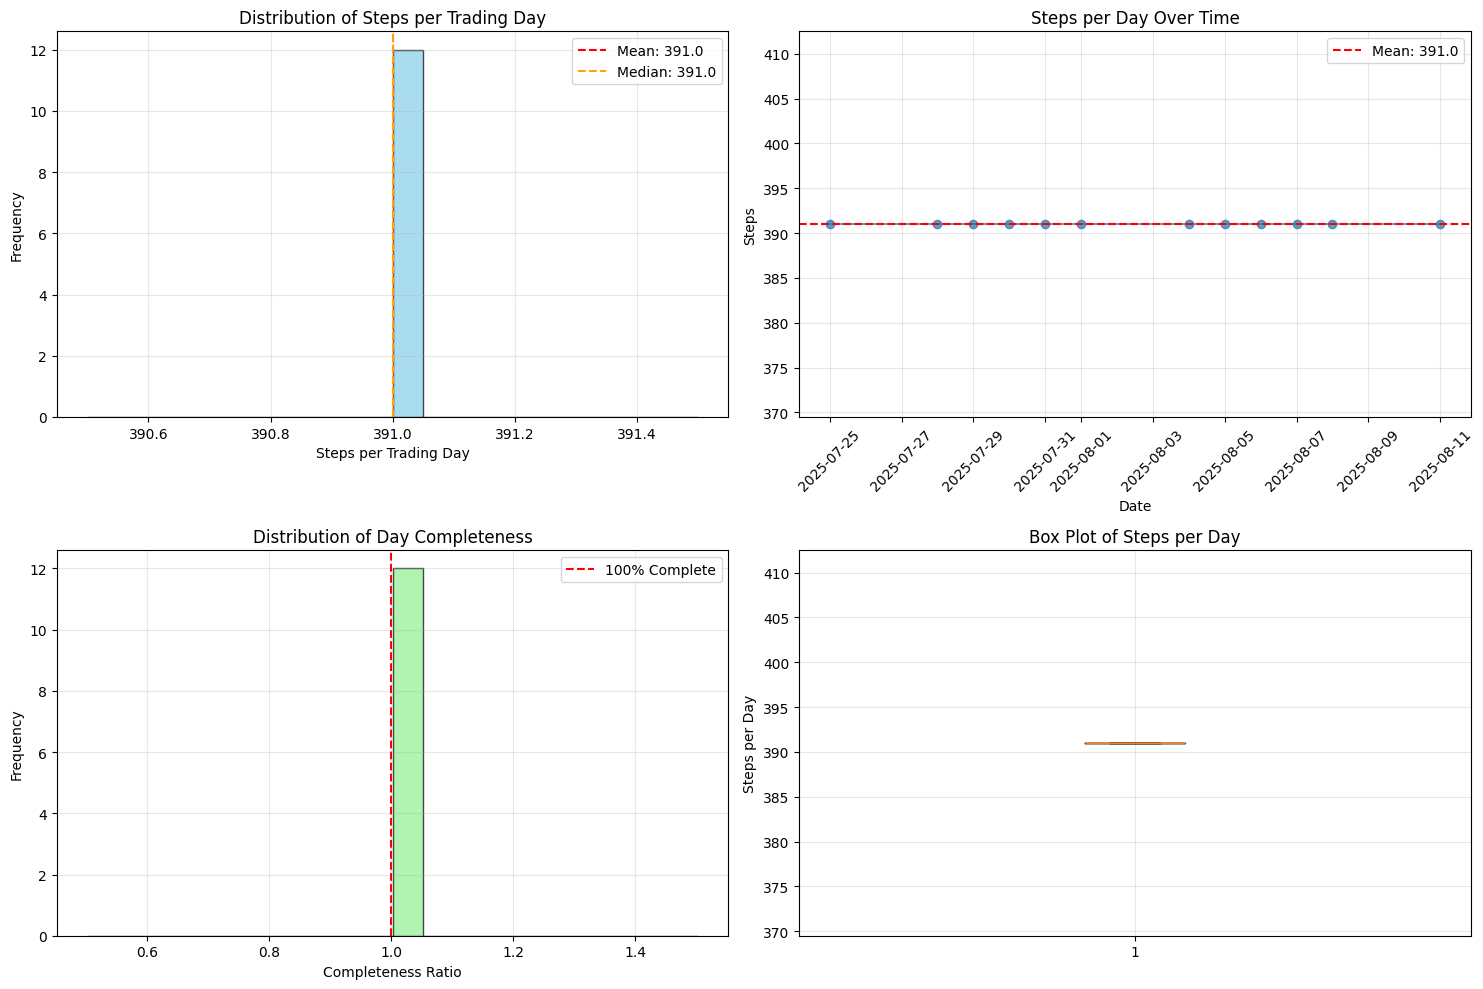


🎯 Recommended episode length: 391 steps
📊 Data ready for RL environment training!

🧠 RL TRAINING ANALYSIS
📊 100.0% of days have ≥300 steps
📊 100.0% of days have ≥350 steps
📊 100.0% of days have ≥380 steps
📊 100.0% of days have ≥390 steps

📈 DATA UTILIZATION:
   • Total trading days: 12
   • With random starts: ~36 possible episodes
   • With sliding windows: ~60 possible episodes

🎯 RECOMMENDED SETTINGS:
   • Episode length: 391 steps
   • Update config.py: FILE = 'cleaned_preprocessed_restructured.csv'
   • Update config.py: EPISODE_LENGTH = 391

🧠 RL TRAINING STRATEGY ANALYSIS
🤔 TRAINING APPROACH OPTIONS:

1️⃣  FIXED DAY START APPROACH:
   ✅ Pros:
      • Consistent episode structure
      • Agent learns market open patterns
      • Easier to debug and reproduce
      • Matches real trading behavior
   ❌ Cons:
      • Less data variety
      • May overfit to market open patterns
      • Limited exploration of mid-day scenarios

2️⃣  RANDOM START POINT APPROACH:
   ✅ Pros:
      • Ma

,Unnamed: 0,date,coin,high,low,open,close,volume,quoteVolume,weightedAverage,open_s,open_s_roll_14,open_s_roll_30,open_s_roll_7,vc,vc_roll_14,vc_roll_30,vc_roll_7,vh,vh_roll_14,vh_roll_30,vh_roll_7,vl,vl_roll_14,vl_roll_30,vl_roll_7,volume_s,volume_s_roll_14,volume_s_roll_30,volume_s_roll_7
0,0,2025-07-25 13:30:00+00:00,AAPL,214.860,214.3400,214.640,214.5100,627507.0,627507.0,214.5100,0.0,0.0,0.0,0.0,0.999394,0.999394,0.999394,0.999394,1.001025,1.001025,1.001025,1.001025,0.998602,0.998602,0.998602,0.998602,0.0,0.0,0.0,0.0
1,1,2025-07-25 13:30:00+00:00,ABBV,191.400,190.7700,191.400,190.8850,63733.0,63733.0,190.8850,0.0,0.0,0.0,0.0,0.997309,0.997309,0.997309,0.997309,1.000000,1.000000,1.000000,1.000000,0.996708,0.996708,0.996708,0.996708,0.0,0.0,0.0,0.0
2,2,2025-07-25 13:30:00+00:00,AEP,109.355,108.7501,109.120,108.7501,47556.0,47556.0,108.7501,0.0,0.0,0.0,0.0,0.996610,0.996610,0.996610,0.996610,1.002154,1.002154,1.002154,1.002154,0.996610,0.996610,0.996610,0.996610,0.0,0.0,0.0,0.0
3,3,2025-07-25 13:30:00+00:00,AMT,230.620,230.3400,230.620,230.3450,11512.0,11512.0,230.3450,0.0,0.0,0.0,0.0,0.998808,0.998808,0.998808,0.998808,1.000000,1.000000,1.000000,1.000000,0.998786,0.998786,0.998786,0.998786,0.0,0.0,0.0,0.0
4,4,2025-07-25 13:30:00+00:00,AMZN,232.310,231.7400,232.140,232.1550,568691.0,568691.0,232.1550,0.0,0.0,0.0,0.0,1.000065,1.000065,1.000065,1.000065,1.000732,1.000732,1.000732,1.000732,0.998277,0.998277,0.998277,0.998277,0.0,0.0,0.0,0.0
5,5,2025-07-25 13:30:00+00:00,APD,297.480,297.0950,297.480,297.0950,6018.0,6018.0,297.0950,0.0,0.0,0.0,0.0,0.998706,0.998706,0.998706,0.998706,1.000000,1.000000,1.000000,1.000000,0.998706,0.998706,0.998706,0.998706,0.0,0.0,0.0,0.0
6,6,2025-07-25 13:30:00+00:00,BA,232.030,229.6701,232.020,229.6701,116918.0,116918.0,229.6701,0.0,0.0,0.0,0.0,0.989872,0.989872,0.989872,0.989872,1.000043,1.000043,1.000043,1.000043,0.989872,0.989872,0.989872,0.989872,0.0,0.0,0.0,0.0
7,7,2025-07-25 13:30:00+00:00,BAC,48.395,48.2700,48.390,48.2800,286355.0,286355.0,48.2800,0.0,0.0,0.0,0.0,0.997727,0.997727,0.997727,0.997727,1.000103,1.000103,1.000103,1.000103,0.997520,0.997520,0.997520,0.997520,0.0,0.0,0.0,0.0
8,8,2025-07-25 13:30:00+00:00,BOIL,37.630,37.4000,37.400,37.5800,26399.0,26399.0,37.5800,0.0,0.0,0.0,0.0,1.004813,1.004813,1.004813,1.004813,1.006150,1.006150,1.006150,1.006150,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0
9,9,2025-07-25 13:30:00+00:00,C,95.480,95.1500,95.390,95.1610,157194.0,157194.0,95.1610,0.0,0.0,0.0,0.0,0.997599,0.997599,0.997599,0.997599,1.000943,1.000943,1.000943,1.000943,0.997484,0.997484,0.997484,0.997484,0.0,0.0,0.0,0.0


In [16]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from math import ceil, floor 
import pandas as pd
import pandas_ta as pdta
import config
import time
import schedule
from datetime import datetime
from datetime import date
from datetime import timedelta
import numpy as np
import statsmodels.api as sm
import scipy as sp
from scipy.stats import theilslopes , linregress
from scipy.ndimage import gaussian_filter1d , generic_filter1d
import scipy.signal as signal
import scipy.interpolate as si
from scipy.signal import find_peaks
from scipy import stats
import pywt
import mplcursors
import pickle
import ta as ta
import pytz
import datetime
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.requests import MarketOrderRequest ,LimitOrderRequest, ClosePositionRequest
from alpaca.data.requests import StockLatestQuoteRequest, CryptoLatestQuoteRequest
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
from IPython.display import display, clear_output
from alpaca.data.requests import CryptoBarsRequest, StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import pandas_ta as pdta
import config
import os
from alpaca.trading.requests import GetOrdersRequest
from alpaca.trading.enums import OrderSide,OrderClass,OrderType, QueryOrderStatus, OrderStatus
from sklearn.preprocessing import MinMaxScaler

# Initialize Alpaca clients
count = 0
alt_pkl_file_path = 0
if alt_pkl_file_path == 0:
    trading_client = TradingClient(config.alpaca_paper_api_key, config.alpaca_paper_secret_key, paper=True)
    stock_client = StockHistoricalDataClient(config.alpaca_paper_api_key, config.alpaca_paper_secret_key)
    api = REST(config.alpaca_paper_api_key, config.alpaca_paper_secret_key, base_url=config.alpaca_paper_endpoint)
elif alt_pkl_file_path == 1:
    trading_client = TradingClient(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key, paper=True)
    stock_client = StockHistoricalDataClient(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key)
    api = REST(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key, base_url=config.alpaca_paper_counter_endpoint)
elif alt_pkl_file_path == 2:
    trading_client = TradingClient(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key, paper=True)
    stock_client = StockHistoricalDataClient(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key)
    api = REST(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key, base_url=config.alpaca_paper_mega_endpoint)

account = trading_client.get_account()
print(account)

# Trading parameters
time_sensev = 0.50
time_incriment = 1
time_incriment5 = 10
symbol = tickers_L  # Your ticker list

print('time_incriment: ', time_incriment)
print('count: ', count)

# Market calendar setup
calendar = api.get_calendar()
now = datetime.datetime.utcnow()
today = datetime.datetime.today().date()

# Find the last trading day
last_trading_day = None
for day in reversed(calendar):
    if pd.Timestamp(day.date).date() < today:
        last_trading_day = pd.Timestamp(day.date, hour=12, tz='UTC')
        break

# Current time
now = datetime.datetime.now(pytz.UTC)
hours_since_last_noon = int((now - last_trading_day).total_seconds() / 3600) - 16

print(last_trading_day)
print(hours_since_last_noon)

# Lookback time logic
# Define market hours in EST (pytz handles DST automatically)
est_tz = pytz.timezone('US/Eastern')
utc_tz = pytz.UTC

# Market hours in EST
MARKET_OPEN_EST = datetime.time(9, 30)   # 9:30 AM EST
MARKET_CLOSE_EST = datetime.time(16, 0)  # 4:00 PM EST

def est_to_utc(est_time, date):
    """Convert EST time to UTC for a specific date (handles DST automatically)"""
    # Create a datetime in EST for the given date and time
    est_dt = est_tz.localize(datetime.datetime.combine(date, est_time))
    # Convert to UTC
    utc_dt = est_dt.astimezone(utc_tz)
    return utc_dt.time()

def get_market_hours_utc(date):
    """Get market open/close times in UTC for a specific date"""
    open_utc = est_to_utc(MARKET_OPEN_EST, date)
    close_utc = est_to_utc(MARKET_CLOSE_EST, date)
    return open_utc, close_utc

def get_market_datetime_utc(date):
    """Get market open/close datetime objects in UTC for a specific date (handles DST automatically)"""
    try:
        # Create a datetime in EST for the given date and time
        est_dt_open = est_tz.localize(datetime.datetime.combine(date, MARKET_OPEN_EST))
        est_dt_close = est_tz.localize(datetime.datetime.combine(date, MARKET_CLOSE_EST))
        
        # Convert to UTC
        utc_dt_open = est_dt_open.astimezone(utc_tz)
        utc_dt_close = est_dt_close.astimezone(utc_tz)
        
        return utc_dt_open, utc_dt_close
    except Exception as e:
        print(f"⚠️ Error converting timezone for {date}: {e}")
        # Fallback to hardcoded values (should not happen with proper DST handling)
        # utc_open = datetime.datetime.combine(date, datetime.time(13, 30)).replace(tzinfo=utc_tz)
        # utc_close = datetime.datetime.combine(date, datetime.time(20, 0)).replace(tzinfo=utc_tz)
        # return utc_open, utc_close


def get_recent_trading_days(calendar, n_days: int, offset_blocks: int = 0) -> list:
    """Return the last n_days trading dates, optionally offset by blocks of n_days.

    - calendar: Alpaca market calendar previously fetched
    - n_days: number of trading days to return per block
    - offset_blocks: 0 returns the most recent block, 1 returns the previous block of n_days, etc.
    """
    today = datetime.datetime.today().date()
    trading_days_all = [pd.Timestamp(day.date).date() for day in calendar if pd.Timestamp(day.date).date() < today]
    trading_days_all.sort()

    end_index = len(trading_days_all) - (offset_blocks * n_days)
    start_index = max(0, end_index - n_days)
    return trading_days_all[start_index:end_index]

look_back_days = 0
look_back_days_vertiacl = 0

# Limited to 100 so if past trading day 99 for getting 9:30 to 16:00 start end
# Data collection with market hours filter
# ✅ FIXED: Data collection with proper timezone handling for blocks of trading days
all_df_open = []
DAYS_PER_BLOCK = 6
for i in range(1, 3, 1):
    print(f"\n{'='*60}")
    print(f"Processing iteration {i} (block of {DAYS_PER_BLOCK} trading days)")
    print(f"{'='*60}")

    # Get the i-th most recent block of DAYS_PER_BLOCK trading days
    trading_days = get_recent_trading_days(calendar, n_days=DAYS_PER_BLOCK, offset_blocks=i-1)
    print(f"Trading days in block {i}: {trading_days}")

    for historical_date in trading_days:
        # ✅ FIXED: Get market hours for THIS SPECIFIC DATE (handles DST properly)
        utc_dt_open, utc_dt_close = get_market_datetime_utc(historical_date)

        print(f"Market hours for {historical_date}:")
        print(f"  EST: {MARKET_OPEN_EST} - {MARKET_CLOSE_EST}")
        print(f"  UTC: {utc_dt_open.time()} - {utc_dt_close.time()}")
        print(f"  UTC datetime: {utc_dt_open} - {utc_dt_close}")

        # ✅ Use proper UTC times for data request
        Histoic_start = utc_dt_open
        end_time = utc_dt_close
        print(f"Data request range: {Histoic_start} to {end_time}")

        request_params = StockBarsRequest(
            symbol_or_symbols=symbol,
            start=Histoic_start,
            end=end_time,
            timeframe=TimeFrame(time_incriment, TimeFrameUnit.Minute)
        )

        try:
            historic = stock_client.get_stock_bars(request_params)
            historic = historic.df
            historic = historic.bfill()
            historic.reset_index(inplace=True)
            historic['timestamp'] = pd.to_datetime(historic['timestamp'], unit='ms', utc=True)
            historic = historic.set_index('timestamp')

            historic = historic.drop_duplicates(keep='last')
            historic = historic.pivot(columns='symbol', values=historic.columns)

            # ✅ Filter for market hours using the correct UTC times for this date
            is_open = (historic.index >= utc_dt_open) & (historic.index <= utc_dt_close)
            df_open = historic[is_open]

            print(f"📊 Data points for {historical_date}: {len(df_open)}")
            if len(df_open) > 0:
                print(f"   First timestamp: {df_open.index.min()}")
                print(f"   Last timestamp: {df_open.index.max()}")
                expected_minutes = (utc_dt_close - utc_dt_open).total_seconds() / 60
                print(f"   Expected minutes: {expected_minutes:.0f}")
                print(f"   Actual minutes: {len(df_open)}")
                print(f"   Completeness: {(len(df_open) / expected_minutes):.1%}")
            else:
                print(f"⚠️ No data found for {historical_date}")

            all_df_open.append(df_open)

        except Exception as e:
            print(f"❌ Error fetching data for {historical_date}: {e}")
            continue

# Combine all data
df_multiday = pd.concat(all_df_open)
df_multiday.sort_index(inplace=True)

# ✅ CRITICAL FIX: Remove duplicates after concatenation
print(f"📊 Before deduplication: {df_multiday.shape}")
df_multiday = df_multiday[~df_multiday.index.duplicated(keep='last')]
print(f"📊 After deduplication: {df_multiday.shape}")

# ✅ FIXED: Restructure to match cleaned_preprocessed.csv format with robust feature creation
def restructure_to_environment_format(df_multiday):
    """
    Restructure the multi-index data to match the environment's expected format
    where coin is a column and date is a column, similar to cleaned_preprocessed.csv
    """
    print("�� Restructuring data to environment format...")
    
    # Reset index to get timestamp as a column
    df_restructured = df_multiday.reset_index()
    df_restructured.rename(columns={'timestamp': 'date'}, inplace=True)
    
    # ✅ FIX: Ensure date column is properly formatted
    df_restructured['date'] = pd.to_datetime(df_restructured['date'])
    
    # Get all the symbol-specific columns
    symbol_cols = []
    for col in df_restructured.columns:
        if col != 'date' and isinstance(col, tuple) and len(col) == 2:
            symbol_cols.append(col)
    
    # Create the melted dataframe
    melted_data = []
    
    for idx, row in df_restructured.iterrows():
        # ✅ CRITICAL FIX: Extract actual datetime value, not Series
        date_val = row['date']
        if hasattr(date_val, 'iloc'):
            # If it's a Series, extract the first value
            date_val = date_val.iloc[0]
        elif hasattr(date_val, 'item'):
            # If it's a numpy scalar, convert to Python datetime
            date_val = date_val.item()
        
        # Get unique symbols from the column names
        symbols = set()
        for col in symbol_cols:
            if isinstance(col, tuple) and len(col) == 2:
                symbols.add(col[1])  # col[1] is the symbol name
        
        # Ensure we have valid symbols
        symbols = [s for s in symbols if s and s.strip()]
        
        # Create a row for each symbol
        for symbol in symbols:
            row_data = {'date': date_val, 'coin': symbol}  # Use 'coin' as column name from the start
            
            # Add all the features for this symbol
            for feature, sym in symbol_cols:
                if sym == symbol:
                    # ✅ FIX: Handle NaN values properly
                    value = row[(feature, sym)]
                    if pd.isna(value):
                        value = 0.0  # Default value for missing data
                    else:
                        # ✅ FIX: Extract scalar value if it's a Series
                        if hasattr(value, 'iloc'):
                            value = value.iloc[0]
                        elif hasattr(value, 'item'):
                            value = value.item()
                    row_data[feature] = value
            
            melted_data.append(row_data)
    
    # Convert to DataFrame
    df_final = pd.DataFrame(melted_data)
    
    # ✅ FIX: Ensure proper data types before sorting
    df_final['date'] = pd.to_datetime(df_final['date'])
    df_final['coin'] = df_final['coin'].astype(str)
    
    # Sort by date and symbol
    df_final = df_final.sort_values(['date', 'coin']).reset_index(drop=True)
    
    # ✅ CRITICAL: Check what columns actually exist in the data
    print("🔍 Analyzing available columns...")
    available_columns = df_final.columns.tolist()
    print(f"Available columns: {available_columns}")
    
    # Define expected base columns (case-insensitive check)
    expected_base_cols = ['high', 'low', 'open', 'close', 'volume', 'quoteVolume', 'weightedAverage']
    available_base_cols = []
    
    for expected_col in expected_base_cols:
        # Check for exact match first
        if expected_col in available_columns:
            available_base_cols.append(expected_col)
            print(f"✅ Found: {expected_col}")
        else:
            # Check for case variations
            found = False
            for col in available_columns:
                if col.lower() == expected_col.lower():
                    available_base_cols.append(col)  # Use the actual column name
                    print(f"✅ Found (case variation): {expected_col} -> {col}")
                    found = True
                    break
            if not found:
                print(f"❌ Missing: {expected_col}")
    
    print(f"\n📊 Available base columns: {available_base_cols}")
    
    # ✅ NORMALIZE: Scale down large values to match crypto scale
    print("\n📊 Normalizing data scale to match crypto data...")
    
    # # Normalize volume to crypto scale (divide by 10000 to get reasonable values)
    # if 'volume' in available_base_cols:
    #     df_final['volume'] = df_final['volume'] / 10000.0
    #     print("✅ Normalized volume (divided by 10000)")
    
    # Normalize prices to crypto scale (divide by 100 to get reasonable values)
    # price_cols = ['high', 'low', 'open', 'close']
    # for col in price_cols:
    #     if col in available_base_cols:
    #         df_final[col] = df_final[col] / 100.0
    #         print(f"✅ Normalized {col} (divided by 100)")
    
    # ✅ EXACT IMPLEMENTATION: Create features EXACTLY like pre_process.py
    print("\n📊 Creating features EXACTLY like pre_process.py...")
    
    # 1. Create volume-based features (vh, vl, vc) - RATIOS like pre_process.py
    if 'high' in available_base_cols and 'open' in available_base_cols:
        df_final["vh"] = df_final["high"] / df_final["open"]  # High/Open ratio
        print("✅ Created: vh (high/open ratio)")
    
    if 'low' in available_base_cols and 'open' in available_base_cols:
        df_final["vl"] = df_final["low"] / df_final["open"]   # Low/Open ratio
        print("✅ Created: vl (low/open ratio)")
    
    if 'close' in available_base_cols and 'open' in available_base_cols:
        df_final["vc"] = df_final["close"] / df_final["open"] # Close/Open ratio
        print("✅ Created: vc (close/open ratio)")
    
    # 2. ✅ FIXED: Create difference features using a safer approach
    print("\nCreating difference features (ABSOLUTE DIFFERENCES like pre_process.py)...")
    
    # ✅ FIXED: Create difference features with proper NaN handling
    print("\nCreating difference features (ABSOLUTE DIFFERENCES like pre_process.py)...")

    # Sort by symbol and date to ensure proper grouping
    df_final = df_final.sort_values(['coin', 'date']).reset_index(drop=True)

    # ✅ FIXED: Use a safer approach for creating difference features
    for coin in df_final['coin'].unique():
        coin_mask = df_final['coin'] == coin
        coin_data = df_final[coin_mask].copy()
        
        # Create difference features for this coin
        if 'open' in available_base_cols:
            differences = coin_data["open"] - coin_data["open"].shift(1)
            # ✅ FIX: Only fill the first NaN, not all NaN values
            differences.iloc[0] = 0.0  # Set first difference to 0 instead of NaN
            df_final.loc[coin_mask, "open_s"] = differences
        
        if 'volume' in available_base_cols:
            differences = coin_data["volume"] - coin_data["volume"].shift(1)
            differences.iloc[0] = 0.0
            df_final.loc[coin_mask, "volume_s"] = differences
        
        if 'quoteVolume' in available_base_cols:
            differences = coin_data["quoteVolume"] - coin_data["quoteVolume"].shift(1)
            differences.iloc[0] = 0.0
            df_final.loc[coin_mask, "quoteVolume_s"] = differences
        
        if 'weightedAverage' in available_base_cols:
            differences = coin_data["weightedAverage"] - coin_data["weightedAverage"].shift(1)
            differences.iloc[0] = 0.0
            df_final.loc[coin_mask, "weightedAverage_s"] = differences

    print("✅ Created difference features (absolute differences)")

    # ✅ FIXED: Create rolling averages with proper NaN handling
    # Build the list of available features for rolling averages
    available_features = []
    if 'vh' in df_final.columns:
        available_features.append('vh')
    if 'vl' in df_final.columns:
        available_features.append('vl')
    if 'vc' in df_final.columns:
        available_features.append('vc')
    if 'open_s' in df_final.columns:
        available_features.append('open_s')
    if 'volume_s' in df_final.columns:
        available_features.append('volume_s')
    if 'quoteVolume_s' in df_final.columns:
        available_features.append('quoteVolume_s')
    if 'weightedAverage_s' in df_final.columns:
        available_features.append('weightedAverage_s')

    ROLLING_WINDOWS = [7, 14, 30]  # Like pre_process.py

    print(f"\nCreating rolling averages for available features: {available_features}")

    # ✅ FIXED: Use a safer approach for rolling averages
    for coin in df_final['coin'].unique():
        coin_mask = df_final['coin'] == coin
        coin_data = df_final[coin_mask].copy()
        
        for col in available_features:
            for window in ROLLING_WINDOWS:
                # Calculate rolling average for this coin and feature
                rolling_avg = coin_data[col].rolling(window=window, min_periods=1).mean()
                # ✅ FIX: Use bfill() like in pre_process.py instead of fillna(0)
                rolling_avg = rolling_avg.bfill()
                df_final.loc[coin_mask, f"{col}_roll_{window}"] = rolling_avg

    # ✅ FIX: Only fill remaining NaN values, not all zeros
    df_final = df_final.fillna(method='bfill')#.fillna(0)
    
    # ✅ CRITICAL FIX: Ensure we only have 'coin' column, not 'symbol'
    if 'symbol' in df_final.columns:
        # If we have both 'coin' and 'symbol', drop 'symbol' and ensure 'coin' has the right values
        if 'coin' in df_final.columns:
            # Check if 'coin' column is empty and 'symbol' has values
            if df_final['coin'].isna().all() or df_final['coin'].eq('').all():
                df_final['coin'] = df_final['symbol']
            df_final = df_final.drop(columns=['symbol'])
        else:
            # If only 'symbol' exists, rename it to 'coin'
            df_final = df_final.rename(columns={'symbol': 'coin'})
    
    # ✅ CRITICAL FIX: Ensure we have the exact same columns as cleaned_preprocessed.csv
    # Remove any extra columns that shouldn't be there
    expected_columns = ['date', 'coin', 'high', 'low', 'open', 'close', 'volume', 'quoteVolume', 'weightedAverage']
    extra_columns_to_remove = []
    
    for col in df_final.columns:
        if col not in expected_columns and not col.startswith(('vh', 'vl', 'vc', 'open_s', 'volume_s', 'quoteVolume_s', 'weightedAverage_s')) and not col.endswith(('_roll_7', '_roll_14', '_roll_30')):
            extra_columns_to_remove.append(col)
    
    if extra_columns_to_remove:
        print(f"🗑️ Removing extra columns: {extra_columns_to_remove}")
        df_final = df_final.drop(columns=extra_columns_to_remove)
    
    # ✅ CRITICAL FIX: Ensure we have all required columns, create missing ones with default values
    if 'quoteVolume' not in df_final.columns:
        print("⚠️ Creating missing 'quoteVolume' column with default values")
        df_final['quoteVolume'] = df_final['volume']  # Use volume as default
    
    if 'weightedAverage' not in df_final.columns:
        print("⚠️ Creating missing 'weightedAverage' column with default values")
        df_final['weightedAverage'] = df_final['close']  # Use close as default
    
    # ✅ CRITICAL FIX: Reorder columns to match cleaned_preprocessed.csv exactly
    # First, get all the base columns in the right order
    base_columns = ['date', 'coin', 'high', 'low', 'open', 'close', 'volume', 'quoteVolume', 'weightedAverage']
    
    # Then get all the derived columns (vh, vl, vc, *_s, *_roll_*)
    derived_columns = [col for col in df_final.columns if col not in base_columns]
    
    # Sort derived columns to match the order in cleaned_preprocessed.csv
    derived_columns.sort()
    
    # Combine in the right order
    final_column_order = base_columns + derived_columns
    
    # Reorder the dataframe
    df_final = df_final[final_column_order]
    
    # ✅ CRITICAL FIX: Remove any duplicate coin/date combinations
    print(f"📊 Before coin/date deduplication: {df_final.shape}")
    df_final = df_final.drop_duplicates(subset=['date', 'coin'], keep='last')
    print(f"📊 After coin/date deduplication: {df_final.shape}")
    
    # Sort back by date and coin for consistency
    df_final = df_final.sort_values(['date', 'coin']).reset_index(drop=True)
    
    print(f"\n✅ Restructured data shape: {df_final.shape}")
    print(f"📅 Date range: {df_final['date'].min()} to {df_final['date'].max()}")
    print(f"�� Coins: {df_final['coin'].unique()}")
    
    # Verify we have all required features
    all_created_features = available_features.copy()
    for col in available_features:
        for window in ROLLING_WINDOWS:
            all_created_features.append(f"{col}_roll_{window}")
    
    missing_features = [f for f in all_created_features if f not in df_final.columns]
    if missing_features:
        print(f"⚠️ Missing features: {missing_features}")
    else:
        print(f"✅ All {len(all_created_features)} required features created!")
    
    print(f"\n📊 Final feature count: {len(all_created_features)} features per coin")
    print(f"📊 Total features: {len(all_created_features) * len(df_final['coin'].unique())}")
    
    print(f"\n�� Sample data:")
    print(df_final.head(10))
    
    return df_final

# Restructure the data
df_environment_format = restructure_to_environment_format(df_multiday)

# Save the restructured data
df_environment_format.to_csv("cleaned_preprocessed_restructured.csv", index=True)
print("�� Saved restructured data to 'cleaned_preprocessed_restructured.csv'")

# ✅ FIXED: Proper episode length calculation
print("\n🔍 DEBUGGING DATA STRUCTURE:")
print(f"Original df_multiday shape: {df_multiday.shape}")
print(f"Restructured data shape: {df_environment_format.shape}")
print(f"Unique dates: {df_environment_format['date'].nunique()}")
print(f"Unique coins: {df_environment_format['coin'].nunique()}")
print(f"Rows per coin per day: {df_environment_format.shape[0] / (df_environment_format['date'].nunique() * df_environment_format['coin'].nunique()):.1f}")

# Analyze trading day structure
print("\n📈 Analyzing trading day structure...")

# Ensure only 'symbol' is present (drop 'coin' if it slipped in earlier)
if 'coin' in df_environment_format.columns and 'coin' in df_environment_format.columns:
    df_environment_format = df_environment_format.drop(columns=['coin'])

# Steps per day should be the count of unique minute timestamps in [13:30, 20:00] per day,
# not multiplied by number of symbols. Count unique minutes per day.
df_environment_format['day'] = df_environment_format['date'].dt.date
df_environment_format['minute'] = df_environment_format['date'].dt.floor('min')

# Count unique minutes per day (deduplicate across symbols)
daily_counts = (
    df_environment_format[['day', 'minute']]
    .drop_duplicates()
    .groupby('day')
    .size()
)

print(f"📊 Trading days analyzed: {len(daily_counts)}")
print(f"📊 Average steps per day: {daily_counts.mean():.1f}")
print(f"📊 Median steps per day: {daily_counts.median():.1f}")
print(f"�� Min steps per day: {daily_counts.min()}")
print(f"�� Max steps per day: {daily_counts.max()}")
print(f"�� Standard deviation: {daily_counts.std():.1f}")

# Calculate expected steps based on time increment
# From your code: time_incriment = 1 (1-minute intervals)
expected_minutes = (datetime.datetime.combine(datetime.datetime.min, datetime.time(20, 0)) - 
                  datetime.datetime.combine(datetime.datetime.min, datetime.time(13, 30))).total_seconds() / 60
expected_steps = int(expected_minutes)  # Should be ~390 minutes (6.5 hours)

print(f"\n�� Expected steps per day (13:30-20:00): {expected_steps}")
print(f"📊 Average completeness: {(daily_counts.mean() / expected_steps):.1%}")

# Identify incomplete days
incomplete_days = daily_counts[daily_counts < 0.95 * expected_steps]
if len(incomplete_days) > 0:
    print(f"\n⚠️  Incomplete trading days (<95% complete): {len(incomplete_days)}")
    print("   These days may have missing data or early market closes")
    for day, steps in incomplete_days.head(5).items():
        completeness = steps / expected_steps
        print(f"   {day}: {steps}/{expected_steps} steps ({completeness:.1%})")

# Enhanced visualization
plt.figure(figsize=(15, 10))

# Plot 1: Steps per day distribution
plt.subplot(2, 2, 1)
plt.hist(daily_counts.values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(daily_counts.mean(), color='red', linestyle='--', label=f'Mean: {daily_counts.mean():.1f}')
plt.axvline(daily_counts.median(), color='orange', linestyle='--', label=f'Median: {daily_counts.median():.1f}')
plt.xlabel('Steps per Trading Day')
plt.ylabel('Frequency')
plt.title('Distribution of Steps per Trading Day')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Steps over time
plt.subplot(2, 2, 2)
plt.plot(daily_counts.index, daily_counts.values, marker='o', alpha=0.7)
plt.axhline(daily_counts.mean(), color='red', linestyle='--', label=f'Mean: {daily_counts.mean():.1f}')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.title('Steps per Day Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Completeness distribution
completeness_ratios = daily_counts / expected_steps
plt.subplot(2, 2, 3)
plt.hist(completeness_ratios, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
plt.axvline(1.0, color='red', linestyle='--', label='100% Complete')
plt.xlabel('Completeness Ratio')
plt.ylabel('Frequency')
plt.title('Distribution of Day Completeness')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Box plot of steps
plt.subplot(2, 2, 4)
plt.boxplot(daily_counts.values)
plt.ylabel('Steps per Day')
plt.title('Box Plot of Steps per Day')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎯 Recommended episode length: {min(391, int(round(daily_counts.median())))} steps")
print(f"📊 Data ready for RL environment training!")

# Enhanced RL training analysis
print("\n" + "="*60)
print("🧠 RL TRAINING ANALYSIS")
print("="*60)

# Calculate what percentage of days meet different thresholds
for threshold in [300, 350, 380, 390]:
    pct_above = (daily_counts >= threshold).mean() * 100
    print(f"📊 {pct_above:.1f}% of days have ≥{threshold} steps")

print(f"\n📈 DATA UTILIZATION:")
total_trading_days = len(daily_counts)
print(f"   • Total trading days: {total_trading_days}")
print(f"   • With random starts: ~{total_trading_days * 3} possible episodes")
print(f"   • With sliding windows: ~{total_trading_days * 5} possible episodes")

print(f"\n🎯 RECOMMENDED SETTINGS:")
print(f"   • Episode length: {daily_counts.median():.0f} steps")
print(f"   • Update config.py: FILE = 'cleaned_preprocessed_restructured.csv'")
print(f"   • Update config.py: EPISODE_LENGTH = {daily_counts.median():.0f}")

# Additional RL training strategy analysis
print("\n" + "="*60)
print("🧠 RL TRAINING STRATEGY ANALYSIS")
print("="*60)

avg_steps = daily_counts.mean()
median_steps = daily_counts.median()

print("🤔 TRAINING APPROACH OPTIONS:")
print("\n1️⃣  FIXED DAY START APPROACH:")
print("   ✅ Pros:")
print("      • Consistent episode structure")
print("      • Agent learns market open patterns")
print("      • Easier to debug and reproduce")
print("      • Matches real trading behavior")
print("   ❌ Cons:")
print("      • Less data variety")
print("      • May overfit to market open patterns")
print("      • Limited exploration of mid-day scenarios")

print("\n2️⃣  RANDOM START POINT APPROACH:")
print("   ✅ Pros:")
print("      • Maximum data utilization")
print("      • Better exploration of different market conditions")
print("      • More diverse training scenarios")
print("      • Higher sample efficiency")
print("   ❌ Cons:")
print("      • Inconsistent episode lengths")
print("      • May learn unrealistic transitions")
print("      • Harder to interpret behavior")

print("\n3️⃣  HYBRID APPROACH (RECOMMENDED):")
print("   ✅ Best of both worlds:")
print("      • Use average day length as episode length")
print("      • Allow random start points within valid ranges")
print("      • Ensure minimum episode length for learning")
print("      • Add day boundary awareness")

print(f"\n�� SPECIFIC RECOMMENDATIONS:")
print(f"   • Episode length: {median_steps:.0f} steps (median)")
print(f"   • Minimum episode length: {daily_counts.quantile(0.1):.0f} steps (10th percentile)")
print(f"   • Maximum episode length: {daily_counts.quantile(0.9):.0f} steps (90th percentile)")

df_multiday = pd.read_csv('cleaned_preprocessed_restructured.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_multiday.shape)

df_multiday.head(30)


⚠️

📅 Total data range:

1
look_back_days: 100


Histoic_start: 2025-05-03 09:30:00
end_time: 2025-08-11 18:53:48.884589


2
look_back_days: 200


Histoic_start: 2025-01-23 09:30:00
end_time: 2025-05-03 18:55:01.822616

Loading data...
Data shape: (450432, 30)

DATA STRUCTURE ANALYSIS

1. BASIC DATASET INFO:
Total rows: 450432
Total columns: 30
Memory usage: 150.41 MB

2. COLUMN NAMES:
 0: Unnamed: 0
 1: date
 2: coin
 3: high
 4: low
 5: open
 6: close
 7: volume
 8: quoteVolume
 9: weightedAverage
10: open_s
11: open_s_roll_14
12: open_s_roll_30
13: open_s_roll_7
14: vc
15: vc_roll_14
16: vc_roll_30
17: vc_roll_7
18: vh
19: vh_roll_14
20: vh_roll_30
21: vh_roll_7
22: vl
23: vl_roll_14
24: vl_roll_30
25: vl_roll_7
26: volume_s
27: volume_s_roll_14
28: volume_s_roll_30
29: volume_s_roll_7

3. DATA TYPES:
Unnamed: 0            int64
date                 object
coin                 object
high                float64
low                 float64
open                float64
close               float64
volume              float64
quoteVolume         float64
weightedAverage     float64
open_s              float64
open_s_roll_14      float64
open_s_roll_30      float64
open_s_roll_7       float64
vc          

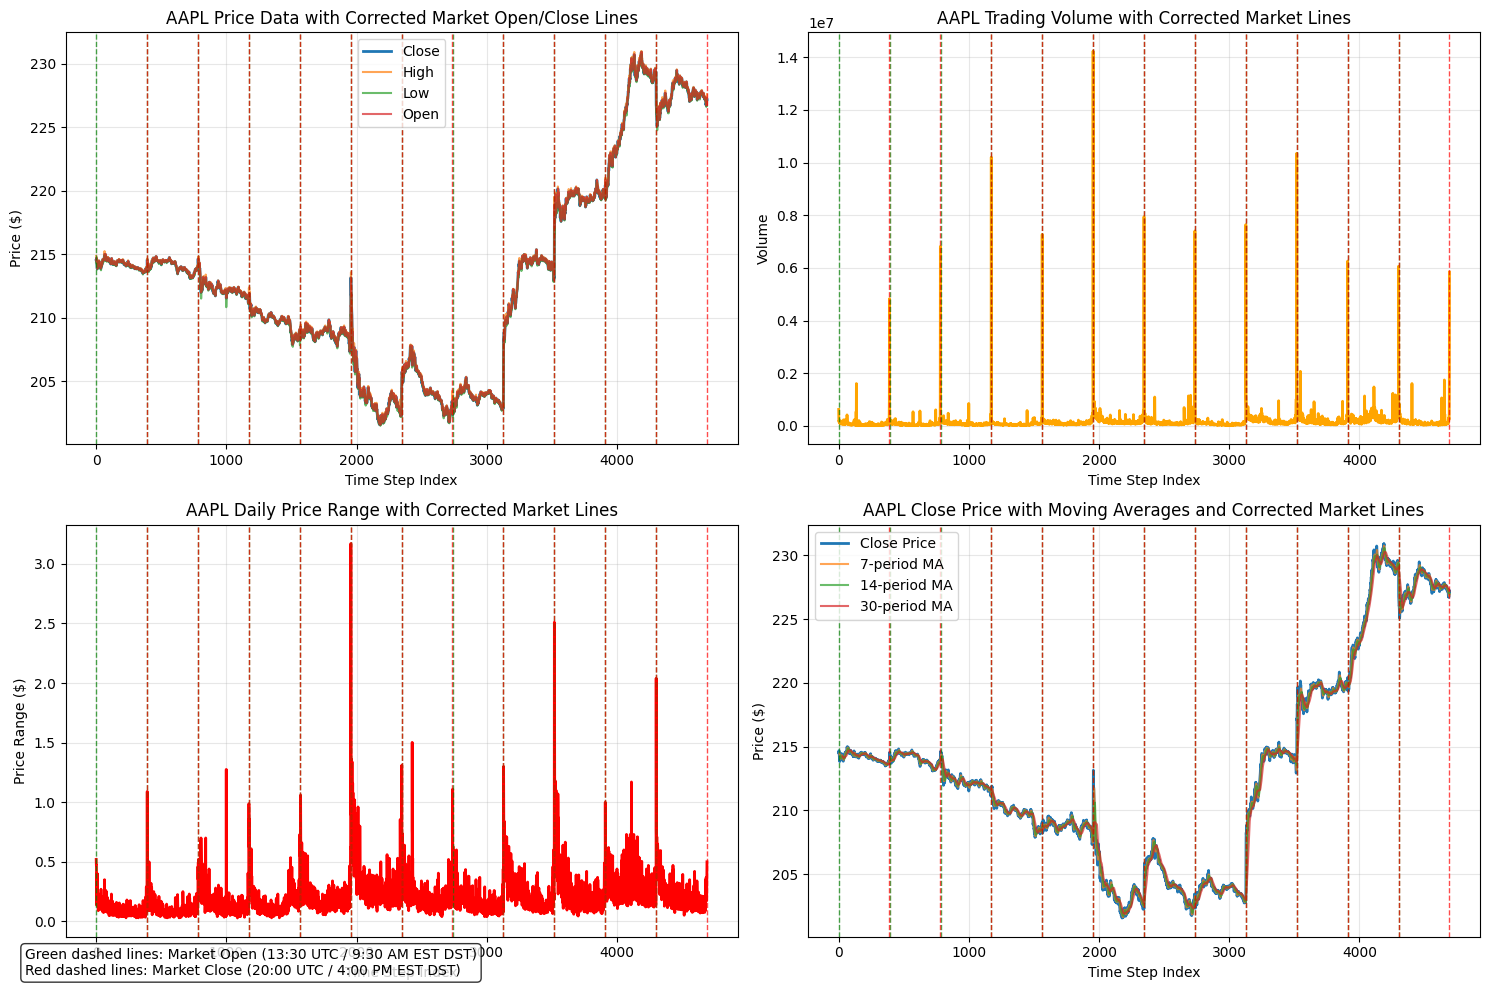

✓ AAPL plots with CORRECTED market lines created and saved as 'aapl_analysis_plot_corrected_market_lines.png'

AAPL TRADING INSIGHTS:
Total trading sessions: 4692
Average daily volume: 160,982
Average daily price range: $0.20
Price volatility (std of close): $7.83

AAPL PRICE STATISTICS:
Starting price: $214.51
Ending price: $227.18
Total return: 5.91%
Maximum price: $231.00
Minimum price: $201.50

CORRECTED MARKET HOURS ANALYSIS:
Market open time: 13:30 UTC (9:30 AM EST during DST)
Market close time: 20:00 UTC (4:00 PM EST during DST)
Number of trading days with market lines: 12

CORRECTED MARKET LINE POSITIONS:
  Day 1: Open at index 0 (2025-07-25 13:30:00+00:00) | Close at index 390 (2025-07-25 20:00:00+00:00)
  Day 2: Open at index 391 (2025-07-28 13:30:00+00:00) | Close at index 781 (2025-07-28 20:00:00+00:00)
  Day 3: Open at index 782 (2025-07-29 13:30:00+00:00) | Close at index 1172 (2025-07-29 20:00:00+00:00)
  Day 4: Open at index 1173 (2025-07-30 13:30:00+00:00) | Close at i

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime 

# Load the data
print("Loading data...")
df_multiday = pd.read_csv('cleaned_preprocessed_restructured.csv')
print(f"Data shape: {df_multiday.shape}")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("\n" + "="*50)
print("DATA STRUCTURE ANALYSIS")
print("="*50)

# 1. Basic info about the dataset
print("\n1. BASIC DATASET INFO:")
print(f"Total rows: {len(df_multiday)}")
print(f"Total columns: {len(df_multiday.columns)}")
print(f"Memory usage: {df_multiday.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 2. Column information
print("\n2. COLUMN NAMES:")
for i, col in enumerate(df_multiday.columns):
    print(f"{i:2d}: {col}")

# 3. Data types
print("\n3. DATA TYPES:")
print(df_multiday.dtypes)

# 4. Check for missing values
print("\n4. MISSING VALUES:")
missing_values = df_multiday.isnull().sum()
print(missing_values[missing_values > 0])

# 5. Unique coins and their counts
print("\n5. UNIQUE COINS AND COUNTS:")
coin_counts = df_multiday['coin'].value_counts()
print(f"Total unique coins: {len(coin_counts)}")
print("\nTop 10 coins by frequency:")
print(coin_counts.head(10))

# 6. Time range analysis
print("\n6. TIME RANGE ANALYSIS:")
df_multiday['date'] = pd.to_datetime(df_multiday['date'])
print(f"Date range: {df_multiday['date'].min()} to {df_multiday['date'].max()}")
print(f"Total unique timestamps: {df_multiday['date'].nunique()}")

# 7. AAPL specific analysis
print("\n7. AAPL SPECIFIC ANALYSIS:")
aapl_data = df_multiday[df_multiday['coin'] == 'AAPL'].copy()
print(f"AAPL data shape: {aapl_data.shape}")
print(f"AAPL unique timestamps: {aapl_data['date'].nunique()}")

if len(aapl_data) > 0:
    print(f"AAPL date range: {aapl_data['date'].min()} to {aapl_data['date'].max()}")
    print(f"AAPL price range - High: {aapl_data['high'].min():.2f} to {aapl_data['high'].max():.2f}")
    print(f"AAPL price range - Low: {aapl_data['low'].min():.2f} to {aapl_data['low'].max():.2f}")
    print(f"AAPL price range - Close: {aapl_data['close'].min():.2f} to {aapl_data['close'].max():.2f}")
    
    # Check if we have time series data or just snapshots
    aapl_data_sorted = aapl_data.sort_values('date')
    print(f"\nFirst 5 AAPL records:")
    print(aapl_data_sorted[['date', 'coin', 'open', 'high', 'low', 'close', 'volume']].head())
    
    print(f"\nLast 5 AAPL records:")
    print(aapl_data_sorted[['date', 'coin', 'open', 'high', 'low', 'close', 'volume']].tail())

# 8. Sample data structure
print("\n8. SAMPLE DATA STRUCTURE:")
print("First 3 rows of the dataset:")
print(df_multiday.head(3))

# 9. Check for time series structure
print("\n9. TIME SERIES STRUCTURE ANALYSIS:")
# Group by date and count coins per timestamp
coins_per_timestamp = df_multiday.groupby('date')['coin'].count()
print(f"Coins per timestamp - Min: {coins_per_timestamp.min()}, Max: {coins_per_timestamp.max()}")
print(f"Average coins per timestamp: {coins_per_timestamp.mean():.2f}")

# Check if all timestamps have the same number of coins
if coins_per_timestamp.nunique() == 1:
    print("✓ All timestamps have the same number of coins - good for time series analysis")
else:
    print("⚠ Timestamps have varying numbers of coins - may need special handling")

print("\n" + "="*50)
print("PLOTTING AAPL DATA WITH CORRECTED MARKET OPEN/CLOSE LINES")
print("="*50)

# Plot AAPL data using index instead of date with CORRECTED market lines
if len(aapl_data) > 0:
    # Sort by date and reset index to get sequential numbering
    aapl_data_sorted = aapl_data.sort_values('date').reset_index(drop=True)
    
    # Add time components for market line detection
    aapl_data_sorted['hour'] = aapl_data_sorted['date'].dt.hour
    aapl_data_sorted['minute'] = aapl_data_sorted['date'].dt.minute
    aapl_data_sorted['time_decimal'] = aapl_data_sorted['hour'] + aapl_data_sorted['minute'] / 60.0
    
    # ✅ SIMPLE: Automatic market hours detection with pytz
    import pytz

    # Define market hours in EST (pytz handles DST automatically)
    est_tz = pytz.timezone('US/Eastern')
    utc_tz = pytz.UTC

    # Market hours in EST
    MARKET_OPEN_EST = datetime.time(9, 30)   # 9:30 AM EST
    MARKET_CLOSE_EST = datetime.time(16, 0)  # 4:00 PM EST

    def est_to_utc(est_time, date):
        """Convert EST time to UTC for a specific date (handles DST automatically)"""
        # Create a datetime in EST for the given date and time
        est_dt = est_tz.localize(datetime.datetime.combine(date, est_time))
        # Convert to UTC
        utc_dt = est_dt.astimezone(utc_tz)
        return utc_dt.time()

    def get_market_hours_for_date(date):
        """Get market hours in UTC for any date"""
        open_utc = est_to_utc(MARKET_OPEN_EST, date)
        close_utc = est_to_utc(MARKET_CLOSE_EST, date)
        return open_utc, close_utc

    # Find market open/close indices for each trading day
    market_open_indices = []
    market_close_indices = []

    # Group by date to find market open/close for each trading day
    for date, day_data in aapl_data_sorted.groupby(aapl_data_sorted['date'].dt.date):
        # Get market hours for this specific date
        market_open_utc, market_close_utc = get_market_hours_for_date(date)
        
        # Convert to decimal for comparison
        market_open_decimal = market_open_utc.hour + market_open_utc.minute / 60.0
        market_close_decimal = market_close_utc.hour + market_close_utc.minute / 60.0
        
        print(f"Date {date}: EST {MARKET_OPEN_EST}-{MARKET_CLOSE_EST} → UTC {market_open_utc}-{market_close_utc}")
        
        # Find market open/close indices
        open_mask = day_data['time_decimal'] >= market_open_decimal
        close_mask = day_data['time_decimal'] <= market_close_decimal
        
        if open_mask.any():
            market_open_idx = day_data[open_mask].index[0]
            market_open_indices.append(market_open_idx)
        
        if close_mask.any():
            market_close_idx = day_data[close_mask].index[-1]
            market_close_indices.append(market_close_idx)
        else:
            # If no close data, use the last record of the day
            market_close_idx = day_data.index[-1]
            market_close_indices.append(market_close_idx)
        
    print(f"Found {len(market_open_indices)} market open lines")
    print(f"Found {len(market_close_indices)} market close lines")
    
    # Create the plot
    plt.figure(figsize=(15, 10))
    
    # Subplot 1: Price data with market lines
    plt.subplot(2, 2, 1)
    plt.plot(aapl_data_sorted.index, aapl_data_sorted['close'], label='Close', linewidth=2)
    plt.plot(aapl_data_sorted.index, aapl_data_sorted['high'], label='High', alpha=0.7)
    plt.plot(aapl_data_sorted.index, aapl_data_sorted['low'], label='Low', alpha=0.7)
    plt.plot(aapl_data_sorted.index, aapl_data_sorted['open'], label='Open', alpha=0.7)
    
    # Add market open lines (green)
    for idx in market_open_indices:
        plt.axvline(x=idx, color='green', linestyle='--', alpha=0.7, linewidth=1)
    
    # Add market close lines (red)
    for idx in market_close_indices:
        plt.axvline(x=idx, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.title('AAPL Price Data with Corrected Market Open/Close Lines')
    plt.xlabel('Time Step Index')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Volume with market lines
    plt.subplot(2, 2, 2)
    plt.plot(aapl_data_sorted.index, aapl_data_sorted['volume'], color='orange', linewidth=2)
    
    # Add market open lines (green)
    for idx in market_open_indices:
        plt.axvline(x=idx, color='green', linestyle='--', alpha=0.7, linewidth=1)
    
    # Add market close lines (red)
    for idx in market_close_indices:
        plt.axvline(x=idx, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.title('AAPL Trading Volume with Corrected Market Lines')
    plt.xlabel('Time Step Index')
    plt.ylabel('Volume')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Price range (High-Low) with market lines
    plt.subplot(2, 2, 3)
    price_range = aapl_data_sorted['high'] - aapl_data_sorted['low']
    plt.plot(aapl_data_sorted.index, price_range, color='red', linewidth=2)
    
    # Add market open lines (green)
    for idx in market_open_indices:
        plt.axvline(x=idx, color='green', linestyle='--', alpha=0.7, linewidth=1)
    
    # Add market close lines (red)
    for idx in market_close_indices:
        plt.axvline(x=idx, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.title('AAPL Daily Price Range with Corrected Market Lines')
    plt.xlabel('Time Step Index')
    plt.ylabel('Price Range ($)')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Close price with moving averages and market lines
    plt.subplot(2, 2, 4)
    plt.plot(aapl_data_sorted.index, aapl_data_sorted['close'], label='Close Price', linewidth=2)
    
    # Add moving averages if we have enough data
    if len(aapl_data_sorted) > 7:
        ma_7 = aapl_data_sorted['close'].rolling(window=7).mean()
        plt.plot(aapl_data_sorted.index, ma_7, label='7-period MA', alpha=0.7)
    
    if len(aapl_data_sorted) > 14:
        ma_14 = aapl_data_sorted['close'].rolling(window=14).mean()
        plt.plot(aapl_data_sorted.index, ma_14, label='14-period MA', alpha=0.7)
    
    if len(aapl_data_sorted) > 30:
        ma_30 = aapl_data_sorted['close'].rolling(window=30).mean()
        plt.plot(aapl_data_sorted.index, ma_30, label='30-period MA', alpha=0.7)
    
    # Add market open lines (green)
    for idx in market_open_indices:
        plt.axvline(x=idx, color='green', linestyle='--', alpha=0.7, linewidth=1)
    
    # Add market close lines (red)
    for idx in market_close_indices:
        plt.axvline(x=idx, color='red', linestyle='--', alpha=0.7, linewidth=1)
    
    plt.title('AAPL Close Price with Moving Averages and Corrected Market Lines')
    plt.xlabel('Time Step Index')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add a legend for the market lines
    plt.figtext(0.02, 0.02, 'Green dashed lines: Market Open (13:30 UTC / 9:30 AM EST DST)\nRed dashed lines: Market Close (20:00 UTC / 4:00 PM EST DST)', 
                fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('aapl_analysis_plot_corrected_market_lines.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ AAPL plots with CORRECTED market lines created and saved as 'aapl_analysis_plot_corrected_market_lines.png'")
    
    # Additional insights
    print(f"\nAAPL TRADING INSIGHTS:")
    print(f"Total trading sessions: {len(aapl_data_sorted)}")
    print(f"Average daily volume: {aapl_data_sorted['volume'].mean():,.0f}")
    print(f"Average daily price range: ${price_range.mean():.2f}")
    print(f"Price volatility (std of close): ${aapl_data_sorted['close'].std():.2f}")
    
    # Show some key statistics
    print(f"\nAAPL PRICE STATISTICS:")
    print(f"Starting price: ${aapl_data_sorted['close'].iloc[0]:.2f}")
    print(f"Ending price: ${aapl_data_sorted['close'].iloc[-1]:.2f}")
    print(f"Total return: {((aapl_data_sorted['close'].iloc[-1] / aapl_data_sorted['close'].iloc[0]) - 1) * 100:.2f}%")
    print(f"Maximum price: ${aapl_data_sorted['high'].max():.2f}")
    print(f"Minimum price: ${aapl_data_sorted['low'].min():.2f}")
    
    # Market hours analysis
    print(f"\nCORRECTED MARKET HOURS ANALYSIS:")
    print(f"Market open time: 13:30 UTC (9:30 AM EST during DST)")
    print(f"Market close time: 20:00 UTC (4:00 PM EST during DST)")
    print(f"Number of trading days with market lines: {len(market_open_indices)}")
    
    # Show the corrected market line positions
    print(f"\nCORRECTED MARKET LINE POSITIONS:")
    for i, (open_idx, close_idx) in enumerate(zip(market_open_indices, market_close_indices)):
        open_time = aapl_data_sorted.loc[open_idx, 'date']
        close_time = aapl_data_sorted.loc[close_idx, 'date']
        print(f"  Day {i+1}: Open at index {open_idx} ({open_time}) | Close at index {close_idx} ({close_time})")
    
else:
    print("❌ No AAPL data found in the dataset")

print("\n" + "="*50)
print("DATA STRUCTURE SUMMARY")
print("="*50)
print("Based on the analysis:")
print(f"- Dataset contains {len(coin_counts)} different coins")
print(f"- Time range: {df_multiday['date'].min()} to {df_multiday['date'].max()}")
print(f"- Each timestamp contains {coins_per_timestamp.iloc[0]} coins")
print(f"- Total timestamps: {df_multiday['date'].nunique()}")
print(f"- AAPL records: {len(aapl_data)}")
print(f"- Using index-based plotting to avoid gaps between trading days")
print(f"- ✅ CORRECTED: Market open at 13:30 UTC, close at 20:00 UTC (EST-4 DST)")
print(f"- ✅ Now volatility spikes at the start of each day will be properly marked as market open")


In [12]:
import pandas as pd

df_multiday = pd.read_csv('cleaned_preprocessed_restructured.csv')



pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(df_multiday.shape)

df_multiday.tail(30)


(450432, 30)


,Unnamed: 0,date,coin,high,low,open,close,volume,quoteVolume,weightedAverage,open_s,open_s_roll_14,open_s_roll_30,open_s_roll_7,vc,vc_roll_14,vc_roll_30,vc_roll_7,vh,vh_roll_14,vh_roll_30,vh_roll_7,vl,vl_roll_14,vl_roll_30,vl_roll_7,volume_s,volume_s_roll_14,volume_s_roll_30,volume_s_roll_7
450402,450402,2025-08-11 20:00:00+00:00,USO,73.82,73.80,73.80,73.8200,147222.0,147222.0,73.8200,-0.015,-0.006071,-0.002000,-0.008571,1.000271,0.999958,0.999998,0.999974,1.000271,1.000119,1.000107,1.000160,1.000000,0.999811,0.999875,0.999777,105853.0,10216.214286,4458.866667,19259.428571
450403,450403,2025-08-11 20:00:00+00:00,UVXY,14.56,14.53,14.56,14.5505,23102.0,23102.0,14.5505,-0.070,-0.002857,0.001667,-0.014286,0.999348,0.999732,1.000086,0.998878,1.000000,1.001227,1.001186,1.000974,0.997940,0.998562,0.999000,0.998002,-314104.0,-1487.857143,-1980.100000,-6535.857143
450404,450404,2025-08-11 20:00:00+00:00,VAW,199.09,199.09,199.09,199.0900,154.0,154.0,199.0900,-0.060,14.220714,6.636333,0.034286,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-240.0,11.000000,5.133333,-16.571429
450405,450405,2025-08-11 20:00:00+00:00,VCR,371.78,371.78,371.78,371.7800,218.0,218.0,371.7800,0.090,26.555714,-0.017667,0.070000,1.000000,1.000019,1.000014,1.000233,1.000000,1.000156,1.000111,1.000260,1.000000,0.999879,0.999914,1.000000,-2578.0,15.571429,-8.066667,-8.714286
450406,450406,2025-08-11 20:00:00+00:00,VDC,222.89,222.89,222.89,222.8900,4256.0,4256.0,222.8900,0.050,15.920714,7.429667,0.018571,1.000000,0.999989,0.999986,1.000034,1.000000,1.000050,1.000044,1.000101,1.000000,0.999972,0.999967,1.000000,-24.0,304.000000,141.866667,550.857143
450407,450407,2025-08-11 20:00:00+00:00,VDE,118.37,118.37,118.37,118.3700,601.0,601.0,118.3700,0.080,8.455000,-0.007000,0.024286,1.000000,0.999997,0.999960,1.000103,1.000000,1.000169,1.000100,1.000230,1.000000,0.999825,0.999844,0.999843,-8159.0,42.928571,-14.000000,-87.000000
450408,450408,2025-08-11 20:00:00+00:00,VFH,126.64,126.64,126.64,126.6400,250.0,250.0,126.6400,0.020,-0.006786,-0.004333,0.024286,1.000000,0.999946,0.999985,1.000102,1.000000,1.000085,1.000075,1.000158,1.000000,0.999842,0.999909,0.999921,-2043.0,-19.000000,-17.233333,-182.571429
450409,450409,2025-08-11 20:00:00+00:00,VGT,695.26,695.26,695.26,695.2600,3912.0,3912.0,695.2600,1.020,0.000714,-0.022500,0.208571,1.000000,0.999982,0.999968,1.000137,1.000000,1.000173,1.000108,1.000283,1.000000,0.999827,0.999871,0.999866,-1259.0,125.642857,98.733333,371.428571
450410,450410,2025-08-11 20:00:00+00:00,VHT,241.35,241.35,241.35,241.3500,4766.0,4766.0,241.3500,0.010,-0.005000,-0.010667,0.031429,1.000000,0.999980,0.999979,1.000017,1.000000,1.000075,1.000059,1.000120,1.000000,0.999913,0.999928,0.999883,-1117.0,298.071429,126.000000,562.142857
450411,450411,2025-08-11 20:00:00+00:00,VIS,286.92,286.92,286.92,286.9200,196.0,196.0,286.9200,-0.010,20.494286,9.564000,0.092857,1.000000,1.000004,1.000003,1.000006,1.000000,1.000004,1.000003,1.000006,1.000000,1.000000,1.000000,1.000000,-123.0,14.000000,6.533333,-0.571429


## len of cleaned_ preprocessed.csv

In [ ]:
import sys
from pathlib import Path
import pandas as pd


def main() -> int:
    # Configuration
    csv_path = Path("cleaned_preprocessed.csv")
    output_csv = Path("coin_lengths_summary.csv")

    print("\n" + "=" * 50)
    print("COIN OHLC LENGTH ANALYSIS (cleaned_preprocessed.csv)")
    print("=" * 50)

    if not csv_path.exists():
        print(f"❌ File not found: {csv_path.resolve()}")
        return 1

    # Load data with robust date parsing
    print("Loading data...")
    try:
        df = pd.read_csv(csv_path, parse_dates=["date"], low_memory=False)
    except Exception:
        # Fallback if date column missing or cannot be parsed
        df = pd.read_csv(csv_path, low_memory=False)

    print(f"Data shape: {df.shape}")

    # Validate required columns
    required_cols = ["coin", "open", "high", "low", "close"]
    missing_required = [c for c in required_cols if c not in df.columns]
    if missing_required:
        print("⚠ Missing expected columns:", missing_required)
        print("Proceeding with available columns. OHLC completeness will only consider present columns.")

    # Determine which OHLC columns are present
    ohlc_cols = [c for c in ["open", "high", "low", "close"] if c in df.columns]

    if "coin" not in df.columns:
        print("❌ Required column 'coin' not found in CSV.")
        return 2

    # Ensure date exists for unique date counts and ranges
    has_date = "date" in df.columns

    # Group and compute metrics
    print("Computing per-coin OHLC lengths...")
    grouped = df.groupby("coin"),

    records = []
    for coin, g in df.groupby("coin"):
        total_rows = len(g)

        # Rows with all available OHLC columns non-null
        if ohlc_cols:
            complete_ohlc_rows = g[ohlc_cols].notna().all(axis=1).sum()
        else:
            complete_ohlc_rows = pd.NA

        # Unique date count and ranges
        if has_date:
            unique_dates = g["date"].nunique(dropna=True)
            try:
                min_date = g["date"].min()
                max_date = g["date"].max()
            except Exception:
                min_date = pd.NA
                max_date = pd.NA
        else:
            unique_dates = pd.NA
            min_date = pd.NA
            max_date = pd.NA

        records.append(
            {
                "coin": coin,
                "total_rows": int(total_rows),
                "complete_ohlc_rows": (int(complete_ohlc_rows) if pd.notna(complete_ohlc_rows) else pd.NA),
                "unique_dates": (int(unique_dates) if pd.notna(unique_dates) else pd.NA),
                "min_date": min_date,
                "max_date": max_date,
            }
        )

    summary = pd.DataFrame.from_records(records)

    # Sort for readability: by coin name then by total_rows desc
    summary_sorted_by_coin = summary.sort_values(["coin"]).reset_index(drop=True)
    summary_sorted_by_len = summary.sort_values(["total_rows"], ascending=False).reset_index(drop=True)

    # Save to CSV
    summary.to_csv(output_csv, index=False)

    # Print outputs
    print("\nPer-coin lengths (sorted by coin):")
    print(summary_sorted_by_coin.to_string(index=False))

    print("\nTop coins by total_rows:")
    print(summary_sorted_by_len.head(30).to_string(index=False))

    print(f"\n✓ Wrote detailed summary to: {output_csv.resolve()}")

    # Provide a minimal machine-readable line for quick copy/paste
    print("\ncoin,total_rows,complete_ohlc_rows,unique_dates,min_date,max_date (first 10 by length):")
    print(summary_sorted_by_len.head(10).to_csv(index=False).strip())

    return 0


if __name__ == "__main__":
    sys.exit(main())





COIN OHLC LENGTH ANALYSIS (cleaned_preprocessed.csv)
Loading data...
Data shape: (631587, 38)
Computing per-coin OHLC lengths...

Per-coin lengths (sorted by coin):
coin  total_rows  complete_ohlc_rows  unique_dates                  min_date                  max_date
DASH      210529              210529        210529 2015-06-30 13:00:00-07:00 2017-06-30 13:00:00-07:00
 LTC      210529              210529        210529 2015-06-30 13:00:00-07:00 2017-06-30 13:00:00-07:00
 STR      210529              210529        210529 2015-06-30 13:00:00-07:00 2017-06-30 13:00:00-07:00

Top coins by total_rows:
coin  total_rows  complete_ohlc_rows  unique_dates                  min_date                  max_date
DASH      210529              210529        210529 2015-06-30 13:00:00-07:00 2017-06-30 13:00:00-07:00
 LTC      210529              210529        210529 2015-06-30 13:00:00-07:00 2017-06-30 13:00:00-07:00
 STR      210529              210529        210529 2015-06-30 13:00:00-07:00 2017-06-30

SystemExit: 0

/Users/amen/Documents/RL_MultiHeadAttention/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# JUST USE THIS AND TWEEK ENV TO WORK WITH THIS  paca pre-process

/Users/amen/Documents/RL_MultiHeadAttention/.venv/lib/python3.13/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


✅ RESTORED: Increased features per coin from 14 to 28
✅ Total observation dimension: 84 (was 42)
⚠️ WARNING: Using placeholder min/max values for observation space. These must be updated.
id=UUID('f3d9ce38-5299-40c3-99a8-7a14804910b3') account_number='PA31P9FU30UL' status=<AccountStatus.ACTIVE: 'ACTIVE'> crypto_status=<AccountStatus.ACTIVE: 'ACTIVE'> currency='USD' buying_power='2184213.47' regt_buying_power='1112970.6' daytrading_buying_power='2184213.47' non_marginable_buying_power='554485.29' cash='548448.75' accrued_fees='0' pending_transfer_out=None pending_transfer_in=None portfolio_value='607110.62' pattern_day_trader=True trading_blocked=False transfers_blocked=False account_blocked=False created_at=datetime.datetime(2024, 10, 1, 19, 45, 18, 655037, tzinfo=TzInfo(UTC)) trade_suspended_by_user=False multiplier='4' shorting_enabled=False equity='607110.62' last_equity='607343.99' long_market_value='58661.87' short_market_value='0' initial_margin='50625.32' maintenance_margin='482

/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_58090/945374608.py:112: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.datetime.utcnow()
/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_58090/945374608.py:133: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  if str(datetime.datetime.utcnow().time()) < '13:29:59.000000':
/var/folders/gh/7yrq_8tj0kz8y_63fd0w401h0000gn/T/ipykernel_58090/945374608.py:135: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  elif '08:00:00.971400' < str(datetime.da

2
look_back_days: 200


Histoic_start: 2025-01-23 11:39:19.862599
end_time: 2025-05-03 11:39:19.862658


                          symbol                                             \
symbol                      AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
timestamp                                                                     
2025-01-23 13:30:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  NaN   NaN   
2025-01-23 13:31:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  BAC   NaN   
2025-01-23 13:32:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN   BA  BAC   NaN   
2025-01-23 13:33:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  BAC  BOIL   
2025-01-23 13:34:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  BAC  BOIL   
...                          ...   ...  ...  ...   ...  ...  ...  ...   ...   
2025-08-08 19:56:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
2025-08-08 19:57:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
2025-08-08 19:58:00+00:00 

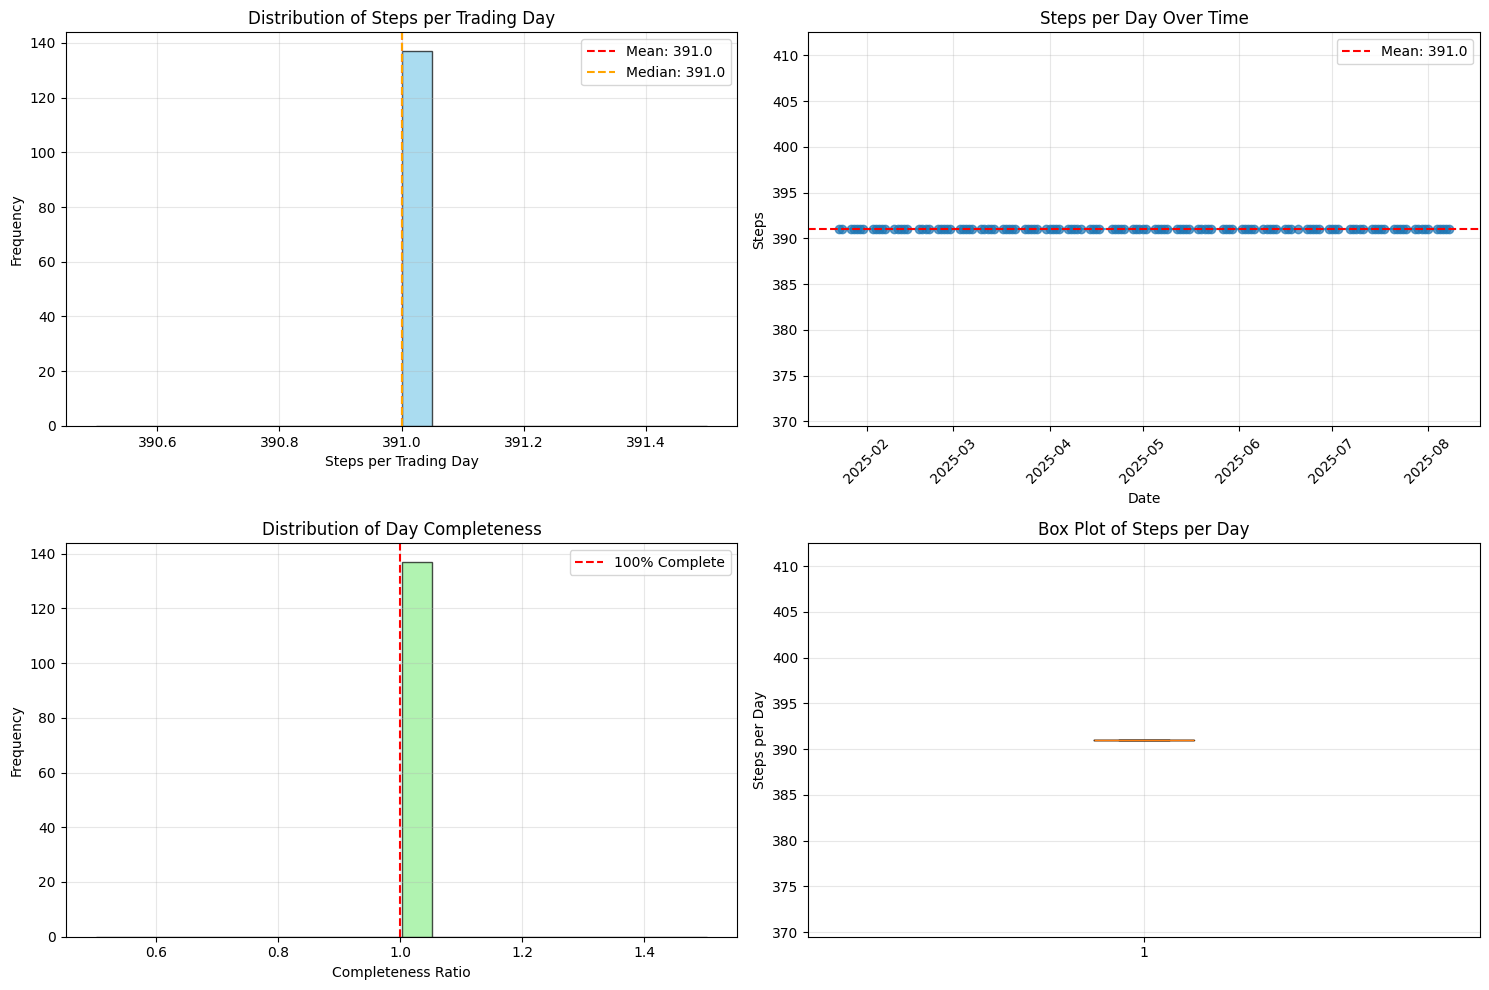


�� RL TRAINING RECOMMENDATIONS
📊 Recommended episode lengths based on data:
   • Conservative (min): 391 steps
   • Average: 391 steps
   • Median: 391 steps
   • 100.0% of days have ≥300 steps
   • 100.0% of days have ≥350 steps
   • 100.0% of days have ≥380 steps
   • 100.0% of days have ≥390 steps

🧠 RL TRAINING STRATEGY ANALYSIS
🤔 TRAINING APPROACH OPTIONS:

1️⃣  FIXED DAY START APPROACH:
   ✅ Pros:
      • Consistent episode structure
      • Agent learns market open patterns
      • Easier to debug and reproduce
      • Matches real trading behavior
   ❌ Cons:
      • Less data variety
      • May overfit to market open patterns
      • Limited exploration of mid-day scenarios

2️⃣  RANDOM START POINT APPROACH:
   ✅ Pros:
      • Maximum data utilization
      • Better exploration of different market conditions
      • More diverse training scenarios
      • Higher sample efficiency
   ❌ Cons:
      • Inconsistent episode lengths
      • May learn unrealistic transitions
      •

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from collections import Counter
from math import ceil, floor 
import pandas as pd
import pandas_ta as pdta
import config
import time
import schedule
from datetime import datetime
from datetime import date
from datetime import timedelta
import numpy as np
import statsmodels.api as sm
import scipy as sp
from scipy.stats import theilslopes , linregress
from scipy.ndimage import gaussian_filter1d , generic_filter1d
import scipy.signal as signal
import scipy.interpolate as si
from scipy.signal import find_peaks
from scipy import stats
import pywt #https://pywavelets.readthedocs.io/en/latest/ref/index.html
import mplcursors
import pickle
# import gtda
# from gtda.time_series import SingleTakensEmbedding
# from gtda.homology import VietorisRipsPersistence
# from gtda.plotting import plot_diagram
# from groq import Groq
# import anthropic
# import pprint
# from sklearn.linear_model import TheilSenRegressor

# import networkx as nx

# import matplotlib.dates as mdates
# import alpaca
import ta as ta
import pytz
import datetime
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.trading.requests import MarketOrderRequest ,LimitOrderRequest, ClosePositionRequest
from alpaca.data.requests import StockLatestQuoteRequest, CryptoLatestQuoteRequest
from alpaca.trading.client import TradingClient
from alpaca.trading.enums import OrderSide, TimeInForce
from alpaca_trade_api.rest import REST, TimeFrame, TimeFrameUnit
from IPython.display import display, clear_output
from alpaca.data.requests import CryptoBarsRequest, StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import pandas_ta as pdta
import config
import os
from alpaca.trading.requests import GetOrdersRequest
from alpaca.trading.enums import OrderSide,OrderClass,OrderType, QueryOrderStatus, OrderStatus

from sklearn.preprocessing import MinMaxScaler
count =0
alt_pkl_file_path =0
if alt_pkl_file_path==0:
    trading_client = TradingClient(config.alpaca_paper_api_key, config.alpaca_paper_secret_key, paper=True)
    stock_client = StockHistoricalDataClient(config.alpaca_paper_api_key,  config.alpaca_paper_secret_key)
    api = REST(config.alpaca_paper_api_key, config.alpaca_paper_secret_key,base_url=config.alpaca_paper_endpoint)
elif alt_pkl_file_path==1:
    trading_client = TradingClient(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key, paper=True)
    stock_client = StockHistoricalDataClient(config.alpaca_paper_counter_api_key,  config.alpaca_paper_counter_secret_key)
    api = REST(config.alpaca_paper_counter_api_key, config.alpaca_paper_counter_secret_key,base_url=config.alpaca_paper_counter_endpoint)
elif alt_pkl_file_path==2:
    trading_client = TradingClient(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key, paper=True)
    stock_client = StockHistoricalDataClient(config.alpaca_paper_mega_api_key,  config.alpaca_paper_mega_secret_key)
    api = REST(config.alpaca_paper_mega_api_key, config.alpaca_paper_mega_secret_key,base_url=config.alpaca_paper_mega_endpoint)

account = trading_client.get_account()
account
print(account)
# crypto_client = CryptoHistoricalDataClient(config.alpaca_paper_api_key,  config.alpaca_paper_secret_key)

###TIME SENSITIVITY###
time_sensev = 0.50
time_incriment = 1 # 10
time_incriment5 = 10
# if count == 0:
#     time_incriment =1
#     print('count==0',count)

# # else:
# #     time_incriment =2
# #     print('slower',time_incriment)
# elif count > 0 :
#     if (abs(bbma_trading_final.iloc[-1]> 0).sum() / len(bbma_trading_final.iloc[-1])) > time_sensev and (abs(vol_anomaly.iloc[-1]>1.75).sum() / len(vol_anomaly.iloc[-1])) > time_sensev:
#         print(count)
#         time_incriment =1
#         print('faster',time_incriment)
#     else:
#         time_incriment =2
#         print('else slower',time_incriment)

# symbol = tickers_L #combined_tickers #combined_tickers_unique #tickers_L 
symbol = tickers_L # tickers_L #['TQQQ,SQQQ,NVDA,USO,TSLA,SCO,UNH,YINN,YANG,NUGT,DUST,UVXY,KOLD,BOIL,LABU,LABD,TNA,TZA,FAS,FAZ,SOXL,SOXS,ERY,ERX,']

print('time_incriment: ',time_incriment)
print('count;',count)
if count >0:
    print('faster count: ',abs(bbma_trading_final.iloc[-1]> 0).sum())
    print('faster count: ',(abs(bbma_trading_final.iloc[-1]> 0).sum() / len(bbma_trading_final.iloc[-1])) > time_sensev and (abs(vol_anomaly.iloc[-1]>1.75).sum() / len(vol_anomaly.iloc[-1])) > time_sensev)


timeframeunit = TimeFrameUnit.Minute #TimeFrameUnit.Day

# Get the market calendar
calendar = api.get_calendar()
now = datetime.datetime.utcnow()
# Get today's date
today = datetime.datetime.today().date()

# Find the last trading day
last_trading_day = None

for day in reversed(calendar):
    if pd.Timestamp(day.date).date() < today:  # convert Timestamp to date
        last_trading_day = pd.Timestamp(day.date, hour=12, tz='UTC')
        break

# Current time
now = datetime.datetime.now(pytz.UTC)

# Calculate the difference in hours
hours_since_last_noon = int((now - last_trading_day).total_seconds() / 3600)-16

print(last_trading_day)
print(hours_since_last_noon)

if str(datetime.datetime.utcnow().time()) < '13:29:59.000000':
    lookbak_time = 24
elif '08:00:00.971400' < str(datetime.datetime.utcnow().time()) <'16:00:00.971400'  and str(datetime.datetime.utcnow().time()) <'20:00:00.971400':
    lookbak_time = 12
elif '16:00:00.971400' < str(datetime.datetime.utcnow().time())  and str(datetime.datetime.utcnow().time()) <'20:00:00.971400':
    lookbak_time = 16
elif str(datetime.datetime.utcnow().time()) > '20:00:00.971400':
    lookbak_time = 20
    # print('lookbak_time',lookbak_time)
else:
    # lookbak_time = 24
    pass
print('lookbak_time',lookbak_time)
look_back_days = 0
look_back_days_vertiacl = 0

# multisymbol_request_params = StockLatestQuoteRequest(symbol_or_symbols=symbol)
# lookback_days = 100 + 
all_df_open = []
for i in range(1, 3, 1):
    print(i)
    look_back_days = i * 100
    print(f"look_back_days: {look_back_days}")
    print(f"\n")
    Histoic_start = datetime.datetime.today()-timedelta(days=look_back_days) 
    print(f"Histoic_start: {Histoic_start}")
    if i > 0:
        end_time = datetime.datetime.today() - timedelta(days=look_back_days-100)
    else:
        end_time = datetime.datetime.today() - timedelta(days=0)
    print(f"end_time: {end_time}")
    print(f"\n")

    # Histoic_start = datetime.datetime.today()-timedelta(days=100) 
    # start = datetime.datetime.now(pytz.utc)-timedelta( days=look_back_days,hours= float(lookbak_time))#hours_since_last_noon)+16)#24 #days=365)# #(2023,1,1)#hours_since_last_noon
    # starter = datetime.datetime.now(pytz.utc)-timedelta(days=look_back_days,hours= float(lookbak_time))#hours_since_last_noon)+16)#24
    # start2 = datetime.datetime.now(pytz.utc)-timedelta(days=3, hours= float(lookbak_time))#hours_since_last_noon)+16)#24 #days=365)# #(2023,1,1)#hours_since_last_noon
    # reststart2 = start2.strftime("%Y-%m-%dT%H:%M:%SZ")    
    # # Then apply the timedelta to the current time with 1 day back
    # end_time = datetime.datetime.now(pytz.utc) - timedelta(days=look_back_days)
    # # Now apply replace to the datetime object, not the timedelta
    # end = end_time #.replace(hour=20, minute=0, second=0, microsecond=0)

    request_params = StockBarsRequest(symbol_or_symbols=symbol,start=Histoic_start, end=end_time, timeframe=TimeFrame(time_incriment,timeframeunit)) # use singal symblos til solving how to work with multi symbol manipulation
    historic = stock_client.get_stock_bars(request_params)
    historic = historic.df
    historic = historic.bfill()#.bfill()#.bfill()#.iloc[-look_back:] #.iloc[:(len(bars)-2)]
    historic.reset_index(inplace=True)
    historic['timestamp'] = pd.to_datetime(historic['timestamp'], unit='ms',utc=True)
    historic = historic.set_index('timestamp')

    historic =historic.drop_duplicates(keep='last')
    historic = historic.pivot(columns='symbol',values=historic.columns)

    fill_mapping = {column_name: column_name for column_name in historic.symbol.columns}
    # historic['symbol'] = historic.symbol.apply(lambda col: col.fillna(fill_mapping[col.name]))
    # historic = historic.drop(columns=['symbol'])

    historic.tail(50)


    # Filter for market open hours (9:30 to 16:00) datetime.datetime.strptime("13:30", "%H:%M").time())
    is_open = (historic.index.time >= datetime.datetime.strptime("13:30", "%H:%M").time()) & \
            (historic.index.time <= datetime.datetime.strptime("20:00", "%H:%M").time())
    df_open = historic[is_open]

    all_df_open.append(df_open)

df_multiday = pd.concat(all_df_open)
df_multiday.sort_index(inplace=True)

# Create a continuous x-axis: "market minute index"
df_multiday = df_multiday.copy()
df_multiday['day'] = df_multiday.index.date

# Count minutes since the start of the first day (stitching all open periods together)
minute_offsets = []
offset = 0
for day, group in df_multiday.groupby('day'):
    n = len(group)
    minute_offsets.extend(range(offset, offset + n))
    offset += n

df_multiday['market_minute'] = minute_offsets
df_multiday.to_pickle("df_multiday.pkl")
print(df_multiday)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import  time

def analyze_trading_day_structure(df_multiday_path="df_multiday.pkl"):
    """
    Analyze the trading day structure to understand step counts between 13:30-20:00
    """
    # Load the data
    try:
        df_multiday = pd.read_pickle(df_multiday_path)
    except FileNotFoundError:
        print(f"❌ File {df_multiday_path} not found. Please run your data collection first.")
        return None
    
    print("📊 Analyzing trading day structure...")
    print(f"📅 Total data range: {df_multiday.index.min()} to {df_multiday.index.max()}")
    print(f"�� Trading hours: 13:30-20:00")
    
    # Group by day and analyze each trading day
    daily_stats = []
    
    for day, day_data in df_multiday.groupby('day'):
        # Count steps for this day
        steps_this_day = len(day_data)
        
        # Get time range for this day
        day_start = day_data.index.min().time()
        day_end = day_data.index.max().time()
        
        # Calculate expected steps based on time increment
        # From your code: time_incriment = 1 (1-minute intervals)
        expected_minutes = (datetime.datetime.combine(datetime.datetime.min, datetime.time(20, 0)) - 
                          datetime.datetime.combine(datetime.datetime.min, datetime.time(13, 30))).total_seconds() / 60
        expected_steps = int(expected_minutes)  # Should be ~390 minutes (6.5 hours)
        
        daily_stats.append({
            'date': day,
            'steps': steps_this_day,
            'expected_steps': expected_steps,
            'completeness': steps_this_day / expected_steps if expected_steps > 0 else 0,
            'day_start': day_start,
            'day_end': day_end,
            'missing_steps': expected_steps - steps_this_day
        })
    
    # Convert to DataFrame for analysis
    stats_df = pd.DataFrame(daily_stats)
    
    # Calculate summary statistics
    print("\n" + "="*60)
    print("📈 TRADING DAY ANALYSIS RESULTS")
    print("="*60)
    
    print(f"�� Total trading days analyzed: {len(stats_df)}")
    print(f"📊 Average steps per day: {stats_df['steps'].mean():.1f}")
    print(f"📊 Median steps per day: {stats_df['steps'].median():.1f}")
    print(f"�� Min steps per day: {stats_df['steps'].min()}")
    print(f"�� Max steps per day: {stats_df['steps'].max()}")
    print(f"�� Standard deviation: {stats_df['steps'].std():.1f}")
    
    print(f"\n�� Expected steps per day (13:30-20:00): {stats_df['expected_steps'].iloc[0]}")
    print(f"📊 Average completeness: {stats_df['completeness'].mean():.1%}")
    
    # Identify incomplete days
    incomplete_days = stats_df[stats_df['completeness'] < 0.95]
    if len(incomplete_days) > 0:
        print(f"\n⚠️  Incomplete trading days (<95% complete): {len(incomplete_days)}")
        print("   These days may have missing data or early market closes")
        for _, day in incomplete_days.head(5).iterrows():
            print(f"   {day['date']}: {day['steps']}/{day['expected_steps']} steps ({day['completeness']:.1%})")
    
    # Visualize the distribution
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Steps per day distribution
    plt.subplot(2, 2, 1)
    plt.hist(stats_df['steps'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(stats_df['steps'].mean(), color='red', linestyle='--', label=f'Mean: {stats_df["steps"].mean():.1f}')
    plt.axvline(stats_df['steps'].median(), color='orange', linestyle='--', label=f'Median: {stats_df["steps"].median():.1f}')
    plt.xlabel('Steps per Trading Day')
    plt.ylabel('Frequency')
    plt.title('Distribution of Steps per Trading Day')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Steps over time
    plt.subplot(2, 2, 2)
    plt.plot(stats_df['date'], stats_df['steps'], marker='o', alpha=0.7)
    plt.axhline(stats_df['steps'].mean(), color='red', linestyle='--', label=f'Mean: {stats_df["steps"].mean():.1f}')
    plt.xlabel('Date')
    plt.ylabel('Steps')
    plt.title('Steps per Day Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Completeness distribution
    plt.subplot(2, 2, 3)
    plt.hist(stats_df['completeness'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.axvline(1.0, color='red', linestyle='--', label='100% Complete')
    plt.xlabel('Completeness Ratio')
    plt.ylabel('Frequency')
    plt.title('Distribution of Day Completeness')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Box plot of steps
    plt.subplot(2, 2, 4)
    plt.boxplot(stats_df['steps'])
    plt.ylabel('Steps per Day')
    plt.title('Box Plot of Steps per Day')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print recommendations
    print("\n" + "="*60)
    print("�� RL TRAINING RECOMMENDATIONS")
    print("="*60)
    
    # Calculate recommended episode length
    avg_steps = stats_df['steps'].mean()
    median_steps = stats_df['steps'].median()
    min_steps = stats_df['steps'].min()
    
    print(f"📊 Recommended episode lengths based on data:")
    print(f"   • Conservative (min): {min_steps} steps")
    print(f"   • Average: {avg_steps:.0f} steps")
    print(f"   • Median: {median_steps:.0f} steps")
    
    # Calculate what percentage of days meet different thresholds
    for threshold in [300, 350, 380, 390]:
        pct_above = (stats_df['steps'] >= threshold).mean() * 100
        print(f"   • {pct_above:.1f}% of days have ≥{threshold} steps")
    
    return stats_df

def recommend_rl_training_strategy(stats_df):
    """
    Provide recommendations for RL training strategy
    """
    print("\n" + "="*60)
    print("🧠 RL TRAINING STRATEGY ANALYSIS")
    print("="*60)
    
    avg_steps = stats_df['steps'].mean()
    median_steps = stats_df['steps'].median()
    
    print("🤔 TRAINING APPROACH OPTIONS:")
    print("\n1️⃣  FIXED DAY START APPROACH:")
    print("   ✅ Pros:")
    print("      • Consistent episode structure")
    print("      • Agent learns market open patterns")
    print("      • Easier to debug and reproduce")
    print("      • Matches real trading behavior")
    print("   ❌ Cons:")
    print("      • Less data variety")
    print("      • May overfit to market open patterns")
    print("      • Limited exploration of mid-day scenarios")
    
    print("\n2️⃣  RANDOM START POINT APPROACH:")
    print("   ✅ Pros:")
    print("      • Maximum data utilization")
    print("      • Better exploration of different market conditions")
    print("      • More diverse training scenarios")
    print("      • Higher sample efficiency")
    print("   ❌ Cons:")
    print("      • Inconsistent episode lengths")
    print("      • May learn unrealistic transitions")
    print("      • Harder to interpret behavior")
    
    print("\n3️⃣  HYBRID APPROACH (RECOMMENDED):")
    print("   ✅ Best of both worlds:")
    print("      • Use average day length as episode length")
    print("      • Allow random start points within valid ranges")
    print("      • Ensure minimum episode length for learning")
    print("      • Add day boundary awareness")
    
    print(f"\n�� SPECIFIC RECOMMENDATIONS:")
    print(f"   • Episode length: {median_steps:.0f} steps (median)")
    print(f"   • Minimum episode length: {stats_df['steps'].quantile(0.1):.0f} steps (10th percentile)")
    print(f"   • Maximum episode length: {stats_df['steps'].quantile(0.9):.0f} steps (90th percentile)")
    
    print(f"\n📊 DATA UTILIZATION:")
    total_possible_episodes = len(stats_df)
    print(f"   • Total trading days: {total_possible_episodes}")
    print(f"   • With random starts: ~{total_possible_episodes * 3} possible episodes")
    print(f"   • With sliding windows: ~{total_possible_episodes * 5} possible episodes")

# Run the analysis
if __name__ == "__main__":
    # Analyze the trading day structure
    stats_df = analyze_trading_day_structure()
    
    if stats_df is not None:
        # Provide RL training recommendations
        recommend_rl_training_strategy(stats_df)
        
        # Save results for reference
        # stats_df.to_csv("trading_day_analysis.csv", index=False)
        print(f"\n💾 Analysis saved to 'trading_day_analysis.csv'")




# for symbol in df_open["open"].columns[:20]:
#     print(symbol)

#     plt.figure(figsize=(14, 6))
    
#     plt.plot(df_open['market_minute'],df_open["open"][symbol],label=f'{symbol}')
#     plt.plot(df_open['market_minute'],df_open["close"][symbol],label=f'{symbol}')
#     plt.plot(df_open['market_minute'],df_open["high"][symbol],label=f'{symbol}')
#     plt.plot(df_open['market_minute'],df_open["low"][symbol],label=f'{symbol}')
#     # Optionally, add vertical lines to indicate day changes
#     for day, group in df_open.groupby('day'):
#         plt.axvline(group['market_minute'].iloc[0], color='gray', linestyle='--', alpha=0.5)
#         plt.text(group['market_minute'].iloc[0], plt.ylim()[1], str(day), va='bottom', ha='left', fontsize=8, color='gray')    
#     plt.legend()
#     plt.title(f'symbol: {symbol} , date window {Histoic_start} to {end}')
#     plt.show()




print(f'df_open.shape: {df_open.shape}')




# Look back flow

AAPL


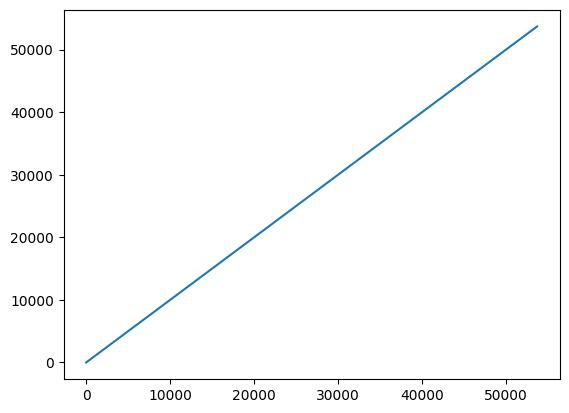

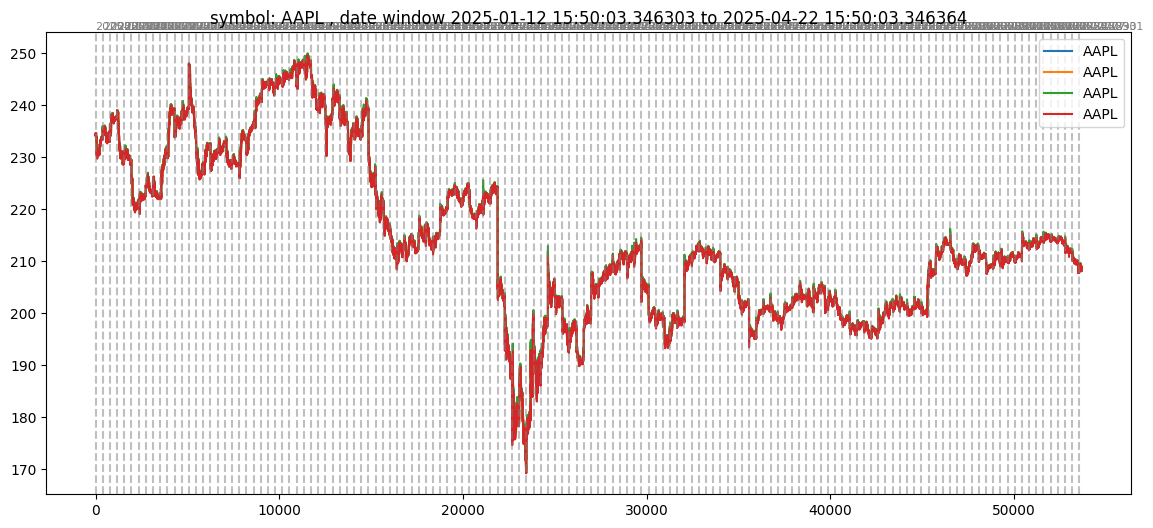

ABBV


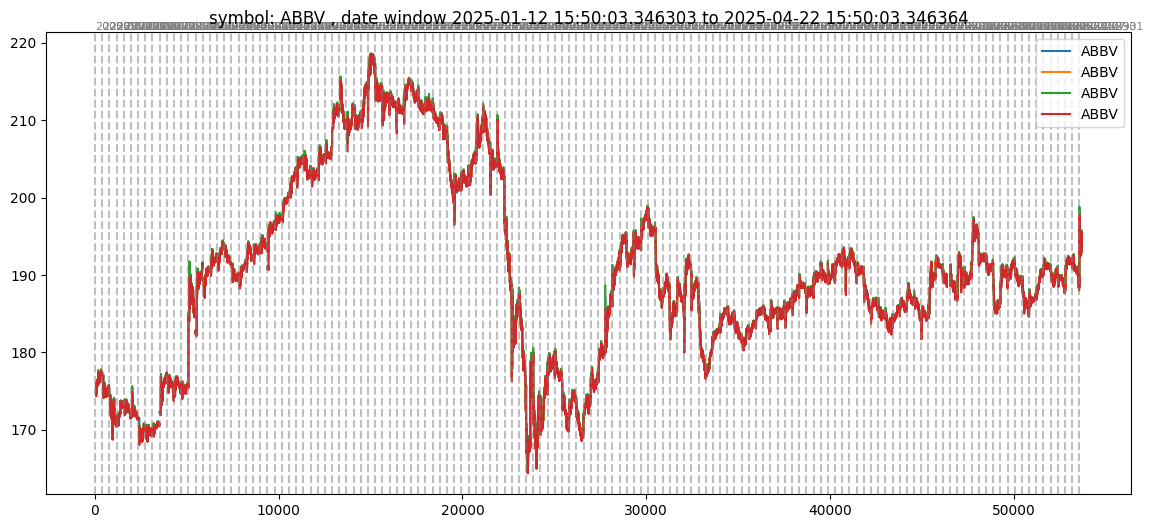

AEP


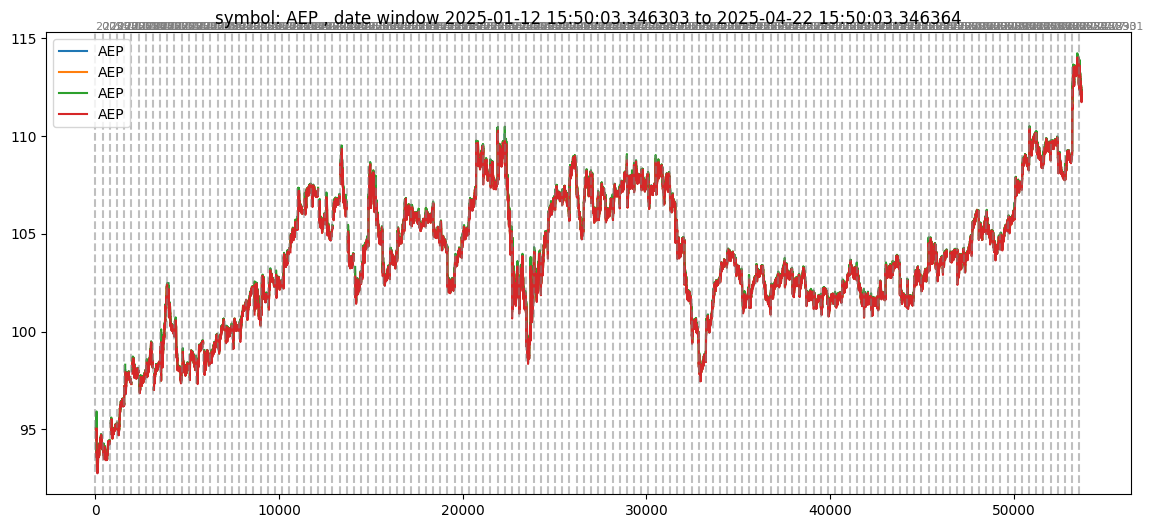

AMT


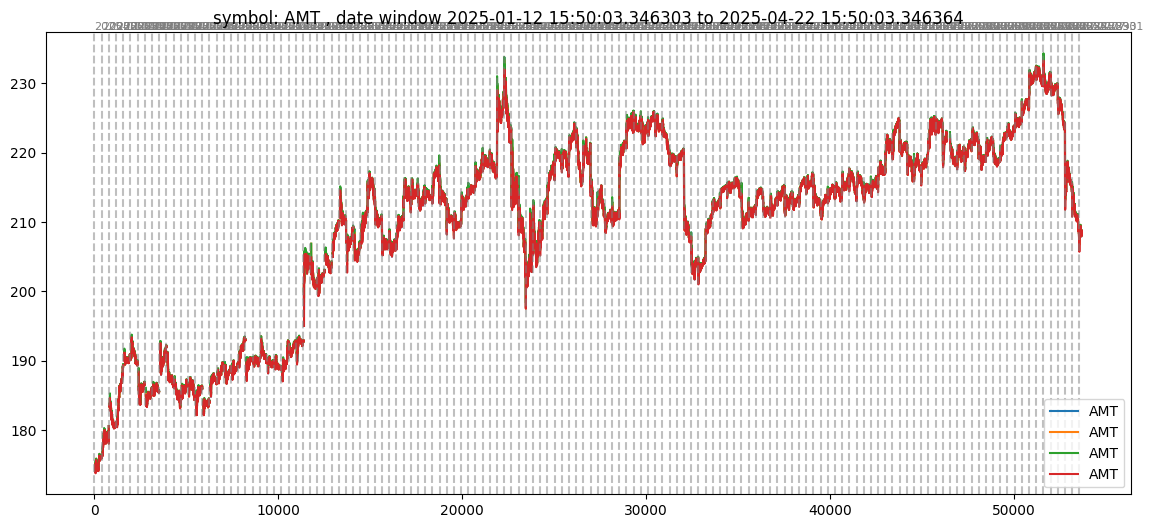

AMZN


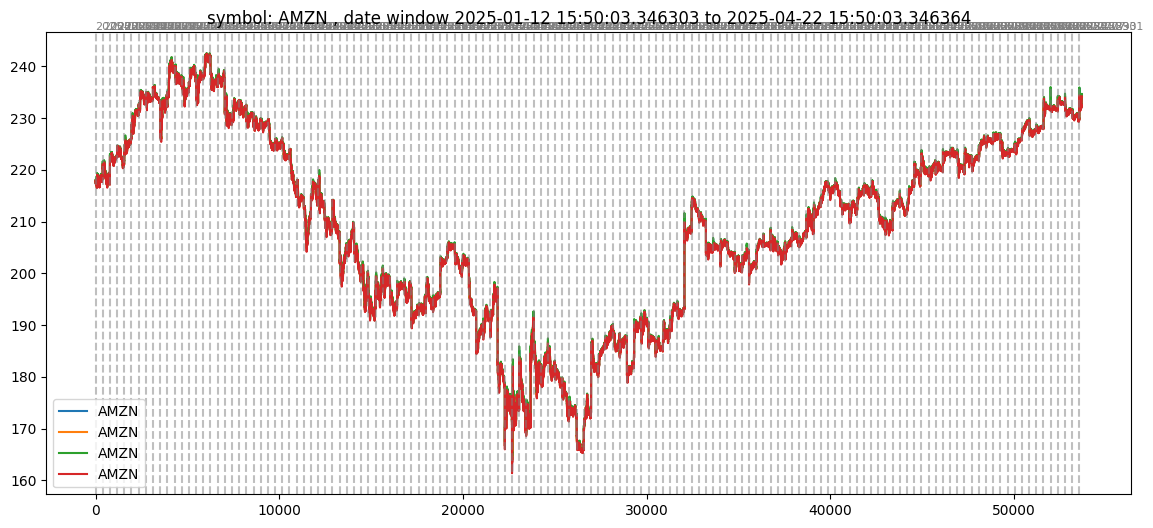

APD


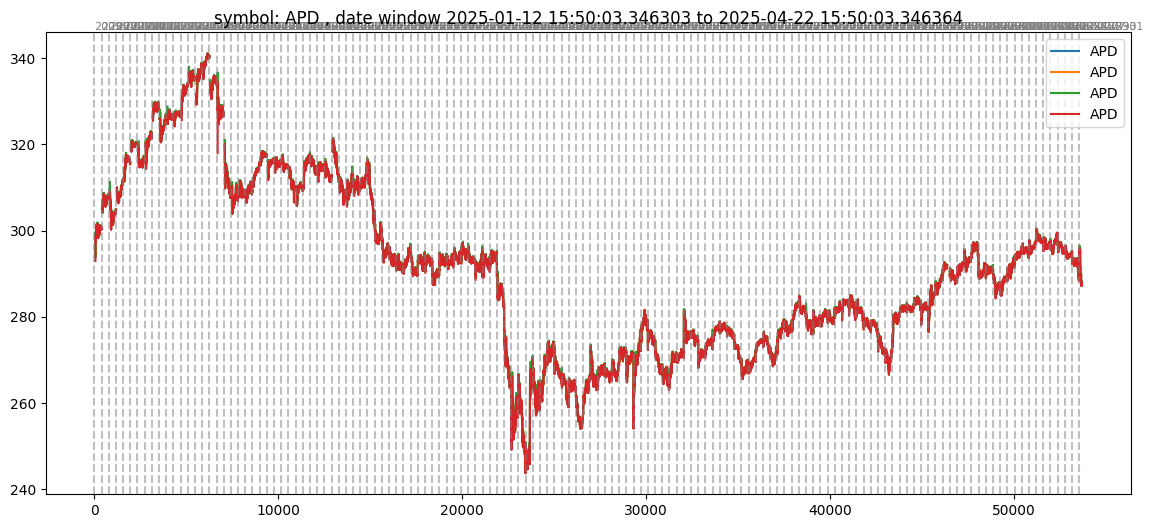

BA


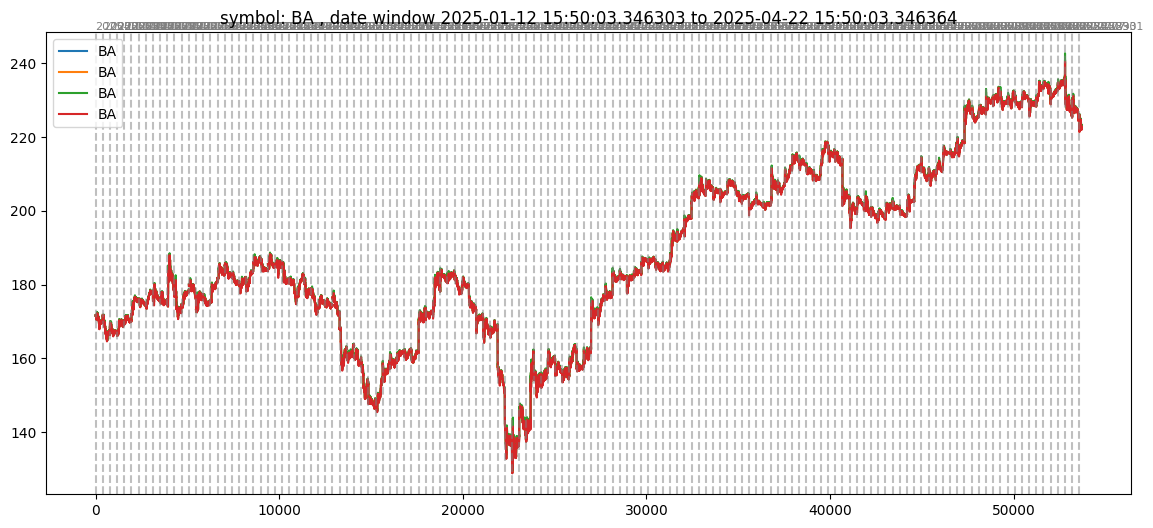

BAC


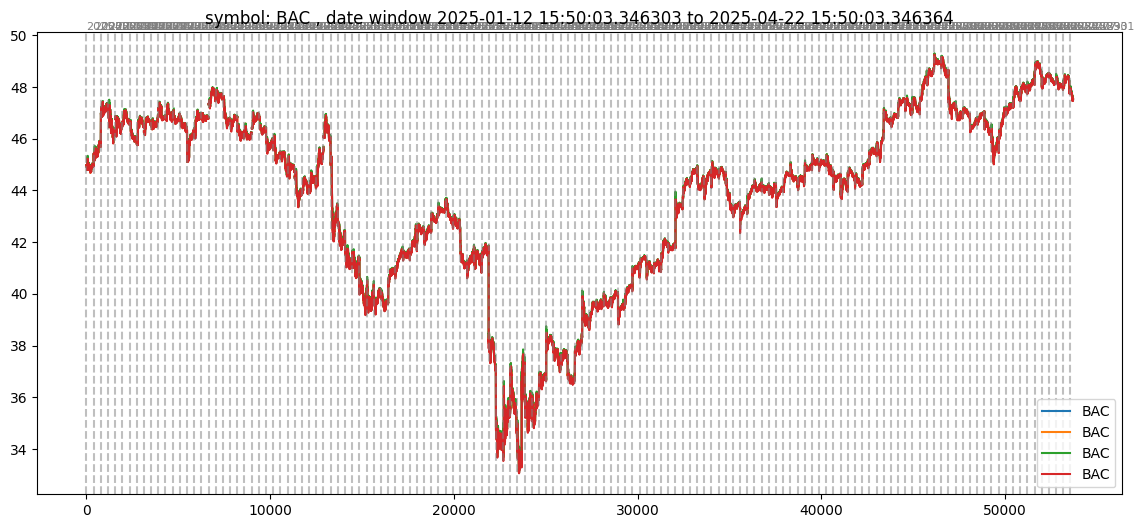

BOIL


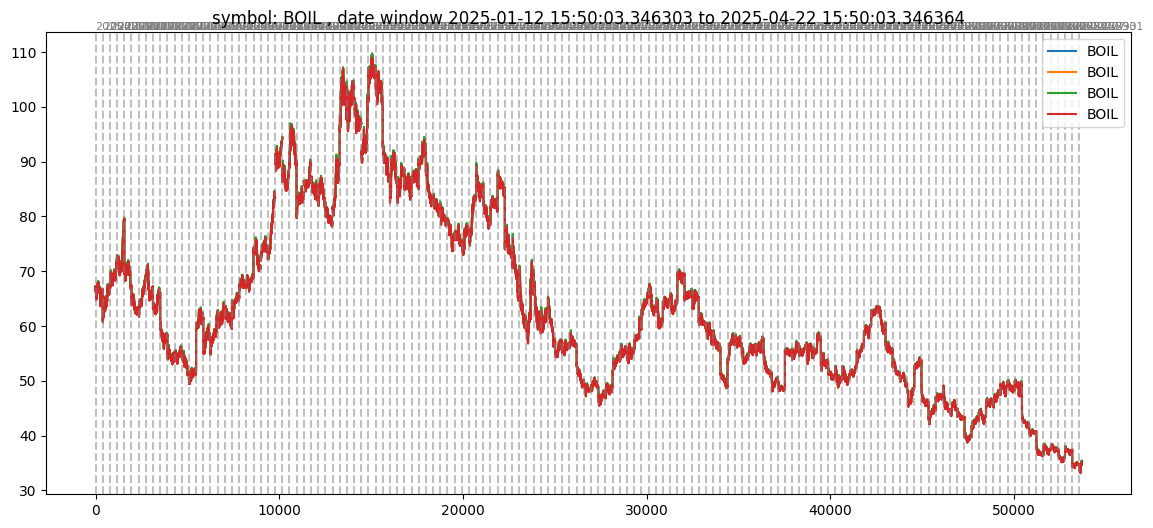

C


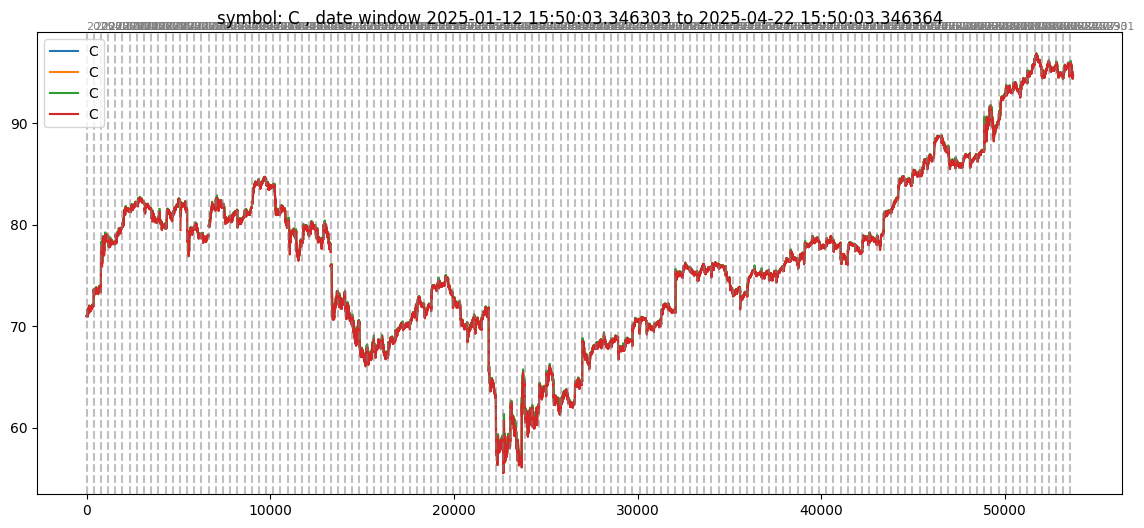

CAT


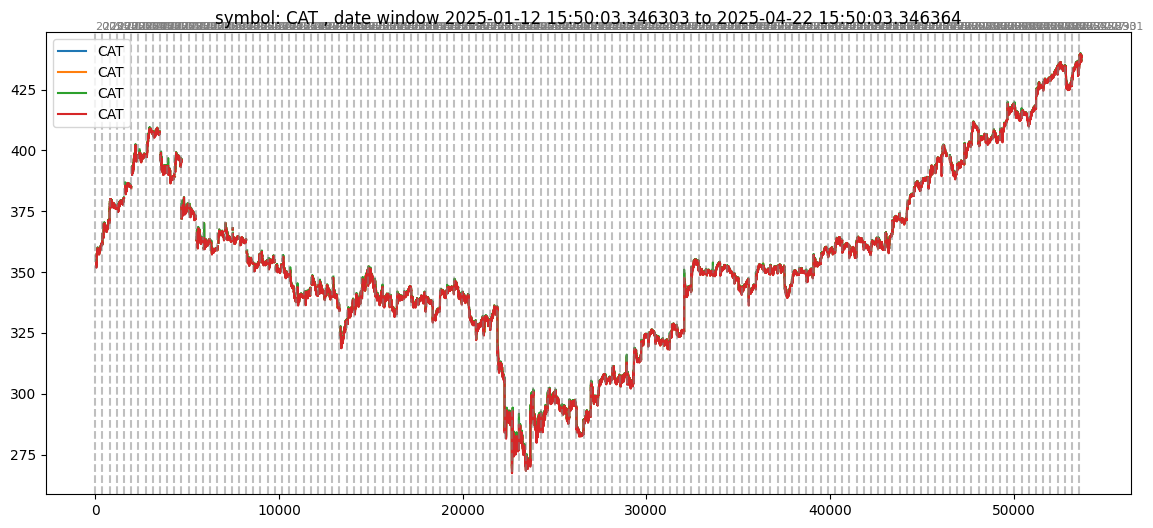

CCI


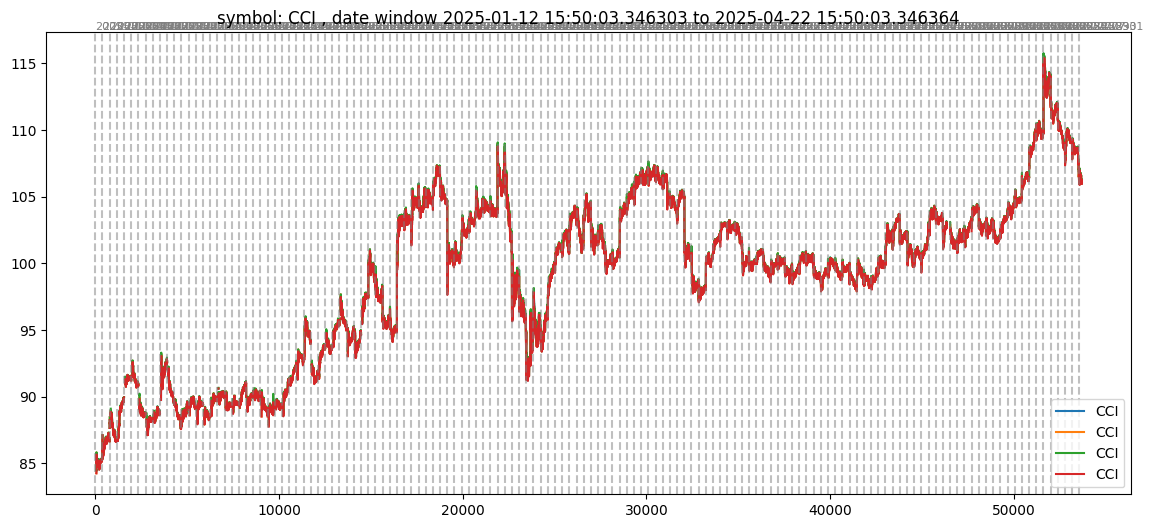

COP


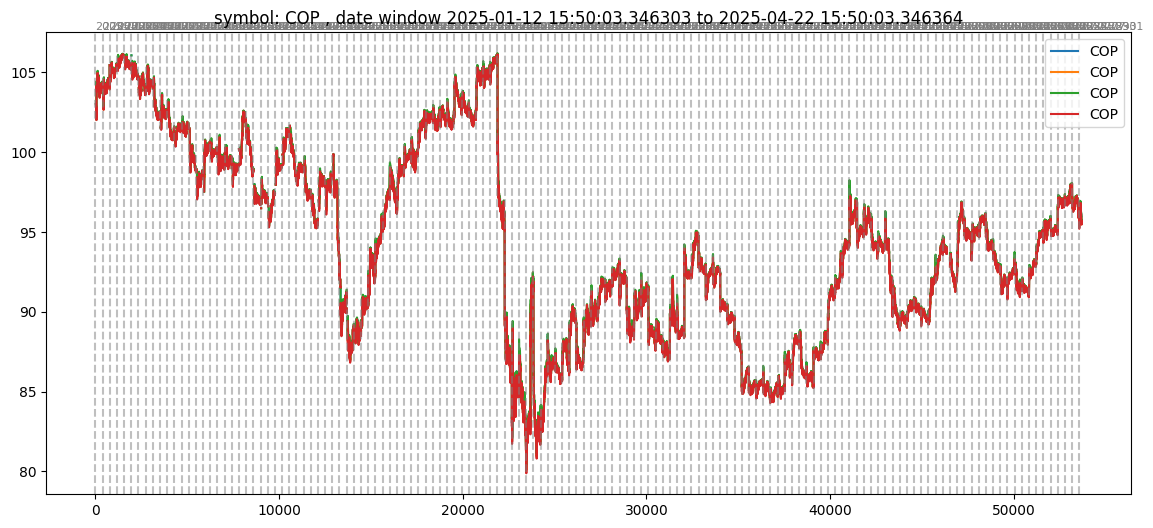

COST


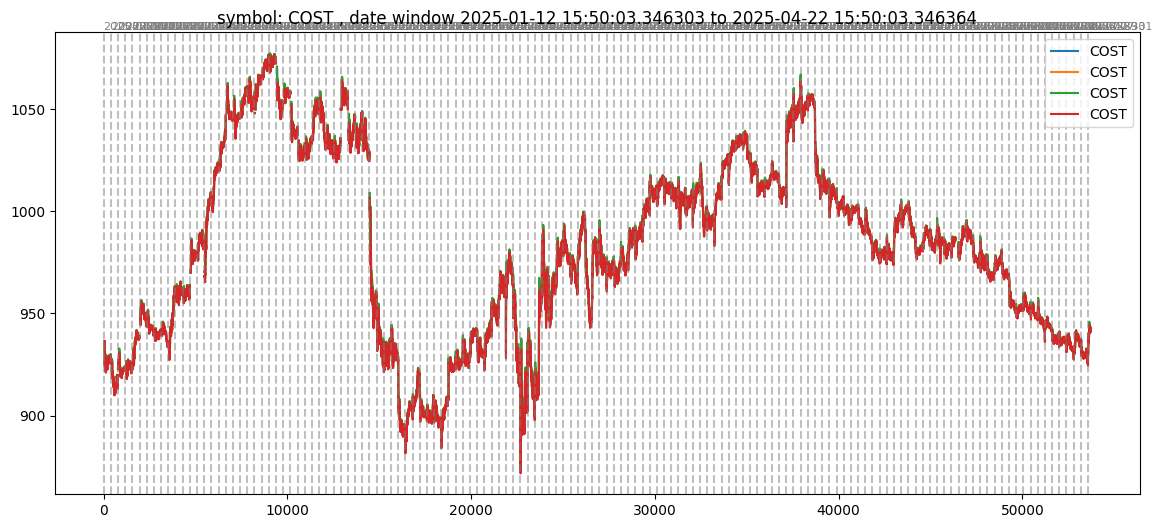

CVX


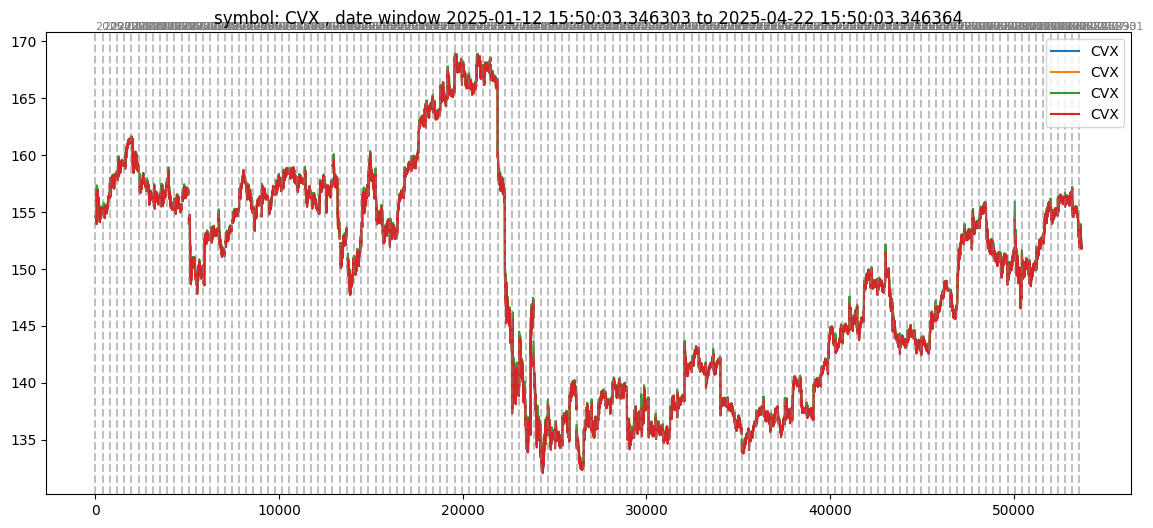

D


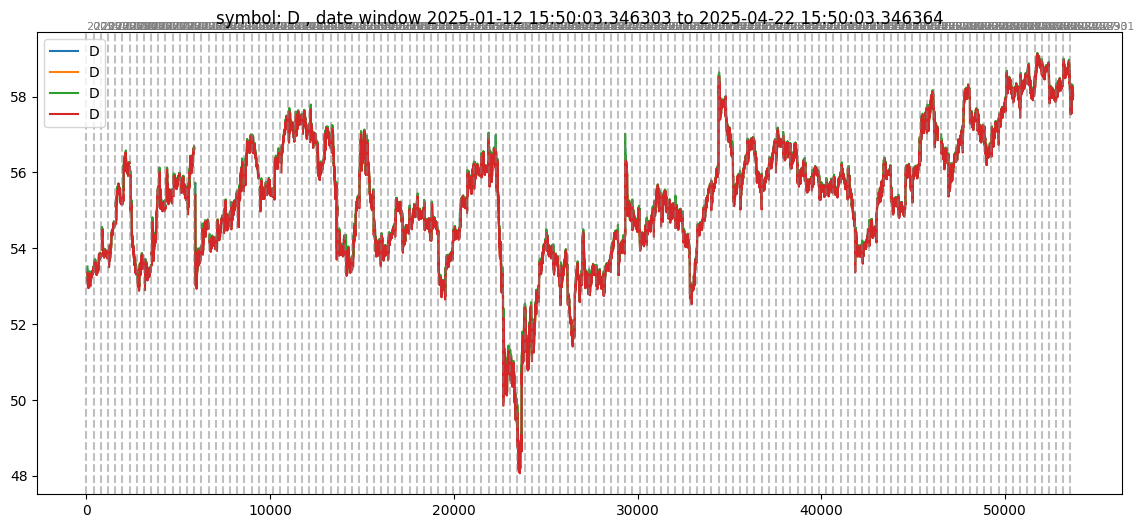

DIS


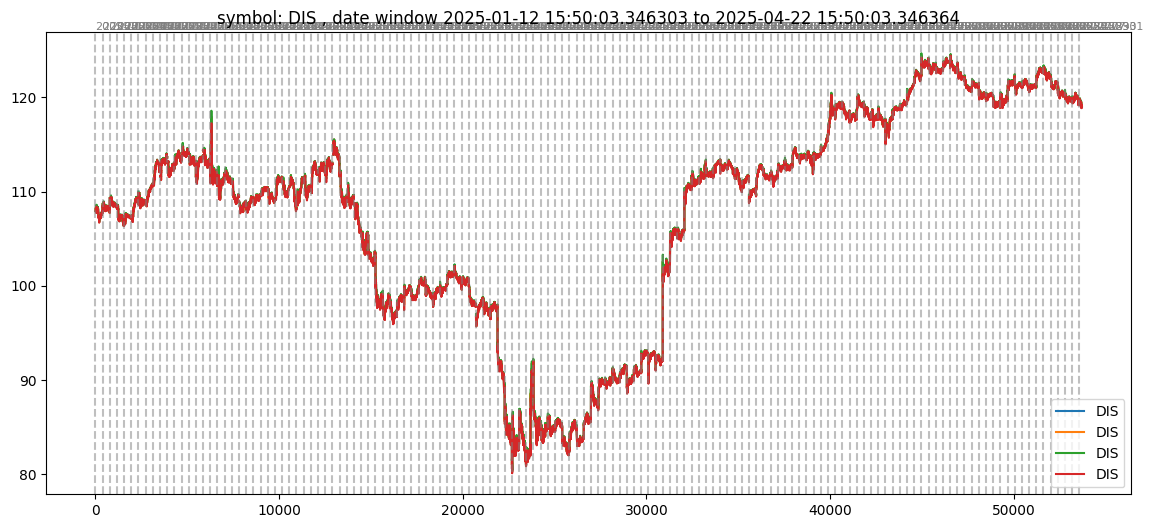

DUK


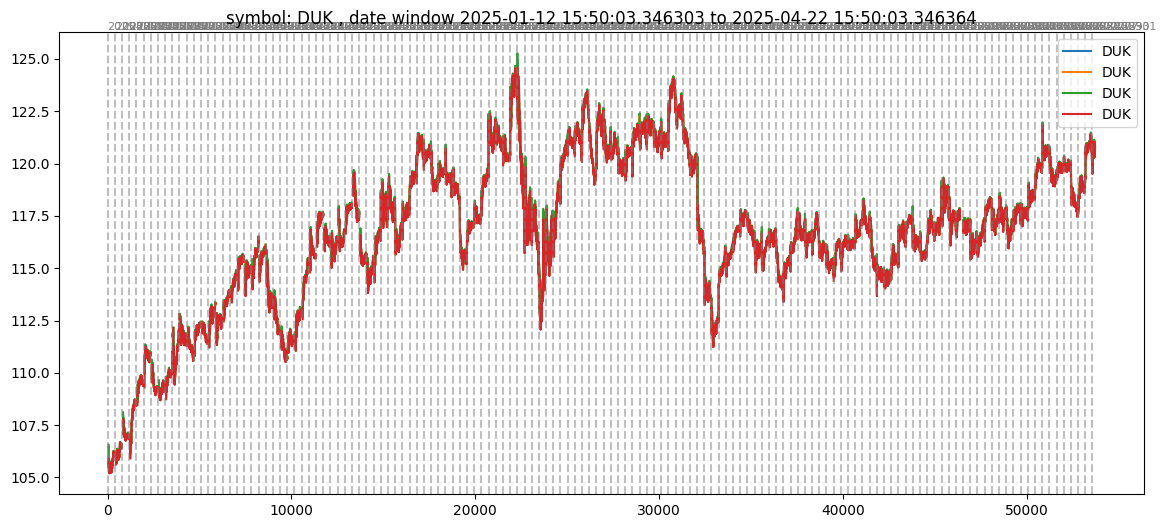

DUST


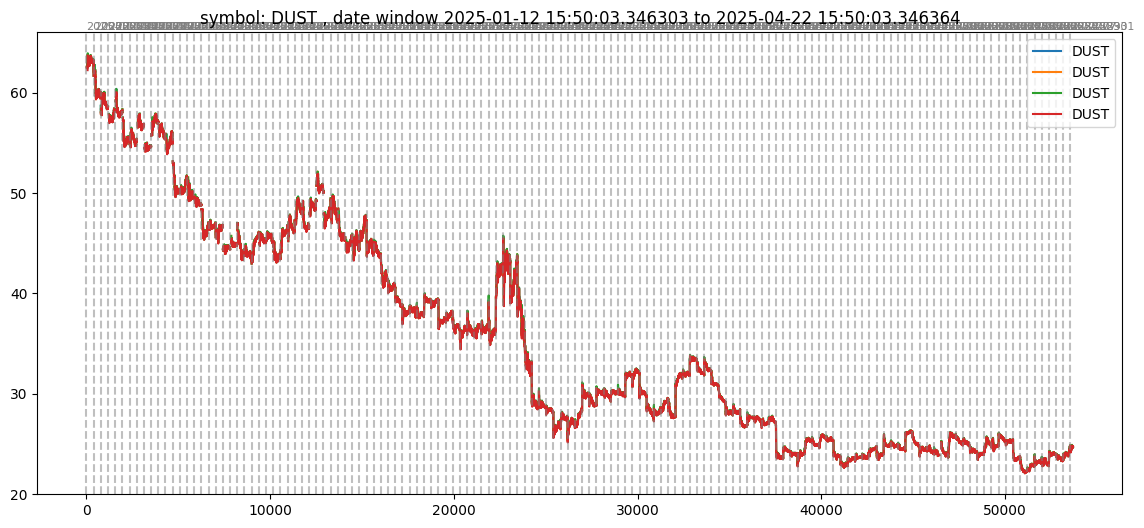

ECL


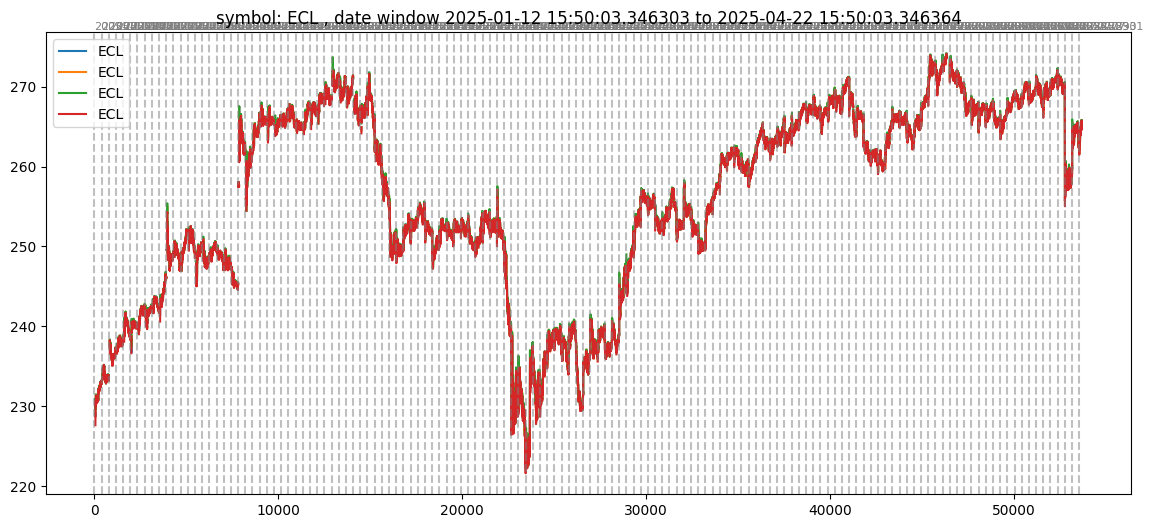

In [5]:
# df_open.to_pickle("df_multiday.pkl")
# df_open.to_csv("df_multiday.csv")
# df_multiday = pd.read_csv("df_multiday.csv")
# df_multiday
df_multiday = pd.read_pickle("df_multiday.pkl")
# df_multiday.columns.get_level_values(0).unique()
plt.plot(range(len(df_multiday)),df_multiday.market_minute)


for symbol in df_multiday["open"].columns[:20]:
    print(symbol)

    plt.figure(figsize=(14, 6))
    
    plt.plot(df_multiday["market_minute"],df_multiday["open"][symbol],label=f'{symbol}')
    plt.plot(df_multiday["market_minute"],df_multiday["close"][symbol],label=f'{symbol}')
    plt.plot(df_multiday["market_minute"],df_multiday["high"][symbol],label=f'{symbol}')
    plt.plot(df_multiday["market_minute"],df_multiday["low"][symbol],label=f'{symbol}')
    # Optionally, add vertical lines to indicate day changes
    for day, group in df_multiday.groupby('day'):
        plt.axvline(group['market_minute'].iloc[0], color='gray', linestyle='--', alpha=0.5)
        plt.text(group['market_minute'].iloc[0], plt.ylim()[1], str(day), va='bottom', ha='left', fontsize=8, color='gray')    
    plt.legend()
    plt.title(f'symbol: {symbol} , date window {Histoic_start} to {end_time}')
    plt.show()


In [8]:
print(df_multiday.close.columns)
df_multiday

Index(['AAPL', 'ABBV', 'AEP', 'AMT', 'AMZN', 'APD', 'BA', 'BAC', 'BOIL', 'C',
       'CAT', 'CCI', 'COP', 'COST', 'CVX', 'D', 'DIS', 'DUK', 'DUST', 'ECL',
       'EQIX', 'ERX', 'ERY', 'FAS', 'FAZ', 'GE', 'GOOGL', 'GS', 'HD', 'HON',
       'JNJ', 'JPM', 'KO', 'KOLD', 'LABD', 'LABU', 'LIN', 'MCD', 'META', 'MPC',
       'MRK', 'MSFT', 'NEE', 'NEM', 'NFLX', 'NKE', 'NUGT', 'NVDA', 'PEP',
       'PFE', 'PG', 'PLD', 'PSA', 'PSX', 'SCO', 'SHW', 'SO', 'SOXL', 'SOXS',
       'SQQQ', 'TNA', 'TQQQ', 'TSLA', 'TZA', 'UNH', 'UPS', 'USO', 'UVXY',
       'VAW', 'VCR', 'VDC', 'VDE', 'VFH', 'VGT', 'VHT', 'VIS', 'VNQ', 'VOX',
       'VPU', 'VZ', 'WFC', 'WMT', 'XLB', 'XLC', 'XLE', 'XLF', 'XLI', 'XLK',
       'XLP', 'XLRE', 'XLU', 'XLV', 'XLY', 'XOM', 'YANG', 'YINN'],
      dtype='object', name='symbol')


symbol                                             \
symbol                      AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
timestamp                                                                     
2025-01-23 13:30:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  NaN   NaN   
2025-01-23 13:31:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  BAC   NaN   
2025-01-23 13:32:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN   BA  BAC   NaN   
2025-01-23 13:33:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  BAC  BOIL   
2025-01-23 13:34:00+00:00   AAPL   NaN  NaN  NaN  AMZN  NaN  NaN  BAC  BOIL   
...                          ...   ...  ...  ...   ...  ...  ...  ...   ...   
2025-08-08 19:56:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
2025-08-08 19:57:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
2025-08-08 19:58:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
2025-08-08 19:59:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   
2025-08-08 20:00:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD   BA  BAC  BOIL   

                                ...       vwap                        \
symbol                       C  ...        XLP       XLRE        XLU   
timestamp                       ...                                    
2025-01-23 13:30:00+00:00  NaN  ...      77.21        NaN        NaN   
2025-01-23 13:31:00+00:00  NaN  ...        NaN        NaN        NaN   
2025-01-23 13:32:00+00:00  NaN  ...        NaN        NaN        NaN   
2025-01-23 13:33:00+00:00  NaN  ...        NaN        NaN        NaN   
2025-01-23 13:34:00+00:00  NaN  ...        NaN        NaN        NaN   
...                        ...  ...        ...        ...        ...   
2025-08-08 19:56:00+00:00    C  ...   82.43407  41.251301  86.159368   
2025-08-08 19:57:00+00:00    C  ...  82.455612  41.260236  86.172798   
2025-08-08 19:58:00+00:00    C  ...  82.471073  41.257887  86.182429   
2025-08-08 19:59:00+00:00    C  ...  82.469045  41.257877  86.176384   
2025-08-08 20:00:00+00:00    C  ...      82.48      41.25      86.18   

                                                                          \
symbol                            XLV         XLY         XOM       YANG   
timestamp                                                                  
2025-01-23 13:30:00+00:00         NaN         NaN      109.98        NaN   
2025-01-23 13:31:00+00:00         NaN         NaN         NaN        NaN   
2025-01-23 13:32:00+00:00         NaN         NaN         NaN      69.51   
2025-01-23 13:33:00+00:00         NaN         NaN         NaN        NaN   
2025-01-23 13:34:00+00:00         NaN         NaN         NaN       69.5   
...                               ...         ...         ...        ...   
2025-08-08 19:56:00+00:00  130.163042  223.742114  106.803555  28.621629   
2025-08-08 19:57:00+00:00  130.167169  223.767207   106.81796  28.620282   
2025-08-08 19:58:00+00:00  130.183339  223.783874  106.809139  28.620081   
2025-08-08 19:59:00+00:00  130.170338  223.772103  106.807925  28.614354   
2025-08-08 20:00:00+00:00      130.16  223.763546     106.855  28.550537   

                                             day market_minute  
symbol                          YINN                            
timestamp                                                       
2025-01-23 13:30:00+00:00      27.38  2025-01-23             0  
2025-01-23 13:31:00+00:00        NaN  2025-01-23             1  
2025-01-23 13:32:00+00:00  27.372833  2025-01-23             2  
2025-01-23 13:33:00+00:00  27.366409  2025-01-23             3  
2025-01-23 13:34:00+00:00  27.385381  2025-01-23             4  
...                              ...         ...           ...  
2025-08-08 19:56:00+00:00   43.09449  2025-08-08         53562  
2025-08-08 19:57:00+00:00       43.1  2025-08-08         53563  
2025-08-08 19:58:00+00:00  43.105472  2025-08-08         53564  
2025-08-08 19:59:00+00:00  43.113486  2025-08-08         53565  


In [7]:
# Histoic_start = datetime.datetime.today()-timedelta(days=100)# 
# start = datetime.datetime.now(pytz.utc)-timedelta( days=look_back_days,hours= float(lookbak_time))#hours_since_last_noon)+16)#24 #days=365)# #(2023,1,1)#hours_since_last_noon
# starter = datetime.datetime.now(pytz.utc)-timedelta(days=look_back_days,hours= float(lookbak_time))#hours_since_last_noon)+16)#24
# start2 = datetime.datetime.now(pytz.utc)-timedelta(days=3, hours= float(lookbak_time))#hours_since_last_noon)+16)#24 #days=365)# #(2023,1,1)#hours_since_last_noon
# reststart2 = start2.strftime("%Y-%m-%dT%H:%M:%SZ")    
# # Then apply the timedelta to the current time with 1 day back
# end_time = datetime.datetime.now(pytz.utc) - timedelta(days=look_back_days)
# # Now apply replace to the datetime object, not the timedelta
# end = end_time#.replace(hour=20, minute=0, second=0, microsecond=0)
import datetime
from datetime import timedelta
for i in range(1,3,1):
    print(i)
    look_back_days = i * 100
    print(f"look_back_days: {look_back_days}")
    print(f"\n")
    Histoic_start = datetime.datetime.today()-timedelta(days=look_back_days) 
    print(f"Histoic_start: {Histoic_start}")
    if i > 0:
        end_time = datetime.datetime.today() - timedelta(days=look_back_days-100)
    else:
        end_time = datetime.datetime.today() - timedelta(days=0)
    print(f"end_time: {end_time}")
    print(f"\n")


# %%

1
look_back_days: 100


Histoic_start: 2025-04-22 14:44:02.157023
end_time: 2025-07-31 14:44:02.157136


2
look_back_days: 200


Histoic_start: 2025-01-12 14:44:02.157222
end_time: 2025-04-22 14:44:02.157240




# Structure

In [6]:
Histoic_start 

datetime.datetime(2025, 4, 21, 13, 23, 11, 701071)

In [5]:
print(historic.shape)
# df_open = df_open.drop(columns= ["symbol"])
print(f"shape/12 days = {df_open.shape[0]/12}")
print(f"columns/symbol 770/20 = {df_open.shape[1]/20}")
df_open



(66300, 768)
shape/12 days = 2267.6666666666665
columns/symbol 770/20 = 38.5


symbol                                               \
symbol                      AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
timestamp                                                                       
2025-04-21 13:30:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-04-21 13:31:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-04-21 13:32:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-04-21 13:33:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  NaN  BA  BAC  BOIL  C   
2025-04-21 13:34:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
...                          ...   ...  ...  ...   ...  ...  ..  ...   ... ..   
2025-07-30 17:18:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-07-30 17:19:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-07-30 17:20:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-07-30 17:21:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   
2025-07-30 17:22:00+00:00   AAPL  ABBV  AEP  AMT  AMZN  APD  BA  BAC  BOIL  C   

                           ...       vwap                                    \
symbol                     ...        XLP       XLRE        XLU         XLV   
timestamp                  ...                                                
2025-04-21 13:30:00+00:00  ...  81.952219  40.122366  77.431225  135.205385   
2025-04-21 13:31:00+00:00  ...  81.902382  40.116685   77.32424  135.074732   
2025-04-21 13:32:00+00:00  ...  81.876514  40.099686  77.178135  134.650178   
2025-04-21 13:33:00+00:00  ...  81.818145  40.139366  76.989048  134.307517   
2025-04-21 13:34:00+00:00  ...  81.797752  40.091074  76.934084  134.203146   
...                        ...        ...        ...        ...         ...   
2025-07-30 17:18:00+00:00  ...  80.830913  42.530298  85.505199  134.606039   
2025-07-30 17:19:00+00:00  ...  80.854517  42.533624  85.519812  134.601475   
2025-07-30 17:20:00+00:00  ...  80.874829  42.536075  85.516199  134.641828   
2025-07-30 17:21:00+00:00  ...  80.878056  42.529352  85.525556  134.637335   
2025-07-30 17:22:00+00:00  ...   80.85507  42.530365  85.545624  134.597326   

                                                                         \
symbol                            XLY         XOM       YANG       YINN   
timestamp                                                                 
2025-04-21 13:30:00+00:00  182.702884  105.428723  47.436854  28.875954   
2025-04-21 13:31:00+00:00  182.632635  104.979078  47.409143  28.891999   
2025-04-21 13:32:00+00:00  182.482332  104.800567  47.495391  28.827094   
2025-04-21 13:33:00+00:00     182.415  104.642961  47.718181  28.685231   
2025-04-21 13:34:00+00:00  182.438158  104.481513  47.779152  28.655162   
...                               ...         ...        ...        ...   
2025-07-30 17:18:00+00:00  223.982236  112.174038  28.008978  44.295167   
2025-07-30 17:19:00+00:00  223.997536  112.159787  28.016613  44.287021   
2025-07-30 17:20:00+00:00  224.045621  112.193145  28.023604    44.2638   
2025-07-30 17:21:00+00:00  224.007523   112.16005  28.024618  44.263846   
2025-07-30 17:22:00+00:00   223.99226  112.140423   28.01979  44.263571   

                                  day market_minute  
symbol                                               
timestamp                                            
2025-04-21 13:30:00+00:00  2025-04-21             0  
2025-04-21 13:31:00+00:00  2025-04-21             1  
2025-04-21 13:32:00+00:00  2025-04-21             2  
2025-04-21 13:33:00+00:00  2025-04-21             3  
2025-04-21 13:34:00+00:00  2025-04-21             4  
...                               ...           ...  
2025-07-30 17:18:00+00:00  2025-07-30         27207  
2025-07-30 17:19:00+00:00  2025-07-30         27208  
2025-07-30 17:20:00+00:00  2025-07-30         27209  
2025-07-30 17:21:00+00:00  2025-07-30         27210  
2025-07-30 17:22:00+00:00  2025

In [ ]:
# import yfinance as yf
# import matplotlib.pyplot as plt
# import pandas as pd
# from datetime import datetime, timedelta

# # Download 1-minute data for the last 2 days
# # start_date = datetime.utcnow() - timedelta(days=2)
# # end_date = datetime.utcnow()
# length = 8
# start_date = datetime.utcnow() - timedelta(days=length)
# end_date = datetime.utcnow()
# symbol = "MMM"

# df = yf.download(symbol, start=start_date, end=end_date, interval='1m', progress=False)
# df = df.tz_convert('US/Eastern')

# # Filter for market open hours (9:30 to 16:00)
# is_open = (df.index.time >= datetime.strptime("0:00", "%H:%M").time()) & \
#           (df.index.time <= datetime.strptime("20:00", "%H:%M").time())
# df_open = df[is_open]

# # Create a continuous x-axis: "market minute index"
# df_open = df_open.copy()
# df_open['day'] = df_open.index.date

# # Count minutes since the start of the first day (stitching all open periods together)
# minute_offsets = []
# offset = 0
# for day, group in df_open.groupby('day'):
#     n = len(group)
#     minute_offsets.extend(range(offset, offset + n))
#     offset += n

# df_open['market_minute'] = minute_offsets

# # Plot
# plt.figure(figsize=(14, 6))
# plt.plot(df_open['market_minute'], df_open['Close'], color='b')

# # Optionally, add vertical lines to indicate day changes
# for day, group in df_open.groupby('day'):
#     plt.axvline(group['market_minute'].iloc[0], color='gray', linestyle='--', alpha=0.5)
#     plt.text(group['market_minute'].iloc[0], plt.ylim()[1], str(day), va='bottom', ha='left', fontsize=8, color='gray')

# plt.xlabel("Market Minutes (stitched, no overnight gaps)")
# plt.ylabel("AAPL Close Price")
# plt.title("AAPL Intraday Prices (Market Hours Only, No Gaps Between Days)")
# plt.tight_layout()
# plt.show()

# print(len(df_open))